# Finetuning the last year of fine-rune model

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score


#importing fundtion to get encoder info and perfrom tasks 
from finetune.get_finetune_encoder import  get_finetune_input_data

from models.models_VAE import VAE

%who



[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
2024-09-15 07:43:06.749654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 07:43:06.772354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 07:43:06.779372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 07:43:06.797491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions

DataLoader	 LabelEncoder	 TensorDataset	 VAE	 accuracy_score	 f1_score	 get_finetune_input_data	 imaplib	 importlib	 
label_encoder	 ml_code_path	 nn	 np	 optim	 optuna	 os	 pd	 precision_score	 
random	 recall_score	 roc_auc_score	 torch	 


## gettin the model ID and info

#### getting the input data

In [4]:
#input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_2'
finetune_save_dir='/home/leilapirhaji/finetune_VAE_models' 

#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

#survival tasks
task_list_survival=[ 'OS', 'NIVO OS', 'EVER OS', 'PFS']


#get fine-tuning input data 
(X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=get_finetune_input_data(input_data_location)

X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, X_data_test.shape, y_data_test.shape

((443, 2736), (443, 58), (149, 2736), (149, 58), (149, 2736), (149, 58))

### loading the fine-tune VAE models w/wo transfer leanrning

In [7]:
#first getting A list of pretrained models and their associated fine-tune 
#pretrain_model_list=os.listdir(finetune_save_dir)
pretrain_model_list=['RCC-37832']

In [4]:
pretrain_model_ID=pretrain_model_list[0]
#path to pre-train and fine-tune models
models_path=f'{finetune_save_dir}/{pretrain_model_ID}'

#pretrain encoder file
pretrain_encoder_file= f'{models_path}/{pretrain_model_ID}_encoder_state_dict.pth'

#finetune models files
finetune_VAE_TL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_True_model.pth'
finetune_VAE_TL=torch.load(finetune_VAE_TL_file)

finetune_VAE_noTL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_False_model.pth'
finetune_VAE_noTL=torch.load(finetune_VAE_noTL_file)

/var/tmp/ipykernel_9562/4275380214.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_TL=torch.load(finetune_VAE_TL_file)
/var/tmp/ipykernel_9562/4275380214.p

In [5]:
finetune_VAE_TL.latent_size, finetune_VAE_TL.num_hidden_layers, finetune_VAE_noTL.latent_size, finetune_VAE_noTL.num_hidden_layers

(464, 2, 464, 2)

## Visualizing the latent space

In [ ]:
import matplotlib.pyplot as plt
import finetune.eval_finetune_latent_main

importlib.reload(finetune.eval_finetune_latent_main)
from finetune.eval_finetune_latent_main import visualize_latent_space_multiple_tasks

models_path=f'{finetune_save_dir}/{pretrain_model_ID}'
result_png_file_TL= f'{models_path}/finetune_VAE_{pretrain_model_ID}_TL_latent_space.png'

visualize_latent_space_multiple_tasks(finetune_VAE_TL, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test, result_png_file_TL)

plt.show()


## Perdciting tasks from latnet space

In [6]:
#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

task= 'IMDC BINARY'


import finetune.eval_finetune_latent_main

importlib.reload(finetune.eval_finetune_latent_main)
from finetune.eval_finetune_latent_main import predict_task_from_latent_avg



best_val_accuracy, best_val_auc, test_accuracy, test_auc= predict_task_from_latent_avg (finetune_VAE_TL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_accuracy, best_val_auc, test_accuracy, test_auc

Test Accuracy with best model: 0.8772
Test AUC with best model: 0.9616


(0.8524590163934426,
 0.9067599067599068,
 0.8771929824561403,
 0.9616368286445014)

In [7]:
best_val_accuracy, best_val_auc, test_accuracy, test_auc= predict_task_from_latent_avg (finetune_VAE_noTL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

test_accuracy, test_auc

Test Accuracy with best model: 0.8421
Test AUC with best model: 0.8632


(0.8421052631578947, 0.8631713554987213)

## Predicting Survival from latnent avergae

### OS prediction

In [24]:
import finetune.eval_finetune_latent_main
importlib.reload(finetune.eval_finetune_latent_main)
from finetune.eval_finetune_latent_main import predict_survival_from_latent_avg


task= 'NIVO OS'
task_event='OS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_TL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.6693667157584683, 0.6522377109317682, 0.1)

In [25]:
best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_noTL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.6406480117820325, 0.6430667644900954, 0.01)

### PFS Predictions

In [20]:
task= 'PFS'
task_event='PFS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_TL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.5894480862761683, 0.5409656980554949, 0.1)

In [21]:
task= 'PFS'
task_event='PFS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_noTL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.5866990907168534, 0.5145291675770155, 0.001)

## VAE model with fine-tuned last layer

In [5]:
#loading the seed file
with open('/home/leilapirhaji/mz_embed_engine/ml/config/seed_Aug31.txt', 'r') as f:
    seed = int(f.read())

In [9]:
from finetune.retrain_finetune_VAE import get_finetune_VAE_TL_noTL
pretrain_model_ID='RCC-37832'
(finetune_VAE_TL_OG, finetune_VAE_noTL_OG)=get_finetune_VAE_TL_noTL(pretrain_model_ID, finetune_save_dir )

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_TL=torch.load(finetune_VAE_TL_file)
/ho

In [26]:
from finetune.eval_finetune_latent_main import predict_task_from_latent_avg

task='MSKCC BINARY'
num_classes = 2

best_val_accuracy, best_val_auc_TL, test_accuracy, test_auc_TL= predict_task_from_latent_avg (finetune_VAE_TL_OG, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_accuracy, best_val_auc_noTL, test_accuracy, test_auc_noTL= predict_task_from_latent_avg (finetune_VAE_noTL_OG, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_auc_TL, test_auc_TL, best_val_auc_noTL, test_auc_noTL

Test Accuracy with best model: 0.8452
Test AUC with best model: 0.8929
Test Accuracy with best model: 0.8095
Test AUC with best model: 0.8971


(0.8637566137566138,
 0.8928788800973828,
 0.8194444444444444,
 0.8971393791844188)

In [68]:
import copy
from finetune.retrain_finetune_VAE import retrain_finetune_VAE_TL_noTL_fixed_hyper_par

# Create a deep copy of the model before retraining
finetune_VAE_TL = copy.deepcopy(finetune_VAE_TL_OG)
finetune_VAE_noTL = copy.deepcopy(finetune_VAE_noTL_OG)


results_combined_df= retrain_finetune_VAE_TL_noTL_fixed_hyper_par(finetune_VAE_TL, finetune_VAE_noTL, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test, task, num_classes, seed, num_layers_to_retrain=2, add_post_latent_layers=True, post_latent_layer_size=128, num_epochs=50, learning_rate=1e-5, dropout=0.2, l1_reg_weight= 1e-5, l2_reg_weight= 1e-7, latent_passes= 20)

Epoch 1/50, Loss: 0.6903603204659053
Epoch 2/50, Loss: 0.6800773654665265
Epoch 3/50, Loss: 0.6693806775978633
Epoch 4/50, Loss: 0.6578329801559448
Epoch 5/50, Loss: 0.6460341598306384
Epoch 6/50, Loss: 0.629019273178918
Epoch 7/50, Loss: 0.6130578092166356
Epoch 8/50, Loss: 0.5878687458378928
Epoch 9/50, Loss: 0.5699860496180398
Epoch 10/50, Loss: 0.5425067182098117
Epoch 11/50, Loss: 0.5235108882188797
Epoch 12/50, Loss: 0.4979528380291803
Epoch 13/50, Loss: 0.4667489677667618
Epoch 14/50, Loss: 0.4444902241230011
Epoch 15/50, Loss: 0.4264702009303229
Epoch 16/50, Loss: 0.40304244628974367
Epoch 17/50, Loss: 0.38127393275499344
Epoch 18/50, Loss: 0.3663207260625703
Epoch 19/50, Loss: 0.3586536997130939
Epoch 20/50, Loss: 0.35093639365264345
Epoch 21/50, Loss: 0.3445670242820467
Epoch 22/50, Loss: 0.3236255475452968
Epoch 23/50, Loss: 0.3199246270315988
Epoch 24/50, Loss: 0.3148571699857712
Epoch 25/50, Loss: 0.30605742761066984
Epoch 26/50, Loss: 0.30207623754228863
Epoch 27/50, Loss

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_per_epoch = pd.concat([metrics_per_epoch, metrics_df], ignore_index=True)


Validation Loss: 0.4615935951471329, Accuracy: 84.14634146341463%, Precision: 84.7457627118644%, Recall: 92.5925925925926%, F1 Score: 88.49557522123894%, AUC: 87.16931216931218%
Fine-tuning completed.
Epoch 1/50, Loss: 0.6928728989192418
Epoch 2/50, Loss: 0.677089525120599
Epoch 3/50, Loss: 0.6621927576405662
Epoch 4/50, Loss: 0.6467593780585698
Epoch 5/50, Loss: 0.6302960174424308
Epoch 6/50, Loss: 0.6145378436361041
Epoch 7/50, Loss: 0.5968710694994245
Epoch 8/50, Loss: 0.5710620135068893
Epoch 9/50, Loss: 0.5631394769464221
Epoch 10/50, Loss: 0.5388273128441402
Epoch 11/50, Loss: 0.5285431529794421
Epoch 12/50, Loss: 0.5090775064059666
Epoch 13/50, Loss: 0.4886943314756666
Epoch 14/50, Loss: 0.4740543471915381
Epoch 15/50, Loss: 0.46454810883317676
Epoch 16/50, Loss: 0.4459358922072819
Epoch 17/50, Loss: 0.4347531518765858
Epoch 18/50, Loss: 0.4205737976091249
Epoch 19/50, Loss: 0.4220324861151831
Epoch 20/50, Loss: 0.41385878941842486
Epoch 21/50, Loss: 0.4130652206284659
Epoch 22/

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_per_epoch = pd.concat([metrics_per_epoch, metrics_df], ignore_index=True)


In [69]:
results_combined_df

,Model,Dataset,Accuracy,Precision,Recall,F1 Score,AUC,Test Loss
0,Transfer Learning,Train,95.217391,94.838710,98.000000,96.393443,98.875000,0.0
1,Transfer Learning,Validation,84.146341,84.745763,92.592593,88.495575,87.169312,0.0
2,Transfer Learning,Test,86.904762,86.206897,94.339623,90.090090,90.626902,0.0
3,No Transfer Learning,Train,86.521739,87.421384,92.666667,89.967638,94.600000,0.0
4,No Transfer Learning,Validation,74.390244,78.947368,83.333333,81.081081,82.275132,0.0
5,No Transfer Learning,Test,85.714286,87.272727,90.566038,88.888889,87.827145,0.0


## Re-training the encoder to predict classification tasks 

In [74]:
#makign seeds that are the same for all the tasks
#import set_seed
#from set_seed import set_seed
#seed = set_seed(42)  # Explicitly set and save the seed

#with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'w') as f:
#    f.write(str(seed))
#loading the seed file
with open('/home/leilapirhaji/mz_embed_engine/ml/config/seed_Aug31.txt', 'r') as f:
    seed = int(f.read())

### optuna optimization -  TL optimiation

In [31]:
import finetune.retrain_finetune_VAE
importlib.reload(finetune.retrain_finetune_VAE)
from finetune.retrain_finetune_VAE import retrain_finetune_VAE_TL_noTL_Optuna_optimization

task='IMDC ORDINAL'
num_classes =3

study, results_combined_df= retrain_finetune_VAE_TL_noTL_Optuna_optimization(finetune_VAE_TL, finetune_VAE_noTL, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test, task, num_classes, seed, finetune_save_dir, pretrain_model_ID, n_trials=100)

results_combined_df

[I 2024-09-15 04:14:12,800] A new study created in memory with name: no-name-27cea47b-faa5-44e0-a231-7aa2f9362105
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:146: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_

Epoch 1/35, Loss: 1.361837020942143
Epoch 2/35, Loss: 1.3548763053757804
Epoch 3/35, Loss: 1.3464092356818063
Epoch 4/35, Loss: 1.3354899287223816
Epoch 5/35, Loss: 1.3273108686719621
Epoch 6/35, Loss: 1.3180464250700814
Epoch 7/35, Loss: 1.3037603412355696
Epoch 8/35, Loss: 1.2923292858260018
Epoch 9/35, Loss: 1.2772728375026159
Epoch 10/35, Loss: 1.263954758644104
Epoch 11/35, Loss: 1.248001413685935
Epoch 12/35, Loss: 1.2349178024700709
Epoch 13/35, Loss: 1.2205394847052438
Epoch 14/35, Loss: 1.1987178240503584
Epoch 15/35, Loss: 1.173350270305361
Epoch 16/35, Loss: 1.1533451931817191
Epoch 17/35, Loss: 1.1348783416407449
Epoch 18/35, Loss: 1.1230065439428603
Epoch 19/35, Loss: 1.1135264762810297
Epoch 20/35, Loss: 1.1036620097500938
Epoch 21/35, Loss: 1.0960853866168432
Epoch 22/35, Loss: 1.0895828774997167
Epoch 23/35, Loss: 1.080741937671389
Epoch 24/35, Loss: 1.0742843193667275
Epoch 25/35, Loss: 1.0647920327527183
Epoch 26/35, Loss: 1.056259538446154
Epoch 27/35, Loss: 1.051192

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9812188267707824, Accuracy: 56.64335664335665%, Precision: 32.709543977149615%, Recall: 56.64335664335665%, F1 Score: 41.47102897102897%, AUC: 38.91935295089863%
Fine-tuning completed.
Epoch 1/35, Loss: 1.361422564302172
Epoch 2/35, Loss: 1.3550202080181666
Epoch 3/35, Loss: 1.3431110722678048
Epoch 4/35, Loss: 1.3358336176191057
Epoch 5/35, Loss: 1.3266099095344543
Epoch 6/35, Loss: 1.3129002622195654
Epoch 7/35, Loss: 1.2976553014346532
Epoch 8/35, Loss: 1.2828041825975691
Epoch 9/35, Loss: 1.2645587835993086
Epoch 10/35, Loss: 1.2353037936346871
Epoch 11/35, Loss: 1.2022450310843331
Epoch 12/35, Loss: 1.173525026866368
Epoch 13/35, Loss: 1.1475914801870073
Epoch 14/35, Loss: 1.1223380352769579
Epoch 15/35, Loss: 1.107199409178325
Epoch 16/35, Loss: 1.093541647706713
Epoch 17/35, Loss: 1.080808435167585
Epoch 18/35, Loss: 1.0619005262851715
Epoch 19/35, Loss: 1.053959799664361
Epoch 20/35, Loss: 1.0400968108858382
Epoch 21/35, Loss: 1.0174905913216727
Epoch 22/35, 

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:14:26,471] Trial 0 finished with value: 38.86891528085209 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 4.286798591013257e-06, 'dropout': 0.14492767457469477, 'l1_reg_weight': 3.878071401911133e-08, 'l2_reg_weight': 0.00035125596996986937}. Best is trial 0 with 

Validation Loss: 0.9845286011695862, Accuracy: 56.64335664335665%, Precision: 32.94152655854784%, Recall: 56.64335664335665%, F1 Score: 41.65699771080937%, AUC: 38.96979062094516%
Fine-tuning completed.
Epoch 1/22, Loss: 0.9131370399679456
Epoch 2/22, Loss: 0.9134620257786342
Epoch 3/22, Loss: 0.912683116538184
Epoch 4/22, Loss: 0.9120494084698814
Epoch 5/22, Loss: 0.9079859682491848
Epoch 6/22, Loss: 0.9095958471298218
Epoch 7/22, Loss: 0.9074723294803074
Epoch 8/22, Loss: 0.9099672181265694
Epoch 9/22, Loss: 0.908767751285008
Epoch 10/22, Loss: 0.9089364281722477
Epoch 11/22, Loss: 0.9068985453673771
Epoch 12/22, Loss: 0.9092983220304761
Epoch 13/22, Loss: 0.9077140390872955
Epoch 14/22, Loss: 0.9065499007701874
Epoch 15/22, Loss: 0.9092459210327694
Epoch 16/22, Loss: 0.9078282245567867
Epoch 17/22, Loss: 0.9088975191116333
Epoch 18/22, Loss: 0.9062773755618504
Epoch 19/22, Loss: 0.9061293601989746
Epoch 20/22, Loss: 0.9058973704065595
Epoch 21/22, Loss: 0.9044078588485718
Epoch 22/2

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/22, Loss: 0.9020014916147504
Epoch 2/22, Loss: 0.9032716921397618
Epoch 3/22, Loss: 0.902611609016146
Epoch 4/22, Loss: 0.903916597366333
Epoch 5/22, Loss: 0.9011176441396985
Epoch 6/22, Loss: 0.9030613771506718
Epoch 7/22, Loss: 0.9008047665868487
Epoch 8/22, Loss: 0.9033880446638379
Epoch 9/22, Loss: 0.9030498053346362
Epoch 10/22, Loss: 0.9032190697533744
Epoch 11/22, Loss: 0.9012626579829625
Epoch 12/22, Loss: 0.9048209275518145
Epoch 13/22, Loss: 0.9020674015794482
Epoch 14/22, Loss: 0.9016451154436383
Epoch 15/22, Loss: 0.9035515572343554
Epoch 16/22, Loss: 0.9032942439828601
Epoch 17/22, Loss: 0.9049191730363029
Epoch 18/22, Loss: 0.9026580623217991
Epoch 19/22, Loss: 0.9018561840057373
Epoch 20/22, Loss: 0.9023880958557129
Epoch 21/22, Loss: 0.9006549971444267
Epoch 22/22, Loss: 0.9035829731396267
Validation started
Validation Loss: 0.9840684294700622, Accuracy: 56.64335664335665%, Precision: 32.94152655854784%, Recall: 56.64335664335665%, F1 Score: 41.65699771080937%, 

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:14:30,379] Trial 1 finished with value: 38.26799516884576 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 22, 'batch_size': 32, 'learning_rate': 8.827182866094661e-06, 'dropout': 0.36787707864705843, 'l1_reg_weight': 1.2321934285197383e-07, 'l2_reg_weight': 3.982979364444975e-06}. Best is trial 0 with 

Epoch 1/28, Loss: 0.906536157642092
Epoch 2/28, Loss: 0.9022922388144902
Epoch 3/28, Loss: 0.8977414965629578
Epoch 4/28, Loss: 0.895820004599435
Epoch 5/28, Loss: 0.8917081143174853
Epoch 6/28, Loss: 0.8901453401361193
Epoch 7/28, Loss: 0.885015491928373
Epoch 8/28, Loss: 0.8861253602164132
Epoch 9/28, Loss: 0.8852665381772178
Epoch 10/28, Loss: 0.8850140230996268
Epoch 11/28, Loss: 0.882285760981696
Epoch 12/28, Loss: 0.8862684496811458
Epoch 13/28, Loss: 0.8816169798374176
Epoch 14/28, Loss: 0.879000506230763
Epoch 15/28, Loss: 0.8793791702815464
Epoch 16/28, Loss: 0.8775465786457062
Epoch 17/28, Loss: 0.873107773917062
Epoch 18/28, Loss: 0.8670320383140019
Epoch 19/28, Loss: 0.8552311190537044
Epoch 20/28, Loss: 0.8424661414963859
Epoch 21/28, Loss: 0.8267075249126979
Epoch 22/28, Loss: 0.8184556066989899
Epoch 23/28, Loss: 0.8071787101881844
Epoch 24/28, Loss: 0.7961680335657937
Epoch 25/28, Loss: 0.7923671092305865
Epoch 26/28, Loss: 0.7874059549399784
Epoch 27/28, Loss: 0.784741

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9039642095565796, Accuracy: 63.63636363636363%, Precision: 54.988344988344984%, Recall: 63.63636363636363%, F1 Score: 56.01991229109874%, AUC: 58.18618574355917%
Fine-tuning completed.
Epoch 1/28, Loss: 0.9018187650612423
Epoch 2/28, Loss: 0.9003755492823464
Epoch 3/28, Loss: 0.8955341236931937
Epoch 4/28, Loss: 0.8937321773597172
Epoch 5/28, Loss: 0.8903095594474247
Epoch 6/28, Loss: 0.8910771012306213
Epoch 7/28, Loss: 0.8881711534091404
Epoch 8/28, Loss: 0.8887902200222015
Epoch 9/28, Loss: 0.8871503514902932
Epoch 10/28, Loss: 0.8865096867084503
Epoch 11/28, Loss: 0.883611513035638
Epoch 12/28, Loss: 0.8876262264592307
Epoch 13/28, Loss: 0.8845284964357104
Epoch 14/28, Loss: 0.8835961946419307
Epoch 15/28, Loss: 0.8850440212658474
Epoch 16/28, Loss: 0.8836299564157214
Epoch 17/28, Loss: 0.8842067505632129
Epoch 18/28, Loss: 0.8816708028316498
Epoch 19/28, Loss: 0.8805547910077232
Epoch 20/28, Loss: 0.8793021525655474
Epoch 21/28, Loss: 0.8774665551526206
Epoch 22

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:14:41,441] Trial 2 finished with value: 73.87752531822049 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 28, 'batch_size': 32, 'learning_rate': 8.694730037868868e-06, 'dropout': 0.12155483776536317, 'l1_reg_weight': 1.6651059707620924e-07, 'l2_reg_weight': 2.3693881495865443e-06}. Best is trial 2 with value: 73.87752531822049.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

Epoch 1/26, Loss: 0.8056202147688184
Epoch 2/26, Loss: 0.8055216073989868
Epoch 3/26, Loss: 0.8061617953436715
Epoch 4/26, Loss: 0.8064495963709695
Epoch 5/26, Loss: 0.8048761742455619
Epoch 6/26, Loss: 0.8069020935467311
Epoch 7/26, Loss: 0.8030561549322945
Epoch 8/26, Loss: 0.8066986075469426
Epoch 9/26, Loss: 0.8043956501143319
Epoch 10/26, Loss: 0.8044385101114001
Epoch 11/26, Loss: 0.8042328911168235
Epoch 12/26, Loss: 0.8077183152948108
Epoch 13/26, Loss: 0.8035138206822532
Epoch 14/26, Loss: 0.8031070785863059
Epoch 15/26, Loss: 0.8044488217149462
Epoch 16/26, Loss: 0.8046749787671226
Epoch 17/26, Loss: 0.8029498202460152
Epoch 18/26, Loss: 0.8049129843711853
Epoch 19/26, Loss: 0.8034672651972089
Epoch 20/26, Loss: 0.8030710858958108
Epoch 21/26, Loss: 0.8008063009807042
Epoch 22/26, Loss: 0.8068142575877053
Epoch 23/26, Loss: 0.8043833162103381
Epoch 24/26, Loss: 0.8044447260243552
Epoch 25/26, Loss: 0.8034390977450779
Epoch 26/26, Loss: 0.8013054387910026
Validation started
Va

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/26, Loss: 0.8781704562050956
Epoch 2/26, Loss: 0.8795882761478424
Epoch 3/26, Loss: 0.8794535781655993
Epoch 4/26, Loss: 0.878447983946119
Epoch 5/26, Loss: 0.8765864414828164
Epoch 6/26, Loss: 0.8778686651161739
Epoch 7/26, Loss: 0.8757464800562177
Epoch 8/26, Loss: 0.8769383685929435
Epoch 9/26, Loss: 0.8752668670245579
Epoch 10/26, Loss: 0.8752824110644204
Epoch 11/26, Loss: 0.872827159506934
Epoch 12/26, Loss: 0.8753311932086945
Epoch 13/26, Loss: 0.8725775820868356
Epoch 14/26, Loss: 0.8712662288120815
Epoch 15/26, Loss: 0.8717925037656512
Epoch 16/26, Loss: 0.8705860844680241
Epoch 17/26, Loss: 0.8705370128154755
Epoch 18/26, Loss: 0.8676767945289612
Epoch 19/26, Loss: 0.8661685032503945
Epoch 20/26, Loss: 0.8647340067795345
Epoch 21/26, Loss: 0.86259754214968
Epoch 22/26, Loss: 0.8629134978566851
Epoch 23/26, Loss: 0.8603821992874146
Epoch 24/26, Loss: 0.8595301934650966
Epoch 25/26, Loss: 0.8575979130608695
Epoch 26/26, Loss: 0.8546491350446429
Validation started
Valida

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:14:47,556] Trial 3 finished with value: 69.4397326290119 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 5.679740335264607e-06, 'dropout': 0.3446750972251097, 'l1_reg_weight': 3.4665488454144327e-06, 'l2_reg_weight': 1.1327384728059026e-08}. Best is trial 2 with value: 73.87752531822049.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.

Epoch 1/29, Loss: 0.9788965838296073
Epoch 2/29, Loss: 0.9685337628637042
Epoch 3/29, Loss: 0.9549153702599662
Epoch 4/29, Loss: 0.948327613728387
Epoch 5/29, Loss: 0.9413162555013385
Epoch 6/29, Loss: 0.9365873464516231
Epoch 7/29, Loss: 0.9200573861598969
Epoch 8/29, Loss: 0.9340915679931641
Epoch 9/29, Loss: 0.9171636189733233
Epoch 10/29, Loss: 0.910894615309579
Epoch 11/29, Loss: 0.9103896234716687
Epoch 12/29, Loss: 0.911256458078112
Epoch 13/29, Loss: 0.9081027252333504
Epoch 14/29, Loss: 0.9000601640769413
Epoch 15/29, Loss: 0.8992898464202881
Epoch 16/29, Loss: 0.8922896938664573
Epoch 17/29, Loss: 0.9011429079941341
Epoch 18/29, Loss: 0.8768674773829324
Epoch 19/29, Loss: 0.8827390841075352
Epoch 20/29, Loss: 0.8768948699746814
Epoch 21/29, Loss: 0.8805613262312753
Epoch 22/29, Loss: 0.8766678060804095
Epoch 23/29, Loss: 0.8754228694098336
Epoch 24/29, Loss: 0.8649604022502899
Epoch 25/29, Loss: 0.8721151777676174
Epoch 26/29, Loss: 0.8651292749813625
Epoch 27/29, Loss: 0.862

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/29, Loss: 0.9606939043317523
Epoch 2/29, Loss: 0.9527318945952824
Epoch 3/29, Loss: 0.9391443814550128
Epoch 4/29, Loss: 0.9350637240069253
Epoch 5/29, Loss: 0.9290946040834699
Epoch 6/29, Loss: 0.925486581666129
Epoch 7/29, Loss: 0.9133854508399963
Epoch 8/29, Loss: 0.9231168755463192
Epoch 9/29, Loss: 0.9038060818399701
Epoch 10/29, Loss: 0.899142746414457
Epoch 11/29, Loss: 0.8982199728488922
Epoch 12/29, Loss: 0.897320168358939
Epoch 13/29, Loss: 0.8980911288942609
Epoch 14/29, Loss: 0.8903349936008453
Epoch 15/29, Loss: 0.8927073904446193
Epoch 16/29, Loss: 0.8857918637139457
Epoch 17/29, Loss: 0.8902982813971383
Epoch 18/29, Loss: 0.8709208284105573
Epoch 19/29, Loss: 0.878521706376757
Epoch 20/29, Loss: 0.8715153336524963
Epoch 21/29, Loss: 0.8717342615127563
Epoch 22/29, Loss: 0.8660609296389988
Epoch 23/29, Loss: 0.8695865954671588
Epoch 24/29, Loss: 0.8628951566559928
Epoch 25/29, Loss: 0.8621179674352918
Epoch 26/29, Loss: 0.8575248377663749
Epoch 27/29, Loss: 0.8582

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:14:59,256] Trial 4 finished with value: 55.3602415279359 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 1.6728441187977882e-06, 'dropout': 0.24391926629370092, 'l1_reg_weight': 9.166219445613359e-08, 'l2_reg_weight': 3.140820434918000

Epoch 1/22, Loss: 0.7895354841436658
Epoch 2/22, Loss: 0.7856237079416003
Epoch 3/22, Loss: 0.7852643387658256
Epoch 4/22, Loss: 0.7849093377590179
Epoch 5/22, Loss: 0.7831415448869977
Epoch 6/22, Loss: 0.784993976354599
Epoch 7/22, Loss: 0.78093193258558
Epoch 8/22, Loss: 0.7845017313957214
Epoch 9/22, Loss: 0.7820900806358883
Epoch 10/22, Loss: 0.7819784326212746
Epoch 11/22, Loss: 0.7816473884241921
Epoch 12/22, Loss: 0.7849147319793701
Epoch 13/22, Loss: 0.7809162182467324
Epoch 14/22, Loss: 0.7806947742189679
Epoch 15/22, Loss: 0.781688072851726
Epoch 16/22, Loss: 0.7818821242877415
Epoch 17/22, Loss: 0.7800653534276145
Epoch 18/22, Loss: 0.782550505229405
Epoch 19/22, Loss: 0.7807812222412654
Epoch 20/22, Loss: 0.7805507864270892
Epoch 21/22, Loss: 0.7780245670250484
Epoch 22/22, Loss: 0.7836814905915942
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9246204376220704, Accuracy: 62.23776223776224%, Precision: 54.59734064385226%, Recall: 62.23776223776224%, F1 Score: 53.23064666711272%, AUC: 57.82216004640702%
Fine-tuning completed.
Epoch 1/22, Loss: 0.8531524411269596
Epoch 2/22, Loss: 0.850817356790815
Epoch 3/22, Loss: 0.8464288924421582
Epoch 4/22, Loss: 0.8430013571466718
Epoch 5/22, Loss: 0.8391990661621094
Epoch 6/22, Loss: 0.8378293429102216
Epoch 7/22, Loss: 0.8339639263493674
Epoch 8/22, Loss: 0.8340408205986023
Epoch 9/22, Loss: 0.8299687845366341
Epoch 10/22, Loss: 0.8291850643498557
Epoch 11/22, Loss: 0.8262290954589844
Epoch 12/22, Loss: 0.8268477065222604
Epoch 13/22, Loss: 0.8240379818848201
Epoch 14/22, Loss: 0.8223234670502799
Epoch 15/22, Loss: 0.8219294250011444
Epoch 16/22, Loss: 0.8196882818426404
Epoch 17/22, Loss: 0.8201175630092621
Epoch 18/22, Loss: 0.81693206514631
Epoch 19/22, Loss: 0.8152896293572017
Epoch 20/22, Loss: 0.8143039473465511
Epoch 21/22, Loss: 0.8122554208551135
Epoch 22/22

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.997443962097168, Accuracy: 56.64335664335665%, Precision: 64.24242424242424%, Recall: 56.64335664335665%, F1 Score: 45.36913142351544%, AUC: 53.06330808607013%
Fine-tuning completed.


[I 2024-09-15 04:15:07,968] Trial 5 finished with value: 62.58101200674391 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 22, 'batch_size': 32, 'learning_rate': 1.6688391440513983e-06, 'dropout': 0.2675995969095496, 'l1_reg_weight': 5.070229688938024e-07, 'l2_reg_weight': 5.0883962205223254e-08}. Best is trial 2 with value: 73.87752531822049.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetun

Epoch 1/29, Loss: 7.168549673897879
Epoch 2/29, Loss: 7.130398852484567
Epoch 3/29, Loss: 7.081260034016201
Epoch 4/29, Loss: 7.034139394760132
Epoch 5/29, Loss: 6.993401050567627
Epoch 6/29, Loss: 6.950302396501813
Epoch 7/29, Loss: 6.9153775828225275
Epoch 8/29, Loss: 6.8607218606131415
Epoch 9/29, Loss: 6.825146913528442
Epoch 10/29, Loss: 6.779679298400879
Epoch 11/29, Loss: 6.73835733958653
Epoch 12/29, Loss: 6.692240238189697
Epoch 13/29, Loss: 6.660261937550136
Epoch 14/29, Loss: 6.614492995398385
Epoch 15/29, Loss: 6.58023602621896
Epoch 16/29, Loss: 6.5398764950888495
Epoch 17/29, Loss: 6.5030079909733365
Epoch 18/29, Loss: 6.463568449020386
Epoch 19/29, Loss: 6.4193411895207
Epoch 20/29, Loss: 6.378543513161795
Epoch 21/29, Loss: 6.344741719109671
Epoch 22/29, Loss: 6.305420705250332
Epoch 23/29, Loss: 6.264875616346087
Epoch 24/29, Loss: 6.230973652430943
Epoch 25/29, Loss: 6.195171185902187
Epoch 26/29, Loss: 6.157870939799717
Epoch 27/29, Loss: 6.117163624082293
Epoch 28/2

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/29, Loss: 6.663374185562134
Epoch 3/29, Loss: 6.615135567528861
Epoch 4/29, Loss: 6.56813907623291
Epoch 5/29, Loss: 6.529088429042271
Epoch 6/29, Loss: 6.483581679207938
Epoch 7/29, Loss: 6.449904918670654
Epoch 8/29, Loss: 6.395141329084124
Epoch 9/29, Loss: 6.3565517493656705
Epoch 10/29, Loss: 6.312542336327689
Epoch 11/29, Loss: 6.27558514050075
Epoch 12/29, Loss: 6.229074137551444
Epoch 13/29, Loss: 6.198854923248291
Epoch 14/29, Loss: 6.153555086680821
Epoch 15/29, Loss: 6.119774035045078
Epoch 16/29, Loss: 6.076748984200614
Epoch 17/29, Loss: 6.039158208029611
Epoch 18/29, Loss: 6.000790459769113
Epoch 19/29, Loss: 5.958649158477783
Epoch 20/29, Loss: 5.926158939089094
Epoch 21/29, Loss: 5.8915446145193915
Epoch 22/29, Loss: 5.856913396290371
Epoch 23/29, Loss: 5.81293739591326
Epoch 24/29, Loss: 5.7800255843571255
Epoch 25/29, Loss: 5.746238436017718
Epoch 26/29, Loss: 5.706598009381976
Epoch 27/29, Loss: 5.670559814998081
Epoch 28/29, Loss: 5.637465068272182
Epoch 29/

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:14,881] Trial 6 finished with value: 70.59519966449056 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 2.067105655515439e-06, 'dropout': 0.3163549201034043, 'l1_reg_weight': 0.0007829996819310031, 'l2_reg_weight': 0.000883846176224673}. Best is trial 2 with value: 73.87752531822049.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/opt

Epoch 1/25, Loss: 0.9508115734372821
Epoch 2/25, Loss: 0.9453041468347821
Epoch 3/25, Loss: 0.933659519468035
Epoch 4/25, Loss: 0.929494823728289
Epoch 5/25, Loss: 0.9239658159869057
Epoch 6/25, Loss: 0.9213368339197976
Epoch 7/25, Loss: 0.9107187730925423
Epoch 8/25, Loss: 0.9179691629750388
Epoch 9/25, Loss: 0.9068255594798497
Epoch 10/25, Loss: 0.9024165485586438
Epoch 11/25, Loss: 0.8979309158665794
Epoch 12/25, Loss: 0.9022804285798754
Epoch 13/25, Loss: 0.9004457294940948
Epoch 14/25, Loss: 0.8942651961530957
Epoch 15/25, Loss: 0.890363450561251
Epoch 16/25, Loss: 0.888638802937099
Epoch 17/25, Loss: 0.892929460321154
Epoch 18/25, Loss: 0.8741595276764461
Epoch 19/25, Loss: 0.8786677377564567
Epoch 20/25, Loss: 0.8760274733815875
Epoch 21/25, Loss: 0.8792746577944074
Epoch 22/25, Loss: 0.8715961064611163
Epoch 23/25, Loss: 0.8722402538572039
Epoch 24/25, Loss: 0.862339471067701
Epoch 25/25, Loss: 0.8661955893039703
Validation started
Validation Loss: 0.9700484037399292, Accuracy:

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/25, Loss: 0.9177387356758118
Epoch 3/25, Loss: 0.9072463256972176
Epoch 4/25, Loss: 0.9039380976131984
Epoch 5/25, Loss: 0.8996541159493583
Epoch 6/25, Loss: 0.897424191236496
Epoch 7/25, Loss: 0.8907893427780696
Epoch 8/25, Loss: 0.895553354706083
Epoch 9/25, Loss: 0.8830204350607735
Epoch 10/25, Loss: 0.8795836653028216
Epoch 11/25, Loss: 0.8783229632037026
Epoch 12/25, Loss: 0.8778575275625501
Epoch 13/25, Loss: 0.8792255307946887
Epoch 14/25, Loss: 0.8727138383047921
Epoch 15/25, Loss: 0.8739874150071826
Epoch 16/25, Loss: 0.871699150119509
Epoch 17/25, Loss: 0.8724679010254996
Epoch 18/25, Loss: 0.8569322398730687
Epoch 19/25, Loss: 0.864126443862915
Epoch 20/25, Loss: 0.8611087458474296
Epoch 21/25, Loss: 0.8608664955411639
Epoch 22/25, Loss: 0.8550977834633419
Epoch 23/25, Loss: 0.8594787248543331
Epoch 24/25, Loss: 0.8542143830231258
Epoch 25/25, Loss: 0.853414135319846
Validation started
Validation Loss: 0.9931835293769836, Accuracy: 58.04195804195804%, Precision: 41.0

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:19,459] Trial 7 finished with value: 58.22317293465325 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 25, 'batch_size': 32, 'learning_rate': 2.646994057349703e-06, 'dropout': 0.23614118876104942, 'l1_reg_weight': 3.508140550693146e-08, 'l2_reg_weight': 1.316719517956766

Epoch 1/30, Loss: 1.022306582757405
Epoch 2/30, Loss: 1.0131645585809435
Epoch 3/30, Loss: 0.9860773001398359
Epoch 4/30, Loss: 0.9689551080976214
Epoch 5/30, Loss: 0.9574172709669385
Epoch 6/30, Loss: 0.9402111257825579
Epoch 7/30, Loss: 0.9316671958991459
Epoch 8/30, Loss: 0.9117711910179683
Epoch 9/30, Loss: 0.9040436787264687
Epoch 10/30, Loss: 0.8921194331986564
Epoch 11/30, Loss: 0.8822006710938045
Epoch 12/30, Loss: 0.8768837196486337
Epoch 13/30, Loss: 0.876487842627934
Epoch 14/30, Loss: 0.8659976635660444
Epoch 15/30, Loss: 0.865386596747807
Epoch 16/30, Loss: 0.8610894509724208
Epoch 17/30, Loss: 0.8614502378872463
Epoch 18/30, Loss: 0.8609672997679029
Epoch 19/30, Loss: 0.8539916489805494
Epoch 20/30, Loss: 0.850886344909668
Epoch 21/30, Loss: 0.8492836228438786
Epoch 22/30, Loss: 0.847941096339907
Epoch 23/30, Loss: 0.8448928892612457
Epoch 24/30, Loss: 0.8456299177237919
Epoch 25/30, Loss: 0.8431490191391536
Epoch 26/30, Loss: 0.8445034665720803
Epoch 27/30, Loss: 0.84199

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/30, Loss: 1.0231496351105827
Epoch 2/30, Loss: 1.0076869853905268
Epoch 3/30, Loss: 0.9869606878076281
Epoch 4/30, Loss: 0.9692890346050262
Epoch 5/30, Loss: 0.962552181312016
Epoch 6/30, Loss: 0.9461005457809993
Epoch 7/30, Loss: 0.9430632633822305
Epoch 8/30, Loss: 0.9242945781775883
Epoch 9/30, Loss: 0.9210082931177956
Epoch 10/30, Loss: 0.9118701049259731
Epoch 11/30, Loss: 0.90351973261152
Epoch 12/30, Loss: 0.9013430093015943
Epoch 13/30, Loss: 0.902075856924057
Epoch 14/30, Loss: 0.8965312966278621
Epoch 15/30, Loss: 0.8955978282860347
Epoch 16/30, Loss: 0.8894794583320618
Epoch 17/30, Loss: 0.8912969487054008
Epoch 18/30, Loss: 0.889627388545445
Epoch 19/30, Loss: 0.8866262180464608
Epoch 20/30, Loss: 0.8854817194598061
Epoch 21/30, Loss: 0.8868209591933659
Epoch 22/30, Loss: 0.883093420948301
Epoch 23/30, Loss: 0.8794892813478198
Epoch 24/30, Loss: 0.8783547537667411
Epoch 25/30, Loss: 0.8760884021009717
Epoch 26/30, Loss: 0.8758543985230582
Epoch 27/30, Loss: 0.875114

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:26,681] Trial 8 finished with value: 58.92674568873512 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 4.769588520693065e-06, 'dropout': 0.2652917110472355, 'l1_reg_weight': 6.414129674221097e-06, 'l2_reg_weight': 5.783238473381454e

Epoch 1/32, Loss: 1.1361611315182276
Epoch 2/32, Loss: 1.1293077894619532
Epoch 3/32, Loss: 1.1286839587347848
Epoch 4/32, Loss: 1.1192926168441772
Epoch 5/32, Loss: 1.1211826290403093
Epoch 6/32, Loss: 1.113159213747297
Epoch 7/32, Loss: 1.1100496649742126
Epoch 8/32, Loss: 1.1090304510934013
Epoch 9/32, Loss: 1.1148065158299036
Epoch 10/32, Loss: 1.0836173040526254
Epoch 11/32, Loss: 1.0894358924457006
Epoch 12/32, Loss: 1.0923607179096766
Epoch 13/32, Loss: 1.087867191859654
Epoch 14/32, Loss: 1.1008286050387792
Epoch 15/32, Loss: 1.0886267508779253
Epoch 16/32, Loss: 1.0913619143622262
Epoch 17/32, Loss: 1.0754260846546717
Epoch 18/32, Loss: 1.069297969341278
Epoch 19/32, Loss: 1.0782530520643507
Epoch 20/32, Loss: 1.0750365938459123
Epoch 21/32, Loss: 1.069498428276607
Epoch 22/32, Loss: 1.0612481108733587
Epoch 23/32, Loss: 1.0492983034678869
Epoch 24/32, Loss: 1.05401326077325
Epoch 25/32, Loss: 1.0430357328483038
Epoch 26/32, Loss: 1.0489084763186318
Epoch 27/32, Loss: 1.034006

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/32, Loss: 1.121125110558101
Epoch 4/32, Loss: 1.111495656626565
Epoch 5/32, Loss: 1.115095887865339
Epoch 6/32, Loss: 1.0998192429542542
Epoch 7/32, Loss: 1.1004089968545097
Epoch 8/32, Loss: 1.0958536267280579
Epoch 9/32, Loss: 1.0992343766348702
Epoch 10/32, Loss: 1.0746036171913147
Epoch 11/32, Loss: 1.070934431893485
Epoch 12/32, Loss: 1.076248552118029
Epoch 13/32, Loss: 1.0750345161982946
Epoch 14/32, Loss: 1.0803463203566415
Epoch 15/32, Loss: 1.0724870903151376
Epoch 16/32, Loss: 1.0754630395344325
Epoch 17/32, Loss: 1.0541315419333321
Epoch 18/32, Loss: 1.0539128184318542
Epoch 19/32, Loss: 1.0529030646596635
Epoch 20/32, Loss: 1.05177013363157
Epoch 21/32, Loss: 1.0399106442928314
Epoch 22/32, Loss: 1.0438486337661743
Epoch 23/32, Loss: 1.0283959124769484
Epoch 24/32, Loss: 1.0206677189895086
Epoch 25/32, Loss: 1.0232718288898468
Epoch 26/32, Loss: 1.0242616619382585
Epoch 27/32, Loss: 1.0081166965620858
Epoch 28/32, Loss: 1.006955576794488
Epoch 29/32, Loss: 1.001269

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:31,173] Trial 9 finished with value: 78.54960526050388 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 1.0330321059176338e-06, 'dropout': 0.2763682073982922, 'l1_reg_weight': 1.002040814132177e-08, 'l2_reg_weight': 1.05404033912894

Epoch 1/40, Loss: 1.8389835527965002
Epoch 2/40, Loss: 1.8328125817435128
Epoch 3/40, Loss: 1.8354695013591222
Epoch 4/40, Loss: 1.83029420035226
Epoch 5/40, Loss: 1.827420779636928
Epoch 6/40, Loss: 1.8245137759617396
Epoch 7/40, Loss: 1.8232145820345198
Epoch 8/40, Loss: 1.8149793999535697
Epoch 9/40, Loss: 1.8173541852406092
Epoch 10/40, Loss: 1.7961369071687971
Epoch 11/40, Loss: 1.7965444241251265
Epoch 12/40, Loss: 1.8000101106507438
Epoch 13/40, Loss: 1.7995686616216386
Epoch 14/40, Loss: 1.7954098326819283
Epoch 15/40, Loss: 1.7875188163348608
Epoch 16/40, Loss: 1.7895229969705855
Epoch 17/40, Loss: 1.789733920778547
Epoch 18/40, Loss: 1.7748429008892603
Epoch 19/40, Loss: 1.7675754257610865
Epoch 20/40, Loss: 1.775230118206569
Epoch 21/40, Loss: 1.7660478353500366
Epoch 22/40, Loss: 1.767416000366211
Epoch 23/40, Loss: 1.7457160183361597
Epoch 24/40, Loss: 1.7542249390057154
Epoch 25/40, Loss: 1.741337171622685
Epoch 26/40, Loss: 1.7416997977665492
Epoch 27/40, Loss: 1.7356222

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.7276072740554809, Accuracy: 62.93706293706294%, Precision: 53.90347357560472%, Recall: 62.93706293706294%, F1 Score: 55.453174276703685%, AUC: 68.87731303049728%
Fine-tuning completed.
Epoch 1/40, Loss: 1.7691639236041479
Epoch 2/40, Loss: 1.7619869368416923
Epoch 3/40, Loss: 1.7603925040790014
Epoch 4/40, Loss: 1.7549944434847151
Epoch 5/40, Loss: 1.755577632359096
Epoch 6/40, Loss: 1.7445684586252486
Epoch 7/40, Loss: 1.7480560370853968
Epoch 8/40, Loss: 1.7361224464007787
Epoch 9/40, Loss: 1.735700045313154
Epoch 10/40, Loss: 1.7207762258393424
Epoch 11/40, Loss: 1.7150369031088692
Epoch 12/40, Loss: 1.7173364843641008
Epoch 13/40, Loss: 1.7146176184926714
Epoch 14/40, Loss: 1.71014860698155
Epoch 15/40, Loss: 1.7072174378803797
Epoch 16/40, Loss: 1.700821042060852
Epoch 17/40, Loss: 1.6996735504695348
Epoch 18/40, Loss: 1.6898672325270516
Epoch 19/40, Loss: 1.678966658455985
Epoch 20/40, Loss: 1.6845349414008004
Epoch 21/40, Loss: 1.6741539921079363
Epoch 22/40, 

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:36,674] Trial 10 finished with value: 79.81925565559627 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.0307274883790986e-06, 'dropout': 0.16757180800635127, 'l1_reg_weight': 8.06335985686942e-05, 'l2_reg_weight': 2.8313918992299

Epoch 1/39, Loss: 1.8667791060038976
Epoch 2/39, Loss: 1.8605878608567374
Epoch 3/39, Loss: 1.8612717815807887
Epoch 4/39, Loss: 1.8554522735731942
Epoch 5/39, Loss: 1.855928020817893
Epoch 6/39, Loss: 1.8530256407601493
Epoch 7/39, Loss: 1.851013651915959
Epoch 8/39, Loss: 1.8405737706593104
Epoch 9/39, Loss: 1.8413036550794328
Epoch 10/39, Loss: 1.8208740609032767
Epoch 11/39, Loss: 1.8223904882158553
Epoch 12/39, Loss: 1.8276123745100838
Epoch 13/39, Loss: 1.826420443398612
Epoch 14/39, Loss: 1.8242161870002747
Epoch 15/39, Loss: 1.8134489059448242
Epoch 16/39, Loss: 1.8155856132507324
Epoch 17/39, Loss: 1.815522347177778
Epoch 18/39, Loss: 1.8032230564526148
Epoch 19/39, Loss: 1.796953661101205
Epoch 20/39, Loss: 1.8033737625394548
Epoch 21/39, Loss: 1.7925097601754325
Epoch 22/39, Loss: 1.7946713737079076
Epoch 23/39, Loss: 1.774395934173039
Epoch 24/39, Loss: 1.7818745885576521
Epoch 25/39, Loss: 1.7718067169189453
Epoch 26/39, Loss: 1.7704877938543047
Epoch 27/39, Loss: 1.765111

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/39, Loss: 1.795512012072972
Epoch 2/39, Loss: 1.7858457565307617
Epoch 3/39, Loss: 1.7849003076553345
Epoch 4/39, Loss: 1.7783294660704476
Epoch 5/39, Loss: 1.781496456691197
Epoch 6/39, Loss: 1.770888524396079
Epoch 7/39, Loss: 1.7745059047426497
Epoch 8/39, Loss: 1.7588429365839278
Epoch 9/39, Loss: 1.7574150562286377
Epoch 10/39, Loss: 1.7428187557629176
Epoch 11/39, Loss: 1.7390896337372916
Epoch 12/39, Loss: 1.7425498962402344
Epoch 13/39, Loss: 1.740307765347617
Epoch 14/39, Loss: 1.7365758844784327
Epoch 15/39, Loss: 1.7315300617899214
Epoch 16/39, Loss: 1.7260689054216658
Epoch 17/39, Loss: 1.7239001733916146
Epoch 18/39, Loss: 1.7178968020847865
Epoch 19/39, Loss: 1.7056583080972945
Epoch 20/39, Loss: 1.7119388750621252
Epoch 21/39, Loss: 1.698228589126042
Epoch 22/39, Loss: 1.7046440073422022
Epoch 23/39, Loss: 1.6858845864023482
Epoch 24/39, Loss: 1.6812620418412345
Epoch 25/39, Loss: 1.6779443877083915
Epoch 26/39, Loss: 1.6722540429660253
Epoch 27/39, Loss: 1.67135

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:42,050] Trial 11 finished with value: 79.97908936596714 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 1.0231793081827606e-06, 'dropout': 0.18434755553427878, 'l1_reg_weight': 8.36796870661761e-05, 'l2_reg_weight': 2.1378577380332

Epoch 1/40, Loss: 2.0078222240720476
Epoch 2/40, Loss: 2.001210706574576
Epoch 3/40, Loss: 2.001378459589822
Epoch 4/40, Loss: 1.9951516219547816
Epoch 5/40, Loss: 1.9964996576309204
Epoch 6/40, Loss: 1.9923226066998072
Epoch 7/40, Loss: 1.9909183638436454
Epoch 8/40, Loss: 1.9804782015936715
Epoch 9/40, Loss: 1.9811309320586068
Epoch 10/40, Loss: 1.9610517450741358
Epoch 11/40, Loss: 1.962933829852513
Epoch 12/40, Loss: 1.9664372546332223
Epoch 13/40, Loss: 1.9656463180269514
Epoch 14/40, Loss: 1.9639676553862435
Epoch 15/40, Loss: 1.9528781516211373
Epoch 16/40, Loss: 1.9548915539469038
Epoch 17/40, Loss: 1.9544624856540136
Epoch 18/40, Loss: 1.941313922405243
Epoch 19/40, Loss: 1.9355480756078447
Epoch 20/40, Loss: 1.9408956510680062
Epoch 21/40, Loss: 1.9313299230166845
Epoch 22/40, Loss: 1.9330310821533203
Epoch 23/40, Loss: 1.9124258075441634
Epoch 24/40, Loss: 1.9196854318891252
Epoch 25/40, Loss: 1.9081278783934457
Epoch 26/40, Loss: 1.9081565993172782
Epoch 27/40, Loss: 1.9022

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/40, Loss: 1.9118283646447318
Epoch 4/40, Loss: 1.905065757887704
Epoch 5/40, Loss: 1.908484433378492
Epoch 6/40, Loss: 1.896902322769165
Epoch 7/40, Loss: 1.9009193181991577
Epoch 8/40, Loss: 1.8853755933897836
Epoch 9/40, Loss: 1.8839684809957231
Epoch 10/40, Loss: 1.8693664499691554
Epoch 11/40, Loss: 1.865774895463671
Epoch 12/40, Loss: 1.868359420980726
Epoch 13/40, Loss: 1.8660075749669756
Epoch 14/40, Loss: 1.862870957170214
Epoch 15/40, Loss: 1.857645767075675
Epoch 16/40, Loss: 1.8516281928334917
Epoch 17/40, Loss: 1.8495051094463892
Epoch 18/40, Loss: 1.8424109816551208
Epoch 19/40, Loss: 1.8309494767870222
Epoch 20/40, Loss: 1.836503871849605
Epoch 21/40, Loss: 1.8238982217652457
Epoch 22/40, Loss: 1.8295210770198278
Epoch 23/40, Loss: 1.8105321441377913
Epoch 24/40, Loss: 1.8054539135524206
Epoch 25/40, Loss: 1.801035898072379
Epoch 26/40, Loss: 1.7969706228801183
Epoch 27/40, Loss: 1.795755216053554
Epoch 28/40, Loss: 1.7904225162097387
Epoch 29/40, Loss: 1.79190416

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:47,570] Trial 12 finished with value: 79.54699791706881 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.050522991031941e-06, 'dropout': 0.1820320260812302, 'l1_reg_weight': 9.970789943158491e-05, 'l2_reg_weight': 3.96119733214482

Epoch 1/40, Loss: 1.4742410608700343
Epoch 2/40, Loss: 1.4664846232959203
Epoch 3/40, Loss: 1.4667391777038574
Epoch 4/40, Loss: 1.458357606615339
Epoch 5/40, Loss: 1.4597728593008858
Epoch 6/40, Loss: 1.4540752342769079
Epoch 7/40, Loss: 1.4524885330881392
Epoch 8/40, Loss: 1.4386656199182783
Epoch 9/40, Loss: 1.4405089787074499
Epoch 10/40, Loss: 1.4181603959628515
Epoch 11/40, Loss: 1.4178834131785802
Epoch 12/40, Loss: 1.4231481126376562
Epoch 13/40, Loss: 1.4202548265457153
Epoch 14/40, Loss: 1.4170574801308768
Epoch 15/40, Loss: 1.4019054770469666
Epoch 16/40, Loss: 1.405256646020072
Epoch 17/40, Loss: 1.4015919821602958
Epoch 18/40, Loss: 1.3921679173197066
Epoch 19/40, Loss: 1.3844235965183802
Epoch 20/40, Loss: 1.3871241467339652
Epoch 21/40, Loss: 1.3758848479815893
Epoch 22/40, Loss: 1.3721050790378027
Epoch 23/40, Loss: 1.3509426031793867
Epoch 24/40, Loss: 1.3595057470457894
Epoch 25/40, Loss: 1.3498531579971313
Epoch 26/40, Loss: 1.3460282683372498
Epoch 27/40, Loss: 1.33

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/40, Loss: 1.425588173525674
Epoch 4/40, Loss: 1.4172703879220145
Epoch 5/40, Loss: 1.419865574155535
Epoch 6/40, Loss: 1.4064082758767265
Epoch 7/40, Loss: 1.4089696833065577
Epoch 8/40, Loss: 1.392437756061554
Epoch 9/40, Loss: 1.3914631349699838
Epoch 10/40, Loss: 1.3727283222334725
Epoch 11/40, Loss: 1.3680864572525024
Epoch 12/40, Loss: 1.3708995836121696
Epoch 13/40, Loss: 1.367189543587821
Epoch 14/40, Loss: 1.3618420703070504
Epoch 15/40, Loss: 1.353065116064889
Epoch 16/40, Loss: 1.3483801995004927
Epoch 17/40, Loss: 1.3435830559049333
Epoch 18/40, Loss: 1.3392368299620492
Epoch 19/40, Loss: 1.3261429837771825
Epoch 20/40, Loss: 1.3279600824628557
Epoch 21/40, Loss: 1.314986263002668
Epoch 22/40, Loss: 1.3171720334461756
Epoch 23/40, Loss: 1.2978145224707467
Epoch 24/40, Loss: 1.2947434612682887
Epoch 25/40, Loss: 1.2910331402506148
Epoch 26/40, Loss: 1.285260089806148
Epoch 27/40, Loss: 1.2813209295272827
Epoch 28/40, Loss: 1.276009704385485
Epoch 29/40, Loss: 1.277699

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:15:53,246] Trial 13 finished with value: 73.8605230806157 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.3504314539572939e-06, 'dropout': 0.1931793599068271, 'l1_reg_weight': 3.899158409936109e-05, 'l2_reg_weight': 7.69823943673645

Epoch 1/37, Loss: 7.313834088189261
Epoch 2/37, Loss: 7.3256973539079935
Epoch 3/37, Loss: 7.306283814566476
Epoch 4/37, Loss: 7.33844256401062
Epoch 5/37, Loss: 7.3087248120989114
Epoch 6/37, Loss: 7.330210753849575
Epoch 7/37, Loss: 7.31092585836138
Epoch 8/37, Loss: 7.332443475723267
Epoch 9/37, Loss: 7.318333421434675
Epoch 10/37, Loss: 7.3178048474448065
Epoch 11/37, Loss: 7.313735382897513
Epoch 12/37, Loss: 7.3035001414162775
Epoch 13/37, Loss: 7.300720793860299
Epoch 14/37, Loss: 7.325171027864728
Epoch 15/37, Loss: 7.309743165969849
Epoch 16/37, Loss: 7.333820615495954
Epoch 17/37, Loss: 7.313861744744437
Epoch 18/37, Loss: 7.29577762739999
Epoch 19/37, Loss: 7.288878815514701
Epoch 20/37, Loss: 7.298604999269758
Epoch 21/37, Loss: 7.291511671883719
Epoch 22/37, Loss: 7.313116073608398
Epoch 23/37, Loss: 7.333577122007098
Epoch 24/37, Loss: 7.317534412656512
Epoch 25/37, Loss: 7.288662161145892
Epoch 26/37, Loss: 7.291946853910174
Epoch 27/37, Loss: 7.318932158606393
Epoch 28/

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 6.675669601985386
Epoch 3/37, Loss: 6.65944961139134
Epoch 4/37, Loss: 6.687398501804897
Epoch 5/37, Loss: 6.66342738696507
Epoch 6/37, Loss: 6.68445018359593
Epoch 7/37, Loss: 6.67323510987418
Epoch 8/37, Loss: 6.678716591426304
Epoch 9/37, Loss: 6.672264644077846
Epoch 10/37, Loss: 6.673741510936192
Epoch 11/37, Loss: 6.669745751789638
Epoch 12/37, Loss: 6.6539279733385355
Epoch 13/37, Loss: 6.648811612810407
Epoch 14/37, Loss: 6.672732659748623
Epoch 15/37, Loss: 6.6555312020438055
Epoch 16/37, Loss: 6.686194249561855
Epoch 17/37, Loss: 6.660162585122245
Epoch 18/37, Loss: 6.644190617970058
Epoch 19/37, Loss: 6.644418103354318
Epoch 20/37, Loss: 6.651489155633109
Epoch 21/37, Loss: 6.6408257484436035
Epoch 22/37, Loss: 6.656888893672398
Epoch 23/37, Loss: 6.675806794847761
Epoch 24/37, Loss: 6.665658678327288
Epoch 25/37, Loss: 6.641077280044556
Epoch 26/37, Loss: 6.642105136598859
Epoch 27/37, Loss: 6.668553761073521
Epoch 28/37, Loss: 6.629953350339617
Epoch 29/3

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 6.728303337097168, Accuracy: 58.04195804195804%, Precision: 46.984575707979964%, Recall: 58.04195804195804%, F1 Score: 43.50165857329808%, AUC: 54.62023806047925%
Fine-tuning completed.


[I 2024-09-15 04:15:58,379] Trial 14 finished with value: 57.98866913168811 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 2.8785331648765835e-06, 'dropout': 0.18626443424801112, 'l1_reg_weight': 0.0008639096171802727, 'l2_reg_weight': 2.4111488737726613e-05}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_eng

Epoch 1/36, Loss: 1.633652354989733
Epoch 2/36, Loss: 1.6298379046576363
Epoch 3/36, Loss: 1.6281053679330009
Epoch 4/36, Loss: 1.6207537140165056
Epoch 5/36, Loss: 1.6149147663797652
Epoch 6/36, Loss: 1.6124425274985177
Epoch 7/36, Loss: 1.6111451642853873
Epoch 8/36, Loss: 1.5955764736448015
Epoch 9/36, Loss: 1.5990546430860246
Epoch 10/36, Loss: 1.5878319655145918
Epoch 11/36, Loss: 1.5787461825779505
Epoch 12/36, Loss: 1.580363290650504
Epoch 13/36, Loss: 1.5751794746943883
Epoch 14/36, Loss: 1.5661195346287318
Epoch 15/36, Loss: 1.55783269235066
Epoch 16/36, Loss: 1.5598757352147783
Epoch 17/36, Loss: 1.5595025845936366
Epoch 18/36, Loss: 1.5481362853731429
Epoch 19/36, Loss: 1.539163623537336
Epoch 20/36, Loss: 1.539539132799421
Epoch 21/36, Loss: 1.5276089821543013
Epoch 22/36, Loss: 1.525325017316001
Epoch 23/36, Loss: 1.5167527113642012
Epoch 24/36, Loss: 1.5116721561976842
Epoch 25/36, Loss: 1.504841251032693
Epoch 26/36, Loss: 1.4954182761056083
Epoch 27/36, Loss: 1.48867472

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/36, Loss: 1.5703030569212777
Epoch 4/36, Loss: 1.5636279582977295
Epoch 5/36, Loss: 1.5575534871646337
Epoch 6/36, Loss: 1.5513105222157069
Epoch 7/36, Loss: 1.5504455140658788
Epoch 8/36, Loss: 1.533049966607775
Epoch 9/36, Loss: 1.5327587979180473
Epoch 10/36, Loss: 1.5239153844969613
Epoch 11/36, Loss: 1.5126641052109855
Epoch 12/36, Loss: 1.5110861829348974
Epoch 13/36, Loss: 1.5061398829732622
Epoch 14/36, Loss: 1.4946792040552412
Epoch 15/36, Loss: 1.492222854069301
Epoch 16/36, Loss: 1.4868244188172477
Epoch 17/36, Loss: 1.4853333490235465
Epoch 18/36, Loss: 1.4796863624027796
Epoch 19/36, Loss: 1.4679217338562012
Epoch 20/36, Loss: 1.4643607224736894
Epoch 21/36, Loss: 1.4549164516585213
Epoch 22/36, Loss: 1.454523537840162
Epoch 23/36, Loss: 1.445014204297747
Epoch 24/36, Loss: 1.4355314033372062
Epoch 25/36, Loss: 1.4301965151514326
Epoch 26/36, Loss: 1.4238900542259216
Epoch 27/36, Loss: 1.4185010024479456
Epoch 28/36, Loss: 1.4133272767066956
Epoch 29/36, Loss: 1.41

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:03,484] Trial 15 finished with value: 76.07812492649406 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.3591284908890395e-06, 'dropout': 0.10675903255196575, 'l1_reg_weight': 5.721596633500833e-05, 'l2_reg_weight': 7.810560545849

Epoch 1/33, Loss: 1.2286194903509957
Epoch 2/33, Loss: 1.2194049188068934
Epoch 3/33, Loss: 1.2159033247402735
Epoch 4/33, Loss: 1.2054762755121504
Epoch 5/33, Loss: 1.1997598239353724
Epoch 6/33, Loss: 1.1902568255152022
Epoch 7/33, Loss: 1.1867665903908866
Epoch 8/33, Loss: 1.1724800722939628
Epoch 9/33, Loss: 1.1689763750348772
Epoch 10/33, Loss: 1.1471833160945348
Epoch 11/33, Loss: 1.1425825698035104
Epoch 12/33, Loss: 1.138558370726449
Epoch 13/33, Loss: 1.1326177716255188
Epoch 14/33, Loss: 1.122193762234279
Epoch 15/33, Loss: 1.1090090019362313
Epoch 16/33, Loss: 1.1078364253044128
Epoch 17/33, Loss: 1.1032810381480627
Epoch 18/33, Loss: 1.08816031898771
Epoch 19/33, Loss: 1.0734495179993766
Epoch 20/33, Loss: 1.0721088222094945
Epoch 21/33, Loss: 1.063713984830039
Epoch 22/33, Loss: 1.058825867516654
Epoch 23/33, Loss: 1.0380622063364302
Epoch 24/33, Loss: 1.038009490285601
Epoch 25/33, Loss: 1.0279378592967987
Epoch 26/33, Loss: 1.0237232829843248
Epoch 27/33, Loss: 1.0130949

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/33, Loss: 1.1936345611299788
Epoch 4/33, Loss: 1.1815240212849207
Epoch 5/33, Loss: 1.177717353616442
Epoch 6/33, Loss: 1.1614288006510054
Epoch 7/33, Loss: 1.1599061148507255
Epoch 8/33, Loss: 1.143592255456107
Epoch 9/33, Loss: 1.1343421850885664
Epoch 10/33, Loss: 1.1191303985459464
Epoch 11/33, Loss: 1.1087356635502406
Epoch 12/33, Loss: 1.1036727172987801
Epoch 13/33, Loss: 1.0955878496170044
Epoch 14/33, Loss: 1.08623035464968
Epoch 15/33, Loss: 1.0781378490584237
Epoch 16/33, Loss: 1.0695643084389823
Epoch 17/33, Loss: 1.0664795807429723
Epoch 18/33, Loss: 1.057470372744969
Epoch 19/33, Loss: 1.0421792779650008
Epoch 20/33, Loss: 1.0413684930120195
Epoch 21/33, Loss: 1.0348122332777296
Epoch 22/33, Loss: 1.0331443292754037
Epoch 23/33, Loss: 1.0177047465528761
Epoch 24/33, Loss: 1.01265772325652
Epoch 25/33, Loss: 1.0076628540243422
Epoch 26/33, Loss: 1.004286480801446
Epoch 27/33, Loss: 0.9987968036106655
Epoch 28/33, Loss: 0.9971528691904885
Epoch 29/33, Loss: 0.999936

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:08,114] Trial 16 finished with value: 69.01439871234471 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 2.1635839592967346e-06, 'dropout': 0.15505873384844857, 'l1_reg_weight': 1.1103145860663139e-05, 'l2_reg_weight': 3.50430372923

Epoch 1/38, Loss: 2.4178461858204434
Epoch 2/38, Loss: 2.4343386547906056
Epoch 3/38, Loss: 2.4279346636363437
Epoch 4/38, Loss: 2.44938017640795
Epoch 5/38, Loss: 2.4214361906051636
Epoch 6/38, Loss: 2.4543353148869107
Epoch 7/38, Loss: 2.4277823311941966
Epoch 8/38, Loss: 2.4386363540376936
Epoch 9/38, Loss: 2.435880950519017
Epoch 10/38, Loss: 2.4430144003459384
Epoch 11/38, Loss: 2.4306966406958446
Epoch 12/38, Loss: 2.40580906186785
Epoch 13/38, Loss: 2.409609845706395
Epoch 14/38, Loss: 2.435924700328282
Epoch 15/38, Loss: 2.429595419338771
Epoch 16/38, Loss: 2.447185754776001
Epoch 17/38, Loss: 2.4261252539498463
Epoch 18/38, Loss: 2.408889889717102
Epoch 19/38, Loss: 2.4092070204871043
Epoch 20/38, Loss: 2.4174616847719466
Epoch 21/38, Loss: 2.4147180148533414
Epoch 22/38, Loss: 2.431613189833505
Epoch 23/38, Loss: 2.451845679964338
Epoch 24/38, Loss: 2.4440544162477766
Epoch 25/38, Loss: 2.406956468309675
Epoch 26/38, Loss: 2.408683248928615
Epoch 27/38, Loss: 2.43379155227116

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 2.3173903226852417
Epoch 3/38, Loss: 2.310122489929199
Epoch 4/38, Loss: 2.3308643443243846
Epoch 5/38, Loss: 2.3082298380987987
Epoch 6/38, Loss: 2.3361041375568936
Epoch 7/38, Loss: 2.3204871245792935
Epoch 8/38, Loss: 2.318315965788705
Epoch 9/38, Loss: 2.325057472501482
Epoch 10/38, Loss: 2.330135260309492
Epoch 11/38, Loss: 2.3214304787772044
Epoch 12/38, Loss: 2.2926658051354543
Epoch 13/38, Loss: 2.292013202394758
Epoch 14/38, Loss: 2.3169845172337125
Epoch 15/38, Loss: 2.3097255059650967
Epoch 16/38, Loss: 2.3329553263528005
Epoch 17/38, Loss: 2.3053435938698903
Epoch 18/38, Loss: 2.2927524021693637
Epoch 19/38, Loss: 2.2982533318655833
Epoch 20/38, Loss: 2.306165439741952
Epoch 21/38, Loss: 2.2993771518979753
Epoch 22/38, Loss: 2.3084220715931485
Epoch 23/38, Loss: 2.3305749041693553
Epoch 24/38, Loss: 2.325102686882019
Epoch 25/38, Loss: 2.298369441713606
Epoch 26/38, Loss: 2.295473269053868
Epoch 27/38, Loss: 2.320543255124773
Epoch 28/38, Loss: 2.286875094

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:13,345] Trial 17 finished with value: 57.2736114615771 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 0, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.0010463176078143e-06, 'dropout': 0.21864661558509302, 'l1_reg_weight': 0.00020686681873441725, 'l2_reg_weight': 9.50774315415398

Epoch 1/34, Loss: 1.1417632358414787
Epoch 2/34, Loss: 1.1347777928624834
Epoch 3/34, Loss: 1.1338576078414917
Epoch 4/34, Loss: 1.126281636101859
Epoch 5/34, Loss: 1.1243067298616682
Epoch 6/34, Loss: 1.1171967557498388
Epoch 7/34, Loss: 1.1165476781981332
Epoch 8/34, Loss: 1.1080023816653661
Epoch 9/34, Loss: 1.1051253506115504
Epoch 10/34, Loss: 1.088786584990365
Epoch 11/34, Loss: 1.0852743472371782
Epoch 12/34, Loss: 1.0873213495526994
Epoch 13/34, Loss: 1.0821930851255144
Epoch 14/34, Loss: 1.0753947411264693
Epoch 15/34, Loss: 1.0652416774204798
Epoch 16/34, Loss: 1.0687274592263358
Epoch 17/34, Loss: 1.0666493943759374
Epoch 18/34, Loss: 1.054942854813167
Epoch 19/34, Loss: 1.0431190729141235
Epoch 20/34, Loss: 1.0460622353213174
Epoch 21/34, Loss: 1.0364485553332738
Epoch 22/34, Loss: 1.0371834933757782
Epoch 23/34, Loss: 1.0179578874792372
Epoch 24/34, Loss: 1.0200749167374201
Epoch 25/34, Loss: 1.010581225156784
Epoch 26/34, Loss: 1.0050929827349526
Epoch 27/34, Loss: 0.9968

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.1268459813935416
Epoch 3/34, Loss: 1.121955726827894
Epoch 4/34, Loss: 1.1144135764666967
Epoch 5/34, Loss: 1.1142727306910925
Epoch 6/34, Loss: 1.1010137115206038
Epoch 7/34, Loss: 1.1029038855007716
Epoch 8/34, Loss: 1.092675311224801
Epoch 9/34, Loss: 1.0844162447111947
Epoch 10/34, Loss: 1.0738178406442915
Epoch 11/34, Loss: 1.064862276826586
Epoch 12/34, Loss: 1.0652154173169817
Epoch 13/34, Loss: 1.0580047879900252
Epoch 14/34, Loss: 1.0515742216791426
Epoch 15/34, Loss: 1.0464730986527033
Epoch 16/34, Loss: 1.0413566402026586
Epoch 17/34, Loss: 1.0388346399579729
Epoch 18/34, Loss: 1.0312605500221252
Epoch 19/34, Loss: 1.0158263615199499
Epoch 20/34, Loss: 1.0172284926686967
Epoch 21/34, Loss: 1.008972636290959
Epoch 22/34, Loss: 1.0103126168251038
Epoch 23/34, Loss: 0.9936947865145547
Epoch 24/34, Loss: 0.9881809098379952
Epoch 25/34, Loss: 0.9829093856470925
Epoch 26/34, Loss: 0.9770923214299339
Epoch 27/34, Loss: 0.9730216520173209
Epoch 28/34, Loss: 0.970

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:18,081] Trial 18 finished with value: 76.79850988833181 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 1.3764447855893926e-06, 'dropout': 0.15105077553272017, 'l1_reg_weight': 9.963268394577914e-07, 'l2_reg_weight': 1.574231668123

Epoch 1/38, Loss: 1.2520939452307565
Epoch 2/38, Loss: 1.223407311098916
Epoch 3/38, Loss: 1.2020661745752608
Epoch 4/38, Loss: 1.1732934543064661
Epoch 5/38, Loss: 1.150139604296003
Epoch 6/38, Loss: 1.1228981954710824
Epoch 7/38, Loss: 1.1032763464110238
Epoch 8/38, Loss: 1.0695868645395552
Epoch 9/38, Loss: 1.0607438598360335
Epoch 10/38, Loss: 1.0259971022605896
Epoch 11/38, Loss: 1.0155228929860252
Epoch 12/38, Loss: 1.0111252495220728
Epoch 13/38, Loss: 1.0015496696744646
Epoch 14/38, Loss: 0.990641610963004
Epoch 15/38, Loss: 0.9766006342002324
Epoch 16/38, Loss: 0.9764403402805328
Epoch 17/38, Loss: 0.9688948265143803
Epoch 18/38, Loss: 0.9610748291015625
Epoch 19/38, Loss: 0.9550133986132485
Epoch 20/38, Loss: 0.9540942779609135
Epoch 21/38, Loss: 0.9539909873689923
Epoch 22/38, Loss: 0.9493344042982373
Epoch 23/38, Loss: 0.9365763791969844
Epoch 24/38, Loss: 0.9403651058673859
Epoch 25/38, Loss: 0.9362660007817405
Epoch 26/38, Loss: 0.9380759298801422
Epoch 27/38, Loss: 0.933

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/38, Loss: 1.2323579447610038
Epoch 2/38, Loss: 1.1941701173782349
Epoch 3/38, Loss: 1.1687787941523962
Epoch 4/38, Loss: 1.135060225214277
Epoch 5/38, Loss: 1.113241629941123
Epoch 6/38, Loss: 1.0824954680034093
Epoch 7/38, Loss: 1.0682600949491774
Epoch 8/38, Loss: 1.0395677558013372
Epoch 9/38, Loss: 1.030740350484848
Epoch 10/38, Loss: 1.0090739003249578
Epoch 11/38, Loss: 1.001702410834176
Epoch 12/38, Loss: 0.9992894061974117
Epoch 13/38, Loss: 0.9955452339989799
Epoch 14/38, Loss: 0.9860122501850128
Epoch 15/38, Loss: 0.9816183064665113
Epoch 16/38, Loss: 0.9790769304547992
Epoch 17/38, Loss: 0.9754588731697628
Epoch 18/38, Loss: 0.9706961725439344
Epoch 19/38, Loss: 0.965614595583507
Epoch 20/38, Loss: 0.966747156211308
Epoch 21/38, Loss: 0.9633821249008179
Epoch 22/38, Loss: 0.9628276654652187
Epoch 23/38, Loss: 0.954118549823761
Epoch 24/38, Loss: 0.954604949269976
Epoch 25/38, Loss: 0.9521651949201312
Epoch 26/38, Loss: 0.9534911257880074
Epoch 27/38, Loss: 0.94998038

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:24,937] Trial 19 finished with value: 60.19383120919491 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 3.7176802831963064e-06, 'dropout': 0.21088044861700228, 'l1_reg_weight': 1.4606466784208583e-05, 'l2_reg_weight': 4.50729172066

Epoch 1/40, Loss: 3.2029816934040616
Epoch 2/40, Loss: 3.1814039094107494
Epoch 3/40, Loss: 3.182640160833086
Epoch 4/40, Loss: 3.176312412534441
Epoch 5/40, Loss: 3.1623130525861467
Epoch 6/40, Loss: 3.168970448630197
Epoch 7/40, Loss: 3.1636335338865007
Epoch 8/40, Loss: 3.1533441032682146
Epoch 9/40, Loss: 3.1545412881033763
Epoch 10/40, Loss: 3.1392176491873607
Epoch 11/40, Loss: 3.133244412285941
Epoch 12/40, Loss: 3.139701877321516
Epoch 13/40, Loss: 3.137217470577785
Epoch 14/40, Loss: 3.141935076032366
Epoch 15/40, Loss: 3.134249244417463
Epoch 16/40, Loss: 3.133023262023926
Epoch 17/40, Loss: 3.1246587548937117
Epoch 18/40, Loss: 3.1219801902770996
Epoch 19/40, Loss: 3.1258193595068797
Epoch 20/40, Loss: 3.1187457697732106
Epoch 21/40, Loss: 3.1192689452852522
Epoch 22/40, Loss: 3.1171429668154036
Epoch 23/40, Loss: 3.1039507559367587
Epoch 24/40, Loss: 3.1082532235554288
Epoch 25/40, Loss: 3.0996468918664113
Epoch 26/40, Loss: 3.107650705746242
Epoch 27/40, Loss: 3.0994284323

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 3.207181930541992, Accuracy: 62.93706293706294%, Precision: 56.26681011296396%, Recall: 62.93706293706294%, F1 Score: 53.76698772925188%, AUC: 58.910611963974226%
Fine-tuning completed.
Epoch 1/40, Loss: 2.9885442767824446
Epoch 2/40, Loss: 2.9743621008736745
Epoch 3/40, Loss: 2.9740361997059415
Epoch 4/40, Loss: 2.9680418457303728
Epoch 5/40, Loss: 2.963476198060172
Epoch 6/40, Loss: 2.96071127482823
Epoch 7/40, Loss: 2.959065999303545
Epoch 8/40, Loss: 2.9496764966419766
Epoch 9/40, Loss: 2.947189893041338
Epoch 10/40, Loss: 2.9381671122142246
Epoch 11/40, Loss: 2.9333185127803256
Epoch 12/40, Loss: 2.93842567716326
Epoch 13/40, Loss: 2.939330526760646
Epoch 14/40, Loss: 2.935250299317496
Epoch 15/40, Loss: 2.9356631551470076
Epoch 16/40, Loss: 2.934366192136492
Epoch 17/40, Loss: 2.926915305001395
Epoch 18/40, Loss: 2.926444019590105
Epoch 19/40, Loss: 2.924369250025068
Epoch 20/40, Loss: 2.9232701574053084
Epoch 21/40, Loss: 2.919877120426723
Epoch 22/40, Loss: 2.9

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:30,361] Trial 20 finished with value: 61.76535887160857 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 2.1035142504054887e-06, 'dropout': 0.3064519437021368, 'l1_reg_weight': 0.000257812922084901, 'l2_reg_weight': 2.13823812632479

Epoch 40/40, Loss: 2.8926147733415877
Validation started
Validation Loss: 3.03759126663208, Accuracy: 58.04195804195804%, Precision: 60.38609278045898%, Recall: 58.04195804195804%, F1 Score: 43.34665334665335%, AUC: 56.05586505633988%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:146: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:147: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be remove

Epoch 1/40, Loss: 1.5588908791542053
Epoch 2/40, Loss: 1.553324750491551
Epoch 3/40, Loss: 1.551188281604222
Epoch 4/40, Loss: 1.5521272080285209
Epoch 5/40, Loss: 1.5436128548213415
Epoch 6/40, Loss: 1.5488349965640478
Epoch 7/40, Loss: 1.5448056629725866
Epoch 8/40, Loss: 1.5347107308251517
Epoch 9/40, Loss: 1.538795224257878
Epoch 10/40, Loss: 1.5252018145152502
Epoch 11/40, Loss: 1.524110700402941
Epoch 12/40, Loss: 1.5278055838176183
Epoch 13/40, Loss: 1.5298522455351693
Epoch 14/40, Loss: 1.5252599375588554
Epoch 15/40, Loss: 1.5190568225724357
Epoch 16/40, Loss: 1.522676203932081
Epoch 17/40, Loss: 1.5199747341019767
Epoch 18/40, Loss: 1.513689066682543
Epoch 19/40, Loss: 1.507674821785518
Epoch 20/40, Loss: 1.512721266065325
Epoch 21/40, Loss: 1.5123567836625236
Epoch 22/40, Loss: 1.5132323588643755
Epoch 23/40, Loss: 1.4977600744792394
Epoch 24/40, Loss: 1.5038639136723109
Epoch 25/40, Loss: 1.4975448165621077
Epoch 26/40, Loss: 1.5010518005916051
Epoch 27/40, Loss: 1.49535070

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.598339557647705, Accuracy: 62.93706293706294%, Precision: 56.26681011296396%, Recall: 62.93706293706294%, F1 Score: 53.76698772925188%, AUC: 59.47353706776003%
Fine-tuning completed.
Epoch 1/40, Loss: 1.5037085839680262
Epoch 2/40, Loss: 1.4987987961087907
Epoch 3/40, Loss: 1.496079453400203
Epoch 4/40, Loss: 1.4945961322103227
Epoch 5/40, Loss: 1.4937225239617484
Epoch 6/40, Loss: 1.489900061062404
Epoch 7/40, Loss: 1.4913164377212524
Epoch 8/40, Loss: 1.4810346961021423
Epoch 9/40, Loss: 1.483279321874891
Epoch 10/40, Loss: 1.4744546157973153
Epoch 11/40, Loss: 1.472231686115265
Epoch 12/40, Loss: 1.4747329183987208
Epoch 13/40, Loss: 1.4755655527114868
Epoch 14/40, Loss: 1.4712179132870264
Epoch 15/40, Loss: 1.4702846578189306
Epoch 16/40, Loss: 1.4687154633658273
Epoch 17/40, Loss: 1.4687923703874861
Epoch 18/40, Loss: 1.4637170008250646
Epoch 19/40, Loss: 1.457324436732701
Epoch 20/40, Loss: 1.4626342909676688
Epoch 21/40, Loss: 1.4596896852765764
Epoch 22/40, L

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:35,812] Trial 21 finished with value: 63.26647748528138 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.1297686656198273e-06, 'dropout': 0.17456984066211714, 'l1_reg_weight': 7.393042742029401e-05, 'l2_reg_weight': 5.533027188831

Epoch 1/38, Loss: 2.95276939868927
Epoch 2/38, Loss: 2.9480412687574113
Epoch 3/38, Loss: 2.9471378326416016
Epoch 4/38, Loss: 2.9458940540041243
Epoch 5/38, Loss: 2.935854809624808
Epoch 6/38, Loss: 2.9401261636189053
Epoch 7/38, Loss: 2.9363705601011003
Epoch 8/38, Loss: 2.9286083493913924
Epoch 9/38, Loss: 2.930284857749939
Epoch 10/38, Loss: 2.9184585980006625
Epoch 11/38, Loss: 2.917975664138794
Epoch 12/38, Loss: 2.92021495955331
Epoch 13/38, Loss: 2.9175751549857005
Epoch 14/38, Loss: 2.913140058517456
Epoch 15/38, Loss: 2.9109412261417935
Epoch 16/38, Loss: 2.909964391163417
Epoch 17/38, Loss: 2.9125466687338695
Epoch 18/38, Loss: 2.9073997225080217
Epoch 19/38, Loss: 2.9000732047217235
Epoch 20/38, Loss: 2.901152695928301
Epoch 21/38, Loss: 2.9008674962180003
Epoch 22/38, Loss: 2.9013227905545915
Epoch 23/38, Loss: 2.8915963002613614
Epoch 24/38, Loss: 2.8941677808761597
Epoch 25/38, Loss: 2.8899173736572266
Epoch 26/38, Loss: 2.891591719218663
Epoch 27/38, Loss: 2.88498846122

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 2.7668410539627075
Epoch 3/38, Loss: 2.762561627796718
Epoch 4/38, Loss: 2.76158915247236
Epoch 5/38, Loss: 2.7582447358540128
Epoch 6/38, Loss: 2.756329451288496
Epoch 7/38, Loss: 2.755628858293806
Epoch 8/38, Loss: 2.748231972966875
Epoch 9/38, Loss: 2.7473888397216797
Epoch 10/38, Loss: 2.7404029028756276
Epoch 11/38, Loss: 2.737203734261649
Epoch 12/38, Loss: 2.7397350754056657
Epoch 13/38, Loss: 2.7379794461386546
Epoch 14/38, Loss: 2.7323242255619595
Epoch 15/38, Loss: 2.7343832765306746
Epoch 16/38, Loss: 2.731157285826547
Epoch 17/38, Loss: 2.7335679871695384
Epoch 18/38, Loss: 2.729247842516218
Epoch 19/38, Loss: 2.723772542817252
Epoch 20/38, Loss: 2.7246067353657315
Epoch 21/38, Loss: 2.723942620413644
Epoch 22/38, Loss: 2.7248921053750172
Epoch 23/38, Loss: 2.7184441770826067
Epoch 24/38, Loss: 2.7163686752319336
Epoch 25/38, Loss: 2.7152353525161743
Epoch 26/38, Loss: 2.715232014656067
Epoch 27/38, Loss: 2.7111638614109586
Epoch 28/38, Loss: 2.71313897200

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:41,062] Trial 22 finished with value: 63.20204045017806 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.2388330805870525e-06, 'dropout': 0.1342950869711028, 'l1_reg_weight': 0.00023230708130368217, 'l2_reg_weight': 3.551372388859

Epoch 1/40, Loss: 1.1377722365515572
Epoch 2/40, Loss: 1.1293858119419642
Epoch 3/40, Loss: 1.127576538494655
Epoch 4/40, Loss: 1.1264671853610448
Epoch 5/40, Loss: 1.1161116191319056
Epoch 6/40, Loss: 1.1201086129461015
Epoch 7/40, Loss: 1.1149287819862366
Epoch 8/40, Loss: 1.1069871868406023
Epoch 9/40, Loss: 1.108137539454869
Epoch 10/40, Loss: 1.095079277242933
Epoch 11/40, Loss: 1.0928860477038793
Epoch 12/40, Loss: 1.094890990427562
Epoch 13/40, Loss: 1.0951786722455705
Epoch 14/40, Loss: 1.090417402131217
Epoch 15/40, Loss: 1.0857282876968384
Epoch 16/40, Loss: 1.0881924544061934
Epoch 17/40, Loss: 1.085171673979078
Epoch 18/40, Loss: 1.079502216407231
Epoch 19/40, Loss: 1.073674955538341
Epoch 20/40, Loss: 1.0773417864527022
Epoch 21/40, Loss: 1.0771469346114568
Epoch 22/40, Loss: 1.0766762324741908
Epoch 23/40, Loss: 1.0634410551616125
Epoch 24/40, Loss: 1.0673397438866752
Epoch 25/40, Loss: 1.0626806105886186
Epoch 26/40, Loss: 1.0652260056563787
Epoch 27/40, Loss: 1.05920078

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.1724642276763917, Accuracy: 62.93706293706294%, Precision: 56.26681011296396%, Recall: 62.93706293706294%, F1 Score: 53.76698772925188%, AUC: 59.102744300098934%
Fine-tuning completed.
Epoch 1/40, Loss: 1.1207915544509888
Epoch 2/40, Loss: 1.114136244569506
Epoch 3/40, Loss: 1.1099849002701896
Epoch 4/40, Loss: 1.1078353524208069
Epoch 5/40, Loss: 1.1056732961109705
Epoch 6/40, Loss: 1.1005563735961914
Epoch 7/40, Loss: 1.1009841816765922
Epoch 8/40, Loss: 1.0927262221063887
Epoch 9/40, Loss: 1.0922222180025918
Epoch 10/40, Loss: 1.0838733911514282
Epoch 11/40, Loss: 1.0809327363967896
Epoch 12/40, Loss: 1.0821260980197362
Epoch 13/40, Loss: 1.0817228598254067
Epoch 14/40, Loss: 1.0776124681745256
Epoch 15/40, Loss: 1.077433671270098
Epoch 16/40, Loss: 1.0755960643291473
Epoch 17/40, Loss: 1.074898830481938
Epoch 18/40, Loss: 1.0700912305286951
Epoch 19/40, Loss: 1.0650827288627625
Epoch 20/40, Loss: 1.0683166427271706
Epoch 21/40, Loss: 1.0667936418737685
Epoch 22/4

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:46,597] Trial 23 finished with value: 62.25138292812814 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.6630501214517854e-06, 'dropout': 0.16624379379633974, 'l1_reg_weight': 2.6316782468994787e-05, 'l2_reg_weight': 1.51256640813

Epoch 1/36, Loss: 1.5720427972929818
Epoch 2/36, Loss: 1.5839399269648962
Epoch 3/36, Loss: 1.576626752104078
Epoch 4/36, Loss: 1.5792698860168457
Epoch 5/36, Loss: 1.5793542776788985
Epoch 6/36, Loss: 1.5778592569487435
Epoch 7/36, Loss: 1.578180125781468
Epoch 8/36, Loss: 1.574678157057081
Epoch 9/36, Loss: 1.5763007828167506
Epoch 10/36, Loss: 1.56969439131873
Epoch 11/36, Loss: 1.5734302316393172
Epoch 12/36, Loss: 1.5725189277103968
Epoch 13/36, Loss: 1.5774271999086653
Epoch 14/36, Loss: 1.5703097070966447
Epoch 15/36, Loss: 1.572354291166578
Epoch 16/36, Loss: 1.5720471058573042
Epoch 17/36, Loss: 1.5721893906593323
Epoch 18/36, Loss: 1.5746023144040788
Epoch 19/36, Loss: 1.5706966093608312
Epoch 20/36, Loss: 1.5682889052799769
Epoch 21/36, Loss: 1.5682373046875
Epoch 22/36, Loss: 1.570148663861411
Epoch 23/36, Loss: 1.566101338182177
Epoch 24/36, Loss: 1.5692039813314165
Epoch 25/36, Loss: 1.565711327961513
Epoch 26/36, Loss: 1.5678137285368783
Epoch 27/36, Loss: 1.566095573561

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.6987823724746705, Accuracy: 62.93706293706294%, Precision: 56.26681011296396%, Recall: 62.93706293706294%, F1 Score: 53.76698772925188%, AUC: 57.528869759670386%
Fine-tuning completed.
Epoch 1/36, Loss: 1.536761360509055
Epoch 2/36, Loss: 1.5414051583835058
Epoch 3/36, Loss: 1.5385952591896057
Epoch 4/36, Loss: 1.539781493800027
Epoch 5/36, Loss: 1.5411039335387093
Epoch 6/36, Loss: 1.541302706514086
Epoch 7/36, Loss: 1.5428422263690404
Epoch 8/36, Loss: 1.534473214830671
Epoch 9/36, Loss: 1.5388654214995248
Epoch 10/36, Loss: 1.5331374491964067
Epoch 11/36, Loss: 1.5344691702297755
Epoch 12/36, Loss: 1.5348044719014848
Epoch 13/36, Loss: 1.5382949113845825
Epoch 14/36, Loss: 1.5343937873840332
Epoch 15/36, Loss: 1.5347596151488168
Epoch 16/36, Loss: 1.5316183396748133
Epoch 17/36, Loss: 1.5342262557574682
Epoch 18/36, Loss: 1.5341455680983407
Epoch 19/36, Loss: 1.5298566818237305
Epoch 20/36, Loss: 1.5304553508758545
Epoch 21/36, Loss: 1.5318631785256522
Epoch 22/36

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:51,725] Trial 24 finished with value: 60.04616179896672 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.184651247215746e-06, 'dropout': 0.20515440418277572, 'l1_reg_weight': 9.437999219107805e-05, 'l2_reg_weight': 2.48752877102062

Epoch 1/38, Loss: 1.9516110931124007
Epoch 2/38, Loss: 1.9503485304968697
Epoch 3/38, Loss: 1.937728422028678
Epoch 4/38, Loss: 1.9638763240405492
Epoch 5/38, Loss: 1.9388353654316492
Epoch 6/38, Loss: 1.9635463527270727
Epoch 7/38, Loss: 1.9384877000536238
Epoch 8/38, Loss: 1.9591318283762251
Epoch 9/38, Loss: 1.9518399919782365
Epoch 10/38, Loss: 1.952021837234497
Epoch 11/38, Loss: 1.9494190130914961
Epoch 12/38, Loss: 1.9425699285098486
Epoch 13/38, Loss: 1.945570136819567
Epoch 14/38, Loss: 1.9540423921176366
Epoch 15/38, Loss: 1.938705827508654
Epoch 16/38, Loss: 1.947145504610879
Epoch 17/38, Loss: 1.9461032577923365
Epoch 18/38, Loss: 1.9431478125708443
Epoch 19/38, Loss: 1.9215437514441354
Epoch 20/38, Loss: 1.9389266286577498
Epoch 21/38, Loss: 1.9402942231723241
Epoch 22/38, Loss: 1.9454514384269714
Epoch 23/38, Loss: 1.958061226776668
Epoch 24/38, Loss: 1.9511478202683585
Epoch 25/38, Loss: 1.9429843596049718
Epoch 26/38, Loss: 1.9353988340922765
Epoch 27/38, Loss: 1.955036

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 1.9009437561035156
Epoch 3/38, Loss: 1.8947960989815849
Epoch 4/38, Loss: 1.9137187344687325
Epoch 5/38, Loss: 1.895526213305337
Epoch 6/38, Loss: 1.912298423903329
Epoch 7/38, Loss: 1.8986114263534546
Epoch 8/38, Loss: 1.9090574128287179
Epoch 9/38, Loss: 1.9039703181811742
Epoch 10/38, Loss: 1.9058099048478263
Epoch 11/38, Loss: 1.9017274720328194
Epoch 12/38, Loss: 1.892270803451538
Epoch 13/38, Loss: 1.8921997206551688
Epoch 14/38, Loss: 1.9011084352220808
Epoch 15/38, Loss: 1.8858497483389718
Epoch 16/38, Loss: 1.902435609272548
Epoch 17/38, Loss: 1.8913464546203613
Epoch 18/38, Loss: 1.89153448172978
Epoch 19/38, Loss: 1.8721670252936227
Epoch 20/38, Loss: 1.8860976610864912
Epoch 21/38, Loss: 1.890356080872672
Epoch 22/38, Loss: 1.8906992673873901
Epoch 23/38, Loss: 1.8998245341437203
Epoch 24/38, Loss: 1.8980444754873003
Epoch 25/38, Loss: 1.8883289098739624
Epoch 26/38, Loss: 1.8813723581177848
Epoch 27/38, Loss: 1.901672261101859
Epoch 28/38, Loss: 1.8791533

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:56,904] Trial 25 finished with value: 56.81077736432326 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 0, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.6023636835322225e-06, 'dropout': 0.10095801271922374, 'l1_reg_weight': 0.00014815893783964613, 'l2_reg_weight': 6.1122801279917

Epoch 1/20, Loss: 4.195629324231829
Epoch 2/20, Loss: 4.195968866348267
Epoch 3/20, Loss: 4.19693398475647
Epoch 4/20, Loss: 4.197318826402936
Epoch 5/20, Loss: 4.196008750370571
Epoch 6/20, Loss: 4.198205368859427
Epoch 7/20, Loss: 4.194482871464321
Epoch 8/20, Loss: 4.198352405003139
Epoch 9/20, Loss: 4.196567365101406
Epoch 10/20, Loss: 4.19631028175354
Epoch 11/20, Loss: 4.19598480633327
Epoch 12/20, Loss: 4.199755838939121
Epoch 13/20, Loss: 4.195764439446585
Epoch 14/20, Loss: 4.195801939283099
Epoch 15/20, Loss: 4.196707929883685
Epoch 16/20, Loss: 4.197041818073818
Epoch 17/20, Loss: 4.195567096982684
Epoch 18/20, Loss: 4.198405197688511
Epoch 19/20, Loss: 4.196694884981428
Epoch 20/20, Loss: 4.196406875337873
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 4.334406089782715, Accuracy: 63.63636363636363%, Precision: 56.12438742360002%, Recall: 63.63636363636363%, F1 Score: 55.25077793020375%, AUC: 58.25806267116711%
Fine-tuning completed.
Epoch 1/20, Loss: 3.956187197140285
Epoch 2/20, Loss: 3.95642922605787
Epoch 3/20, Loss: 3.953841430800302
Epoch 4/20, Loss: 3.9521729946136475
Epoch 5/20, Loss: 3.95049364226205
Epoch 6/20, Loss: 3.9493123463221957
Epoch 7/20, Loss: 3.9487503937312534
Epoch 8/20, Loss: 3.947549649647304
Epoch 9/20, Loss: 3.9445516211645946
Epoch 10/20, Loss: 3.9439330782209123
Epoch 11/20, Loss: 3.9414511578423634
Epoch 12/20, Loss: 3.9409376893724715
Epoch 13/20, Loss: 3.939506326402937
Epoch 14/20, Loss: 3.9379221200942993
Epoch 15/20, Loss: 3.937809109687805
Epoch 16/20, Loss: 3.9352733407701765
Epoch 17/20, Loss: 3.9361036675316945
Epoch 18/20, Loss: 3.9326923745019093
Epoch 19/20, Loss: 3.931810106549944
Epoch 20/20, Loss: 3.930683578763689
Validation started
Validation Loss: 4.103618907928467, Acc

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:16:59,614] Trial 26 finished with value: 61.40695441227931 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.0498824352607451e-06, 'dropout': 0.22587407440269106, 'l1_reg_weight': 0.00045902926027270016, 'l2_reg_weight': 3.4586534334512903e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

Epoch 1/32, Loss: 1.0381427492414201
Epoch 2/32, Loss: 1.0335193276405334
Epoch 3/32, Loss: 1.0320203304290771
Epoch 4/32, Loss: 1.0278644732066564
Epoch 5/32, Loss: 1.0262570125716073
Epoch 6/32, Loss: 1.0274814707892281
Epoch 7/32, Loss: 1.024656593799591
Epoch 8/32, Loss: 1.0267870681626456
Epoch 9/32, Loss: 1.0232583454677038
Epoch 10/32, Loss: 1.0229879191943578
Epoch 11/32, Loss: 1.0196781243596758
Epoch 12/32, Loss: 1.0234057349818093
Epoch 13/32, Loss: 1.0245128231389182
Epoch 14/32, Loss: 1.0160291024616785
Epoch 15/32, Loss: 1.0207276855196272
Epoch 16/32, Loss: 1.0148304317678725
Epoch 17/32, Loss: 1.0210604412215096
Epoch 18/32, Loss: 1.0120529447283064
Epoch 19/32, Loss: 1.014460027217865
Epoch 20/32, Loss: 1.0116426178387232
Epoch 21/32, Loss: 1.016426363161632
Epoch 22/32, Loss: 1.0111236359391893
Epoch 23/32, Loss: 1.0130658320018224
Epoch 24/32, Loss: 1.004882459129606
Epoch 25/32, Loss: 1.010688147374562
Epoch 26/32, Loss: 1.0113235712051392
Epoch 27/32, Loss: 1.00557

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/32, Loss: 0.9969854269708905
Epoch 2/32, Loss: 0.9953872987202236
Epoch 3/32, Loss: 0.9926826911313194
Epoch 4/32, Loss: 0.9945980140141079
Epoch 5/32, Loss: 0.9912847110203334
Epoch 6/32, Loss: 0.9921484036105019
Epoch 7/32, Loss: 0.991859610591616
Epoch 8/32, Loss: 0.9933624608176095
Epoch 9/32, Loss: 0.9907826100076947
Epoch 10/32, Loss: 0.9882845495428357
Epoch 11/32, Loss: 0.988989749125072
Epoch 12/32, Loss: 0.9899041950702667
Epoch 13/32, Loss: 0.9906717964581081
Epoch 14/32, Loss: 0.9857841857842037
Epoch 15/32, Loss: 0.9908896003450666
Epoch 16/32, Loss: 0.9875464226518359
Epoch 17/32, Loss: 0.9900043947356088
Epoch 18/32, Loss: 0.9815330590520587
Epoch 19/32, Loss: 0.9865029156208038
Epoch 20/32, Loss: 0.9843720921448299
Epoch 21/32, Loss: 0.9863411315849849
Epoch 22/32, Loss: 0.9822642079421452
Epoch 23/32, Loss: 0.9866479507514408
Epoch 24/32, Loss: 0.9831416138580867
Epoch 25/32, Loss: 0.9844766812665122
Epoch 26/32, Loss: 0.9821152772222247
Epoch 27/32, Loss: 0.98

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:05,621] Trial 27 finished with value: 57.34663502300248 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 1, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 1.4282948989907927e-06, 'dropout': 0.1754071818983623, 'l1_reg_weight': 2.1779965723913567e-05, 'l2_reg_weight': 1.0486243932483

Epoch 1/39, Loss: 0.9543849911008563
Epoch 2/39, Loss: 0.9176002102238792
Epoch 3/39, Loss: 0.897044415984835
Epoch 4/39, Loss: 0.8859455032008035
Epoch 5/39, Loss: 0.8689512312412262
Epoch 6/39, Loss: 0.8702467807701656
Epoch 7/39, Loss: 0.8590027562209538
Epoch 8/39, Loss: 0.8525334298610687
Epoch 9/39, Loss: 0.8536558789866311
Epoch 10/39, Loss: 0.8464516230991909
Epoch 11/39, Loss: 0.8435610362461635
Epoch 12/39, Loss: 0.8434254101344517
Epoch 13/39, Loss: 0.8442023396492004
Epoch 14/39, Loss: 0.8418096048491341
Epoch 15/39, Loss: 0.837555821452822
Epoch 16/39, Loss: 0.8393652226243701
Epoch 17/39, Loss: 0.8384134471416473
Epoch 18/39, Loss: 0.8342943234103066
Epoch 19/39, Loss: 0.8325817584991455
Epoch 20/39, Loss: 0.8335444799491337
Epoch 21/39, Loss: 0.8349836298397609
Epoch 22/39, Loss: 0.8315700888633728
Epoch 23/39, Loss: 0.8273793373789106
Epoch 24/39, Loss: 0.8282796783106667
Epoch 25/39, Loss: 0.8273272003446307
Epoch 26/39, Loss: 0.8298636760030474
Epoch 27/39, Loss: 0.82

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 0.9224199780396053
Epoch 3/39, Loss: 0.9026336712496621
Epoch 4/39, Loss: 0.894233056477138
Epoch 5/39, Loss: 0.8856501153537205
Epoch 6/39, Loss: 0.8824789651802608
Epoch 7/39, Loss: 0.8775254658290318
Epoch 8/39, Loss: 0.8715705786432538
Epoch 9/39, Loss: 0.8716685857091632
Epoch 10/39, Loss: 0.8658126933234078
Epoch 11/39, Loss: 0.8635560061250415
Epoch 12/39, Loss: 0.8614312665803092
Epoch 13/39, Loss: 0.8623345451695579
Epoch 14/39, Loss: 0.8565687154020581
Epoch 15/39, Loss: 0.8574410166059222
Epoch 16/39, Loss: 0.8550330017294202
Epoch 17/39, Loss: 0.8549712342875344
Epoch 18/39, Loss: 0.8492180449622018
Epoch 19/39, Loss: 0.8444311916828156
Epoch 20/39, Loss: 0.8458987857614245
Epoch 21/39, Loss: 0.8416387523923602
Epoch 22/39, Loss: 0.8402321125779834
Epoch 23/39, Loss: 0.831496638911111
Epoch 24/39, Loss: 0.8328783639839717
Epoch 25/39, Loss: 0.8280889477048602
Epoch 26/39, Loss: 0.8279865852424076
Epoch 27/39, Loss: 0.8236748831612724
Epoch 28/39, Loss: 0.8

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:14,920] Trial 28 finished with value: 56.453313966519744 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 6.060904295171778e-06, 'dropout': 0.19744352890552183, 'l1_reg_weight': 5.119446588308506e-06, 'l2_reg_weight': 1.0556650441647157e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Epoch 1/35, Loss: 0.7872149646282196
Epoch 2/35, Loss: 0.7863294354506901
Epoch 3/35, Loss: 0.7867192370550973
Epoch 4/35, Loss: 0.7861037126609257
Epoch 5/35, Loss: 0.7838364584105355
Epoch 6/35, Loss: 0.7858554976327079
Epoch 7/35, Loss: 0.7813597066061837
Epoch 8/35, Loss: 0.7848874202796391
Epoch 9/35, Loss: 0.7828790119716099
Epoch 10/35, Loss: 0.7823255402701241
Epoch 11/35, Loss: 0.7820989404405866
Epoch 12/35, Loss: 0.7849170735904148
Epoch 13/35, Loss: 0.7808314050946917
Epoch 14/35, Loss: 0.7804572709969112
Epoch 15/35, Loss: 0.7809330906186785
Epoch 16/35, Loss: 0.7811905486243111
Epoch 17/35, Loss: 0.7788941604750497
Epoch 18/35, Loss: 0.7813797507967267
Epoch 19/35, Loss: 0.7790406218596867
Epoch 20/35, Loss: 0.7783308156899044
Epoch 21/35, Loss: 0.7759239886488233
Epoch 22/35, Loss: 0.7803882105009896
Epoch 23/35, Loss: 0.7783074378967285
Epoch 24/35, Loss: 0.7778815584523338
Epoch 25/35, Loss: 0.7768198464597974
Epoch 26/35, Loss: 0.7739770667893546
Epoch 27/35, Loss: 0.

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/35, Loss: 0.9970682007925851
Epoch 2/35, Loss: 0.9591284138815743
Epoch 3/35, Loss: 0.9238516901220594
Epoch 4/35, Loss: 0.8989538124629429
Epoch 5/35, Loss: 0.8793735674449376
Epoch 6/35, Loss: 0.8653636021273476
Epoch 7/35, Loss: 0.8551083377429417
Epoch 8/35, Loss: 0.8487828373908997
Epoch 9/35, Loss: 0.841236276285989
Epoch 10/35, Loss: 0.8380157564367566
Epoch 11/35, Loss: 0.8325620208467756
Epoch 12/35, Loss: 0.8318541049957275
Epoch 13/35, Loss: 0.8284886309078762
Epoch 14/35, Loss: 0.8251557265009198
Epoch 15/35, Loss: 0.8233437963894435
Epoch 16/35, Loss: 0.8202307394572667
Epoch 17/35, Loss: 0.8206351569720677
Epoch 18/35, Loss: 0.8166199709687915
Epoch 19/35, Loss: 0.8146712226527077
Epoch 20/35, Loss: 0.8134697760854449
Epoch 21/35, Loss: 0.8113844990730286
Epoch 22/35, Loss: 0.8102012319224221
Epoch 23/35, Loss: 0.808736013514655
Epoch 24/35, Loss: 0.8070717411381858
Epoch 25/35, Loss: 0.8069265016487667
Epoch 26/35, Loss: 0.8041519522666931
Epoch 27/35, Loss: 0.80

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:28,606] Trial 29 finished with value: 62.976471059598275 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.8705953842908649e-06, 'dropout': 0.13618462320997443, 'l1_reg_weight': 1.6089615576913332e-06, 'l2_reg_weight': 2.2665570229127195e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

Epoch 1/36, Loss: 1.7732757500239782
Epoch 2/36, Loss: 1.7693842564310347
Epoch 3/36, Loss: 1.766045366014753
Epoch 4/36, Loss: 1.7655790533338274
Epoch 5/36, Loss: 1.7589852724756514
Epoch 6/36, Loss: 1.763103382928031
Epoch 7/36, Loss: 1.7558722325733729
Epoch 8/36, Loss: 1.7528955851282393
Epoch 9/36, Loss: 1.7541944129126412
Epoch 10/36, Loss: 1.7472826072147913
Epoch 11/36, Loss: 1.7471262642315455
Epoch 12/36, Loss: 1.7469432268823897
Epoch 13/36, Loss: 1.7463025621005468
Epoch 14/36, Loss: 1.7449926478522164
Epoch 15/36, Loss: 1.7398630721228463
Epoch 16/36, Loss: 1.742266595363617
Epoch 17/36, Loss: 1.7405485255377633
Epoch 18/36, Loss: 1.7381913321358817
Epoch 19/36, Loss: 1.7349628039768763
Epoch 20/36, Loss: 1.736063233443669
Epoch 21/36, Loss: 1.7371215650013514
Epoch 22/36, Loss: 1.7345843144825526
Epoch 23/36, Loss: 1.7287921564919608
Epoch 24/36, Loss: 1.7303834472383772
Epoch 25/36, Loss: 1.7293922986303056
Epoch 26/36, Loss: 1.7320850917271204
Epoch 27/36, Loss: 1.7266

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/36, Loss: 1.7991732529231481
Epoch 3/36, Loss: 1.795079231262207
Epoch 4/36, Loss: 1.7957394974572318
Epoch 5/36, Loss: 1.7946051274027144
Epoch 6/36, Loss: 1.7935609647205897
Epoch 7/36, Loss: 1.7924395629337855
Epoch 8/36, Loss: 1.7895307881491525
Epoch 9/36, Loss: 1.7886216470173426
Epoch 10/36, Loss: 1.784889212676457
Epoch 11/36, Loss: 1.7839925033705575
Epoch 12/36, Loss: 1.7844847440719604
Epoch 13/36, Loss: 1.7843570709228516
Epoch 14/36, Loss: 1.780347228050232
Epoch 15/36, Loss: 1.782351783343724
Epoch 16/36, Loss: 1.7831083706447057
Epoch 17/36, Loss: 1.782480035509382
Epoch 18/36, Loss: 1.7796918324061803
Epoch 19/36, Loss: 1.7766733935901098
Epoch 20/36, Loss: 1.7772792833192008
Epoch 21/36, Loss: 1.7771856529372079
Epoch 22/36, Loss: 1.777101755142212
Epoch 23/36, Loss: 1.7711766702788216
Epoch 24/36, Loss: 1.7721540076392037
Epoch 25/36, Loss: 1.7706559811319624
Epoch 26/36, Loss: 1.7705263154847282
Epoch 27/36, Loss: 1.7681538888386317
Epoch 28/36, Loss: 1.76730

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:33,665] Trial 30 finished with value: 59.28210395270044 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 2.493384370066415e-06, 'dropout': 0.16138015244184603, 'l1_reg_weight': 0.0001046548795283563, 'l2_reg_weight': 7.648504605384177e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Epoch 1/31, Loss: 0.8402357867785862
Epoch 2/31, Loss: 0.830913918358939
Epoch 3/31, Loss: 0.8318432782377515
Epoch 4/31, Loss: 0.8331751440252576
Epoch 5/31, Loss: 0.8266122554029737
Epoch 6/31, Loss: 0.8343400529452732
Epoch 7/31, Loss: 0.8263980959142957
Epoch 8/31, Loss: 0.8250841413225446
Epoch 9/31, Loss: 0.8273433574608394
Epoch 10/31, Loss: 0.8198867695672172
Epoch 11/31, Loss: 0.8180512232439858
Epoch 12/31, Loss: 0.8231082303183419
Epoch 13/31, Loss: 0.8214665693896157
Epoch 14/31, Loss: 0.8252816157681602
Epoch 15/31, Loss: 0.8192730971745082
Epoch 16/31, Loss: 0.8201866490500314
Epoch 17/31, Loss: 0.8147466693605695
Epoch 18/31, Loss: 0.815751429115023
Epoch 19/31, Loss: 0.8183280399867466
Epoch 20/31, Loss: 0.8155548529965537
Epoch 21/31, Loss: 0.819324289049421
Epoch 22/31, Loss: 0.8170473490442548
Epoch 23/31, Loss: 0.8068818875721523
Epoch 24/31, Loss: 0.8111988135746547
Epoch 25/31, Loss: 0.8046080597809383
Epoch 26/31, Loss: 0.813078761100769
Epoch 27/31, Loss: 0.8049

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/31, Loss: 0.8388412765094212
Epoch 2/31, Loss: 0.831469110080174
Epoch 3/31, Loss: 0.8327891528606415
Epoch 4/31, Loss: 0.8329786019665855
Epoch 5/31, Loss: 0.8354085513523647
Epoch 6/31, Loss: 0.8328825746263776
Epoch 7/31, Loss: 0.8316228602613721
Epoch 8/31, Loss: 0.8297044975417001
Epoch 9/31, Loss: 0.8291816881724766
Epoch 10/31, Loss: 0.8246052818638938
Epoch 11/31, Loss: 0.8228955609457833
Epoch 12/31, Loss: 0.8281021586486271
Epoch 13/31, Loss: 0.827452289206641
Epoch 14/31, Loss: 0.8256356886454991
Epoch 15/31, Loss: 0.8270371598856789
Epoch 16/31, Loss: 0.8262772134372166
Epoch 17/31, Loss: 0.8215429740292686
Epoch 18/31, Loss: 0.8224539501326424
Epoch 19/31, Loss: 0.8216883838176727
Epoch 20/31, Loss: 0.8230939720358167
Epoch 21/31, Loss: 0.821071377822331
Epoch 22/31, Loss: 0.8221806841237205
Epoch 23/31, Loss: 0.814080319234303
Epoch 24/31, Loss: 0.8159278120313372
Epoch 25/31, Loss: 0.814375217471804
Epoch 26/31, Loss: 0.8181769975594112
Epoch 27/31, Loss: 0.81449

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:38,071] Trial 31 finished with value: 58.80759846960396 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 1.0009173577362162e-06, 'dropout': 0.2856519793317687, 'l1_reg_weight': 1.2373432469970564e-08, 'l2_reg_weight': 1.499953997035

Epoch 1/34, Loss: 1.1530194878578186
Epoch 2/34, Loss: 1.146266860621316
Epoch 3/34, Loss: 1.1446339062282018
Epoch 4/34, Loss: 1.1479522841317313
Epoch 5/34, Loss: 1.1396981562886919
Epoch 6/34, Loss: 1.1460342151778085
Epoch 7/34, Loss: 1.1408454775810242
Epoch 8/34, Loss: 1.1371989761080061
Epoch 9/34, Loss: 1.141663908958435
Epoch 10/34, Loss: 1.1329067690031869
Epoch 11/34, Loss: 1.1329758337565832
Epoch 12/34, Loss: 1.136158755847386
Epoch 13/34, Loss: 1.1341932373387473
Epoch 14/34, Loss: 1.1354651536260332
Epoch 15/34, Loss: 1.1305692791938782
Epoch 16/34, Loss: 1.1330506375857763
Epoch 17/34, Loss: 1.127916889531272
Epoch 18/34, Loss: 1.1286821876253401
Epoch 19/34, Loss: 1.1304167679377966
Epoch 20/34, Loss: 1.1292411599840437
Epoch 21/34, Loss: 1.130441631589617
Epoch 22/34, Loss: 1.1277092439787728
Epoch 23/34, Loss: 1.1185990486826216
Epoch 24/34, Loss: 1.1240499232496535
Epoch 25/34, Loss: 1.1177880678858076
Epoch 26/34, Loss: 1.124277080808367
Epoch 27/34, Loss: 1.116251

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 1.1556585431098938
Epoch 3/34, Loss: 1.1549727065222604
Epoch 4/34, Loss: 1.1577787058694022
Epoch 5/34, Loss: 1.1575144273894173
Epoch 6/34, Loss: 1.155790286404746
Epoch 7/34, Loss: 1.155153717313494
Epoch 8/34, Loss: 1.1515469976833888
Epoch 9/34, Loss: 1.1534111414636885
Epoch 10/34, Loss: 1.14786411183221
Epoch 11/34, Loss: 1.147834028516497
Epoch 12/34, Loss: 1.1506926161902291
Epoch 13/34, Loss: 1.1497400147574288
Epoch 14/34, Loss: 1.1467228020940508
Epoch 15/34, Loss: 1.1496953283037459
Epoch 16/34, Loss: 1.1492880242211478
Epoch 17/34, Loss: 1.1457680463790894
Epoch 18/34, Loss: 1.145868718624115
Epoch 19/34, Loss: 1.1451004317828588
Epoch 20/34, Loss: 1.1474334512438094
Epoch 21/34, Loss: 1.1435151185308183
Epoch 22/34, Loss: 1.143798521586827
Epoch 23/34, Loss: 1.1372737543923515
Epoch 24/34, Loss: 1.139395534992218
Epoch 25/34, Loss: 1.1379041927201408
Epoch 26/34, Loss: 1.1406912888799394
Epoch 27/34, Loss: 1.1370651296206884
Epoch 28/34, Loss: 1.1372952

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:42,833] Trial 32 finished with value: 59.271297682608285 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 1.2140061873282401e-06, 'dropout': 0.2608875754897849, 'l1_reg_weight': 3.507624289438308e-05, 'l2_reg_weight': 1.521664616414

Epoch 1/39, Loss: 0.9358509651252201
Epoch 2/39, Loss: 0.92630506839071
Epoch 3/39, Loss: 0.9259168463093894
Epoch 4/39, Loss: 0.9272948971816471
Epoch 5/39, Loss: 0.9206024536064693
Epoch 6/39, Loss: 0.9285874707358224
Epoch 7/39, Loss: 0.9214441350528172
Epoch 8/39, Loss: 0.9185830184391567
Epoch 9/39, Loss: 0.9209589191845485
Epoch 10/39, Loss: 0.913390291588647
Epoch 11/39, Loss: 0.9114854761532375
Epoch 12/39, Loss: 0.9155630086149488
Epoch 13/39, Loss: 0.914001852273941
Epoch 14/39, Loss: 0.9181585013866425
Epoch 15/39, Loss: 0.9134376304490226
Epoch 16/39, Loss: 0.9119787982531956
Epoch 17/39, Loss: 0.908325310264315
Epoch 18/39, Loss: 0.9076126728739057
Epoch 19/39, Loss: 0.9112547252859388
Epoch 20/39, Loss: 0.9087436284337725
Epoch 21/39, Loss: 0.9112582036427089
Epoch 22/39, Loss: 0.908196611063821
Epoch 23/39, Loss: 0.8991614196981702
Epoch 24/39, Loss: 0.9028313543115344
Epoch 25/39, Loss: 0.8966931828430721
Epoch 26/39, Loss: 0.9045787836824145
Epoch 27/39, Loss: 0.897927

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/39, Loss: 0.9372523852757045
Epoch 2/39, Loss: 0.9295439720153809
Epoch 3/39, Loss: 0.930536184992109
Epoch 4/39, Loss: 0.9299525959151131
Epoch 5/39, Loss: 0.9322189603533063
Epoch 6/39, Loss: 0.9296989057745252
Epoch 7/39, Loss: 0.9291275015899113
Epoch 8/39, Loss: 0.9260640612670353
Epoch 9/39, Loss: 0.9261960983276367
Epoch 10/39, Loss: 0.9199681920664651
Epoch 11/39, Loss: 0.9196171675409589
Epoch 12/39, Loss: 0.9240903684071132
Epoch 13/39, Loss: 0.9231751007693154
Epoch 14/39, Loss: 0.9216030027185168
Epoch 15/39, Loss: 0.9239023966448647
Epoch 16/39, Loss: 0.9222822913101741
Epoch 17/39, Loss: 0.918344076190676
Epoch 18/39, Loss: 0.918544352054596
Epoch 19/39, Loss: 0.9183688376631055
Epoch 20/39, Loss: 0.9192070237227848
Epoch 21/39, Loss: 0.9170661781515393
Epoch 22/39, Loss: 0.9166502101080758
Epoch 23/39, Loss: 0.9104015444006238
Epoch 24/39, Loss: 0.9113386358533587
Epoch 25/39, Loss: 0.9094227254390717
Epoch 26/39, Loss: 0.913675206048148
Epoch 27/39, Loss: 0.9110

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.0689630031585693, Accuracy: 61.53846153846154%, Precision: 61.594609769792264%, Recall: 61.53846153846154%, F1 Score: 50.21426062521953%, AUC: 56.103859428689695%
Fine-tuning completed.


[I 2024-09-15 04:17:48,253] Trial 33 finished with value: 59.3931052702471 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 1.1454982502661145e-06, 'dropout': 0.2949858752890505, 'l1_reg_weight': 1.0436190736494051e-05, 'l2_reg_weight': 2.4034921130196387e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_en

Epoch 1/37, Loss: 0.7620156151907784
Epoch 2/37, Loss: 0.7617110354559762
Epoch 3/37, Loss: 0.7626039726393563
Epoch 4/37, Loss: 0.7630102932453156
Epoch 5/37, Loss: 0.7624244860240391
Epoch 6/37, Loss: 0.7644802374499184
Epoch 7/37, Loss: 0.7607816926070622
Epoch 8/37, Loss: 0.7640566740717206
Epoch 9/37, Loss: 0.7624234131404332
Epoch 10/37, Loss: 0.7618745820862907
Epoch 11/37, Loss: 0.7623861644949231
Epoch 12/37, Loss: 0.7648500416960035
Epoch 13/37, Loss: 0.7616093414170402
Epoch 14/37, Loss: 0.7615537132535662
Epoch 15/37, Loss: 0.7624056211539677
Epoch 16/37, Loss: 0.762833080121449
Epoch 17/37, Loss: 0.7612981285367694
Epoch 18/37, Loss: 0.7640343308448792
Epoch 19/37, Loss: 0.7622124297278268
Epoch 20/37, Loss: 0.7620108383042472
Epoch 21/37, Loss: 0.7598833824907031
Epoch 22/37, Loss: 0.7647628486156464
Epoch 23/37, Loss: 0.7631736951214927
Epoch 24/37, Loss: 0.7631101182528904
Epoch 25/37, Loss: 0.7628392321722848
Epoch 26/37, Loss: 0.7601727374962398
Epoch 27/37, Loss: 0.7

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/37, Loss: 0.7896616629191807
Epoch 2/37, Loss: 0.7896776071616581
Epoch 3/37, Loss: 0.7889954958643232
Epoch 4/37, Loss: 0.788947160754885
Epoch 5/37, Loss: 0.7882222277777535
Epoch 6/37, Loss: 0.7889899824346814
Epoch 7/37, Loss: 0.7880141990525382
Epoch 8/37, Loss: 0.7888712286949158
Epoch 9/37, Loss: 0.7866537741252354
Epoch 10/37, Loss: 0.7874946168490818
Epoch 11/37, Loss: 0.7859370878764561
Epoch 12/37, Loss: 0.7878337119306836
Epoch 13/37, Loss: 0.7866633066109249
Epoch 14/37, Loss: 0.7866147245679583
Epoch 15/37, Loss: 0.7875622510910034
Epoch 16/37, Loss: 0.7860497747148786
Epoch 17/37, Loss: 0.7883523489747729
Epoch 18/37, Loss: 0.7858562299183437
Epoch 19/37, Loss: 0.7852845745427268
Epoch 20/37, Loss: 0.7855339901787894
Epoch 21/37, Loss: 0.7851833190236773
Epoch 22/37, Loss: 0.7849090780530658
Epoch 23/37, Loss: 0.7846874722412654
Epoch 24/37, Loss: 0.7840762947286878
Epoch 25/37, Loss: 0.7852501443454197
Epoch 26/37, Loss: 0.7836408657687051
Epoch 27/37, Loss: 0.7

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:53,206] Trial 34 finished with value: 63.171452243661875 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.4908984727288555e-06, 'dropout': 0.3422328637384483, 'l1_reg_weight': 5.100327380974283e-07, 'l2_reg_weight': 0.00012053490430177102}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

Epoch 1/26, Loss: 4.757470812116351
Epoch 2/26, Loss: 4.753066199166434
Epoch 3/26, Loss: 4.748837981905256
Epoch 4/26, Loss: 4.7457930360521585
Epoch 5/26, Loss: 4.736312253134591
Epoch 6/26, Loss: 4.736233472824097
Epoch 7/26, Loss: 4.7296280179704935
Epoch 8/26, Loss: 4.723236288343157
Epoch 9/26, Loss: 4.721920762743268
Epoch 10/26, Loss: 4.714230094637189
Epoch 11/26, Loss: 4.71048413004194
Epoch 12/26, Loss: 4.707963126046317
Epoch 13/26, Loss: 4.704329013824463
Epoch 14/26, Loss: 4.700115374156407
Epoch 15/26, Loss: 4.693593127386911
Epoch 16/26, Loss: 4.691029242106846
Epoch 17/26, Loss: 4.68939927646092
Epoch 18/26, Loss: 4.6826492718287875
Epoch 19/26, Loss: 4.677044425691877
Epoch 20/26, Loss: 4.675887380327497
Epoch 21/26, Loss: 4.672088384628296
Epoch 22/26, Loss: 4.668444190706525
Epoch 23/26, Loss: 4.660326548985073
Epoch 24/26, Loss: 4.658938714436123
Epoch 25/26, Loss: 4.655863966260638
Epoch 26/26, Loss: 4.65431935446603
Validation started
Validation Loss: 4.800342655

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/26, Loss: 4.877346243177142
Epoch 2/26, Loss: 4.8736874376024515
Epoch 3/26, Loss: 4.867357117789132
Epoch 4/26, Loss: 4.866495438984463
Epoch 5/26, Loss: 4.861252512250628
Epoch 6/26, Loss: 4.858073166438511
Epoch 7/26, Loss: 4.855157000677926
Epoch 8/26, Loss: 4.84820556640625
Epoch 9/26, Loss: 4.845687048775809
Epoch 10/26, Loss: 4.840238230569022
Epoch 11/26, Loss: 4.834533078329904
Epoch 12/26, Loss: 4.833049263272967
Epoch 13/26, Loss: 4.830377067838397
Epoch 14/26, Loss: 4.8227964128766745
Epoch 15/26, Loss: 4.823392357145037
Epoch 16/26, Loss: 4.819968496050153
Epoch 17/26, Loss: 4.818009546824864
Epoch 18/26, Loss: 4.812945740563529
Epoch 19/26, Loss: 4.807253565107073
Epoch 20/26, Loss: 4.8046325615474155
Epoch 21/26, Loss: 4.801441022327968
Epoch 22/26, Loss: 4.798721722194126
Epoch 23/26, Loss: 4.791833332606724
Epoch 24/26, Loss: 4.788330112184797
Epoch 25/26, Loss: 4.785376378468105
Epoch 26/26, Loss: 4.782686369759696
Validation started
Validation Loss: 4.9489367

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:17:58,085] Trial 35 finished with value: 60.57383127261787 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 1.255866884203417e-06, 'dropout': 0.12072862167681325, 'l1_reg_weight': 0.00043515825585541443, 'l2_reg_weight': 2.4105301142419336e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Epoch 1/39, Loss: 0.760111425604139
Epoch 2/39, Loss: 0.7577083579131535
Epoch 3/39, Loss: 0.7559715764863151
Epoch 4/39, Loss: 0.7528110359396253
Epoch 5/39, Loss: 0.7490144670009613
Epoch 6/39, Loss: 0.748133944613593
Epoch 7/39, Loss: 0.7412092643124717
Epoch 8/39, Loss: 0.7407546809741429
Epoch 9/39, Loss: 0.7355952944074359
Epoch 10/39, Loss: 0.7313203854220254
Epoch 11/39, Loss: 0.7281321287155151
Epoch 12/39, Loss: 0.7257334079061236
Epoch 13/39, Loss: 0.7188880145549774
Epoch 14/39, Loss: 0.7123269183295113
Epoch 15/39, Loss: 0.707833502973829
Epoch 16/39, Loss: 0.702472380229405
Epoch 17/39, Loss: 0.6972728371620178
Epoch 18/39, Loss: 0.6934154076235635
Epoch 19/39, Loss: 0.6861777475902012
Epoch 20/39, Loss: 0.6802162996360234
Epoch 21/39, Loss: 0.6722856334277562
Epoch 22/39, Loss: 0.6701964139938354
Epoch 23/39, Loss: 0.6651393984045301
Epoch 24/39, Loss: 0.6592071524688176
Epoch 25/39, Loss: 0.655857115983963
Epoch 26/39, Loss: 0.6508305370807648
Epoch 27/39, Loss: 0.64587

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9511218667030334, Accuracy: 59.44055944055944%, Precision: 57.881824058294654%, Recall: 59.44055944055944%, F1 Score: 55.51438824634701%, AUC: 61.75472281292985%
Fine-tuning completed.
Epoch 1/39, Loss: 0.7875275356428963
Epoch 2/39, Loss: 0.7792494211878095
Epoch 3/39, Loss: 0.7733141141278403
Epoch 4/39, Loss: 0.7672475789274488
Epoch 5/39, Loss: 0.7606706321239471
Epoch 6/39, Loss: 0.7576039050306592
Epoch 7/39, Loss: 0.7534855263573783
Epoch 8/39, Loss: 0.7504072317055294
Epoch 9/39, Loss: 0.7447215105806079
Epoch 10/39, Loss: 0.7425696296351296
Epoch 11/39, Loss: 0.7391850480011531
Epoch 12/39, Loss: 0.7370820556368146
Epoch 13/39, Loss: 0.7346724271774292
Epoch 14/39, Loss: 0.7342967561313084
Epoch 15/39, Loss: 0.732431445802961
Epoch 16/39, Loss: 0.7302465992314475
Epoch 17/39, Loss: 0.7322591713496617
Epoch 18/39, Loss: 0.7274279338972909
Epoch 19/39, Loss: 0.7270381961550031
Epoch 20/39, Loss: 0.7256104052066803
Epoch 21/39, Loss: 0.723274575812476
Epoch 22/

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9515677213668823, Accuracy: 57.34265734265735%, Precision: 55.15465480179665%, Recall: 57.34265734265735%, F1 Score: 54.08502492272126%, AUC: 62.56896073648966%
Fine-tuning completed.


[I 2024-09-15 04:18:13,304] Trial 36 finished with value: 60.94048488937004 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 7.71330235965002e-06, 'dropout': 0.23836606369082136, 'l1_reg_weight': 1.321323356454604e-07, 'l2_reg_weight': 1.1158925926145489e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetu

Epoch 1/34, Loss: 0.858390531369618
Epoch 2/34, Loss: 0.8411033153533936
Epoch 3/34, Loss: 0.8358263543673924
Epoch 4/34, Loss: 0.8340186902454921
Epoch 5/34, Loss: 0.8237148182732719
Epoch 6/34, Loss: 0.8247982306139809
Epoch 7/34, Loss: 0.810819536447525
Epoch 8/34, Loss: 0.8038863071373531
Epoch 9/34, Loss: 0.805217274597713
Epoch 10/34, Loss: 0.7996693849563599
Epoch 11/34, Loss: 0.7941157945564815
Epoch 12/34, Loss: 0.7939404121467045
Epoch 13/34, Loss: 0.7915577931063515
Epoch 14/34, Loss: 0.7961833604744503
Epoch 15/34, Loss: 0.7906570860317775
Epoch 16/34, Loss: 0.7916192838123867
Epoch 17/34, Loss: 0.7815281237874713
Epoch 18/34, Loss: 0.7770496947424752
Epoch 19/34, Loss: 0.7823777709688459
Epoch 20/34, Loss: 0.7811103931495121
Epoch 21/34, Loss: 0.7805228020463671
Epoch 22/34, Loss: 0.773506930896214
Epoch 23/34, Loss: 0.7709518841334752
Epoch 24/34, Loss: 0.7758441397121975
Epoch 25/34, Loss: 0.7673447259834835
Epoch 26/34, Loss: 0.7724561265536717
Epoch 27/34, Loss: 0.7698

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/34, Loss: 0.8927148495401654
Epoch 2/34, Loss: 0.8673994711467198
Epoch 3/34, Loss: 0.8642964916569846
Epoch 4/34, Loss: 0.8535001277923584
Epoch 5/34, Loss: 0.8455692103930882
Epoch 6/34, Loss: 0.8443682151181358
Epoch 7/34, Loss: 0.8301552363804409
Epoch 8/34, Loss: 0.8230316809245518
Epoch 9/34, Loss: 0.8193613801683698
Epoch 10/34, Loss: 0.815220811537334
Epoch 11/34, Loss: 0.8073544161660331
Epoch 12/34, Loss: 0.8076405993529728
Epoch 13/34, Loss: 0.8077748247555324
Epoch 14/34, Loss: 0.8105902033192771
Epoch 15/34, Loss: 0.8057467767170498
Epoch 16/34, Loss: 0.8076482032026563
Epoch 17/34, Loss: 0.7952197449547904
Epoch 18/34, Loss: 0.7896740777151925
Epoch 19/34, Loss: 0.7934357864516122
Epoch 20/34, Loss: 0.7952916962759835
Epoch 21/34, Loss: 0.7944789060524532
Epoch 22/34, Loss: 0.7863667947905404
Epoch 23/34, Loss: 0.785777381488255
Epoch 24/34, Loss: 0.7880479863711766
Epoch 25/34, Loss: 0.7773128492491586
Epoch 26/34, Loss: 0.7825009780270713
Epoch 27/34, Loss: 0.78

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:18:21,512] Trial 37 finished with value: 61.23845031724982 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 1.87069956429724e-06, 'dropout': 0.3775880084855923, 'l1_reg_weight': 2.1723194289158265e-06, 'l2_reg_weight': 5.30689095979902e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

Epoch 1/27, Loss: 0.6328771497522082
Epoch 2/27, Loss: 0.6327863718782153
Epoch 3/27, Loss: 0.6332999723298209
Epoch 4/27, Loss: 0.6334192710263389
Epoch 5/27, Loss: 0.6334080908979688
Epoch 6/27, Loss: 0.6352769945349012
Epoch 7/27, Loss: 0.6332849519593375
Epoch 8/27, Loss: 0.6347556923116956
Epoch 9/27, Loss: 0.6324241161346436
Epoch 10/27, Loss: 0.6335291521889823
Epoch 11/27, Loss: 0.6340222529002598
Epoch 12/27, Loss: 0.6336983527456012
Epoch 13/27, Loss: 0.6332206470625741
Epoch 14/27, Loss: 0.634166249207088
Epoch 15/27, Loss: 0.6341305800846645
Epoch 16/27, Loss: 0.6330482661724091
Epoch 17/27, Loss: 0.6337329404694694
Epoch 18/27, Loss: 0.6346642332417625
Epoch 19/27, Loss: 0.6335256482873645
Epoch 20/27, Loss: 0.6333989202976227
Epoch 21/27, Loss: 0.6320839737142835
Epoch 22/27, Loss: 0.6341854333877563
Epoch 23/27, Loss: 0.6338294446468353
Epoch 24/27, Loss: 0.6338308581284114
Epoch 25/27, Loss: 0.6340409091540745
Epoch 26/27, Loss: 0.6323637195995876
Epoch 27/27, Loss: 0.6

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/27, Loss: 0.6476188344614846
Epoch 2/27, Loss: 0.6472704367978233
Epoch 3/27, Loss: 0.6474172217505318
Epoch 4/27, Loss: 0.6477663942745754
Epoch 5/27, Loss: 0.64738182084901
Epoch 6/27, Loss: 0.6476889252662659
Epoch 7/27, Loss: 0.6472950535161155
Epoch 8/27, Loss: 0.6495780731950488
Epoch 9/27, Loss: 0.6474609375
Epoch 10/27, Loss: 0.6470696159771511
Epoch 11/27, Loss: 0.6475898836340223
Epoch 12/27, Loss: 0.6478828021458217
Epoch 13/27, Loss: 0.6475852855614254
Epoch 14/27, Loss: 0.6491312980651855
Epoch 15/27, Loss: 0.6484258217470986
Epoch 16/27, Loss: 0.647836949144091
Epoch 17/27, Loss: 0.6488991124289376
Epoch 18/27, Loss: 0.6482021468026298
Epoch 19/27, Loss: 0.6478683778217861
Epoch 20/27, Loss: 0.6473793302263532
Epoch 21/27, Loss: 0.646314127104623
Epoch 22/27, Loss: 0.6485129424503872
Epoch 23/27, Loss: 0.6480530968734196
Epoch 24/27, Loss: 0.6477546180997577
Epoch 25/27, Loss: 0.6485964698450906
Epoch 26/27, Loss: 0.6473639224256788
Epoch 27/27, Loss: 0.6468735933

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:18:25,056] Trial 38 finished with value: 63.230762743900925 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 27, 'batch_size': 32, 'learning_rate': 1.0550077899367467e-06, 'dropout': 0.33161508868212153, 'l1_reg_weight': 3.1191054930814193e-07, 'l2_reg_weight': 8.286066926237133e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

Epoch 1/24, Loss: 0.7701510659285954
Epoch 2/24, Loss: 0.7564561154161181
Epoch 3/24, Loss: 0.7513103825705392
Epoch 4/24, Loss: 0.7482675654547555
Epoch 5/24, Loss: 0.7410051609788623
Epoch 6/24, Loss: 0.7425030810492379
Epoch 7/24, Loss: 0.7284845198903765
Epoch 8/24, Loss: 0.724195808172226
Epoch 9/24, Loss: 0.7223868710654122
Epoch 10/24, Loss: 0.720823905297688
Epoch 11/24, Loss: 0.7144406863621303
Epoch 12/24, Loss: 0.7135616626058306
Epoch 13/24, Loss: 0.7116218379565648
Epoch 14/24, Loss: 0.7126327582768032
Epoch 15/24, Loss: 0.7101683872086662
Epoch 16/24, Loss: 0.7064249387809208
Epoch 17/24, Loss: 0.7045983757291522
Epoch 18/24, Loss: 0.6976738316672189
Epoch 19/24, Loss: 0.700009184224265
Epoch 20/24, Loss: 0.6986406104905265
Epoch 21/24, Loss: 0.6944227048328945
Epoch 22/24, Loss: 0.690517817224775
Epoch 23/24, Loss: 0.6902653915541512
Epoch 24/24, Loss: 0.6898852075849261
Validation started


/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9179178237915039, Accuracy: 62.93706293706294%, Precision: 55.033155080213916%, Recall: 62.93706293706294%, F1 Score: 54.903067946546216%, AUC: 62.7987943310098%
Fine-tuning completed.
Epoch 1/24, Loss: 0.7865087687969208
Epoch 2/24, Loss: 0.7671437008040292
Epoch 3/24, Loss: 0.7613581035818372
Epoch 4/24, Loss: 0.757415235042572
Epoch 5/24, Loss: 0.7496645067419324
Epoch 6/24, Loss: 0.7513117832796914
Epoch 7/24, Loss: 0.7359206591333661
Epoch 8/24, Loss: 0.7356724483626229
Epoch 9/24, Loss: 0.7284065612724849
Epoch 10/24, Loss: 0.7292948280061994
Epoch 11/24, Loss: 0.7207033932209015
Epoch 12/24, Loss: 0.719914551292147
Epoch 13/24, Loss: 0.7207439243793488
Epoch 14/24, Loss: 0.7213000655174255
Epoch 15/24, Loss: 0.7173308304377964
Epoch 16/24, Loss: 0.7132876515388489
Epoch 17/24, Loss: 0.7141544818878174
Epoch 18/24, Loss: 0.7024888183389392
Epoch 19/24, Loss: 0.705473678452628
Epoch 20/24, Loss: 0.7040588174547467
Epoch 21/24, Loss: 0.7021290915352958
Epoch 22/2

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:18:34,718] Trial 39 finished with value: 65.96358525671671 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 3.602349192349719e-06, 'dropout': 0.39784765301782854, 'l1_reg_weight': 6.182652199670696e-08, 'l2_reg_weight': 1.977349482368384e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Epoch 1/37, Loss: 1.4144774164472307
Epoch 2/37, Loss: 1.4055578453200204
Epoch 3/37, Loss: 1.4089559742382594
Epoch 4/37, Loss: 1.4084588118961878
Epoch 5/37, Loss: 1.4042083280427116
Epoch 6/37, Loss: 1.4097587381090437
Epoch 7/37, Loss: 1.4005411096981593
Epoch 8/37, Loss: 1.4011626243591309
Epoch 9/37, Loss: 1.4051234466688973
Epoch 10/37, Loss: 1.4013724327087402
Epoch 11/37, Loss: 1.3955807771001543
Epoch 12/37, Loss: 1.4070040498461043
Epoch 13/37, Loss: 1.4148768442017692
Epoch 14/37, Loss: 1.3878977809633528
Epoch 15/37, Loss: 1.3935014860970634
Epoch 16/37, Loss: 1.397537010056632
Epoch 17/37, Loss: 1.4003569824354989
Epoch 18/37, Loss: 1.3797943677221025
Epoch 19/37, Loss: 1.3930980903761727
Epoch 20/37, Loss: 1.3968034642083305
Epoch 21/37, Loss: 1.4088343296732222
Epoch 22/37, Loss: 1.3822209579604012
Epoch 23/37, Loss: 1.4021990895271301
Epoch 24/37, Loss: 1.3775484306471688
Epoch 25/37, Loss: 1.392118445464543
Epoch 26/37, Loss: 1.399961301258632
Epoch 27/37, Loss: 1.385

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/37, Loss: 1.3776439939226424
Epoch 4/37, Loss: 1.3729555351393563
Epoch 5/37, Loss: 1.369442275592259
Epoch 6/37, Loss: 1.3739551390920366
Epoch 7/37, Loss: 1.3684306059564864
Epoch 8/37, Loss: 1.3701235396521432
Epoch 9/37, Loss: 1.3736949392727442
Epoch 10/37, Loss: 1.371191143989563
Epoch 11/37, Loss: 1.3654526897839137
Epoch 12/37, Loss: 1.3704130138669695
Epoch 13/37, Loss: 1.3783914872578211
Epoch 14/37, Loss: 1.3624603833471025
Epoch 15/37, Loss: 1.3656109741755895
Epoch 16/37, Loss: 1.366460451057979
Epoch 17/37, Loss: 1.3680722968918937
Epoch 18/37, Loss: 1.3553775293486459
Epoch 19/37, Loss: 1.366013535431453
Epoch 20/37, Loss: 1.3636541196278162
Epoch 21/37, Loss: 1.375744708946773
Epoch 22/37, Loss: 1.3553374409675598
Epoch 23/37, Loss: 1.3678693175315857
Epoch 24/37, Loss: 1.3593961937086922
Epoch 25/37, Loss: 1.3617599095617021
Epoch 26/37, Loss: 1.368492237159184
Epoch 27/37, Loss: 1.3593753320830209
Epoch 28/37, Loss: 1.3557998878615243
Epoch 29/37, Loss: 1.3607

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:18:39,867] Trial 40 finished with value: 62.14861376278689 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.1217938994830197e-06, 'dropout': 0.27908425665888803, 'l1_reg_weight': 5.331412526380421e-05, 'l2_reg_weight': 5.6296894547697

Epoch 1/32, Loss: 0.7010254306452615
Epoch 2/32, Loss: 0.6979208588600159
Epoch 3/32, Loss: 0.7014706347669873
Epoch 4/32, Loss: 0.7004375117165702
Epoch 5/32, Loss: 0.6987898818084172
Epoch 6/32, Loss: 0.7008330183369773
Epoch 7/32, Loss: 0.6967417214597974
Epoch 8/32, Loss: 0.69646070258958
Epoch 9/32, Loss: 0.6973800190857479
Epoch 10/32, Loss: 0.6965153813362122
Epoch 11/32, Loss: 0.6941603422164917
Epoch 12/32, Loss: 0.6949003211089543
Epoch 13/32, Loss: 0.6953258258955819
Epoch 14/32, Loss: 0.6949149029595512
Epoch 15/32, Loss: 0.6952671578952244
Epoch 16/32, Loss: 0.6936792646135602
Epoch 17/32, Loss: 0.6951486468315125
Epoch 18/32, Loss: 0.6914508044719696
Epoch 19/32, Loss: 0.6916124863283974
Epoch 20/32, Loss: 0.6918550644602094
Epoch 21/32, Loss: 0.6911519638129643
Epoch 22/32, Loss: 0.689577043056488
Epoch 23/32, Loss: 0.6891690237181527
Epoch 24/32, Loss: 0.6894286870956421
Epoch 25/32, Loss: 0.6893445934568133
Epoch 26/32, Loss: 0.6894071655614036
Epoch 27/32, Loss: 0.687

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/32, Loss: 0.7106050763811383
Epoch 4/32, Loss: 0.7101947069168091
Epoch 5/32, Loss: 0.7066244738442558
Epoch 6/32, Loss: 0.7089801771300179
Epoch 7/32, Loss: 0.7044911725180489
Epoch 8/32, Loss: 0.7053095315183912
Epoch 9/32, Loss: 0.7056414314678737
Epoch 10/32, Loss: 0.7044715711048671
Epoch 11/32, Loss: 0.7017921890531268
Epoch 12/32, Loss: 0.7018399408885411
Epoch 13/32, Loss: 0.7027220215116229
Epoch 14/32, Loss: 0.7037992605141231
Epoch 15/32, Loss: 0.7014260802950177
Epoch 16/32, Loss: 0.7010065359728677
Epoch 17/32, Loss: 0.7037891362394605
Epoch 18/32, Loss: 0.6978402861527034
Epoch 19/32, Loss: 0.6979062344346728
Epoch 20/32, Loss: 0.6991162981305804
Epoch 21/32, Loss: 0.6988215574196407
Epoch 22/32, Loss: 0.695278171982084
Epoch 23/32, Loss: 0.6946386056286948
Epoch 24/32, Loss: 0.6950269171169826
Epoch 25/32, Loss: 0.693376932825361
Epoch 26/32, Loss: 0.695211376462664
Epoch 27/32, Loss: 0.6929944711072105
Epoch 28/32, Loss: 0.6935566408293588
Epoch 29/32, Loss: 0.6

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:18:44,371] Trial 41 finished with value: 66.05827873365362 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 1.289218195574756e-06, 'dropout': 0.148306449368118, 'l1_reg_weight': 1.578080163471507e-08, 'l2_reg_weight': 1.8343168162481634e-05}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Epoch 1/30, Loss: 0.7112683185509273
Epoch 2/30, Loss: 0.7072640572275434
Epoch 3/30, Loss: 0.7112950044018882
Epoch 4/30, Loss: 0.7110559897763389
Epoch 5/30, Loss: 0.7081803722040994
Epoch 6/30, Loss: 0.7131028771400452
Epoch 7/30, Loss: 0.7064893543720245
Epoch 8/30, Loss: 0.7054467371531895
Epoch 9/30, Loss: 0.7077448240348271
Epoch 10/30, Loss: 0.7064546389239175
Epoch 11/30, Loss: 0.7035254538059235
Epoch 12/30, Loss: 0.7045095562934875
Epoch 13/30, Loss: 0.7048921159335545
Epoch 14/30, Loss: 0.7044079942362649
Epoch 15/30, Loss: 0.704016238451004
Epoch 16/30, Loss: 0.7043867026056562
Epoch 17/30, Loss: 0.7050598732062748
Epoch 18/30, Loss: 0.701180807181767
Epoch 19/30, Loss: 0.7007955695901599
Epoch 20/30, Loss: 0.7014180932726178
Epoch 21/30, Loss: 0.7010120834623065
Epoch 22/30, Loss: 0.6997173939432416
Epoch 23/30, Loss: 0.6984399599688393
Epoch 24/30, Loss: 0.699748912027904
Epoch 25/30, Loss: 0.6986458003520966
Epoch 26/30, Loss: 0.6993217085089002
Epoch 27/30, Loss: 0.696

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/30, Loss: 0.7147126368113926
Epoch 3/30, Loss: 0.7202055411679404
Epoch 4/30, Loss: 0.7201348968914577
Epoch 5/30, Loss: 0.7146865895816258
Epoch 6/30, Loss: 0.722347480910165
Epoch 7/30, Loss: 0.713353157043457
Epoch 8/30, Loss: 0.7145042802606311
Epoch 9/30, Loss: 0.7159435025283268
Epoch 10/30, Loss: 0.7139968744346074
Epoch 11/30, Loss: 0.7112450855118888
Epoch 12/30, Loss: 0.7118120832102639
Epoch 13/30, Loss: 0.7123172879219055
Epoch 14/30, Loss: 0.7124029781137194
Epoch 15/30, Loss: 0.710087069443294
Epoch 16/30, Loss: 0.7110860220023564
Epoch 17/30, Loss: 0.7133513178144183
Epoch 18/30, Loss: 0.7071978747844696
Epoch 19/30, Loss: 0.7067484217030662
Epoch 20/30, Loss: 0.708510513816561
Epoch 21/30, Loss: 0.7091882995196751
Epoch 22/30, Loss: 0.7051364183425903
Epoch 23/30, Loss: 0.703502071755273
Epoch 24/30, Loss: 0.7056646517344883
Epoch 25/30, Loss: 0.7025877918515887
Epoch 26/30, Loss: 0.7048078903130123
Epoch 27/30, Loss: 0.7025482143674578
Epoch 28/30, Loss: 0.7036

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:18:48,526] Trial 42 finished with value: 66.13038766224854 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 1.4347580950448937e-06, 'dropout': 0.18591827304266856, 'l1_reg_weight': 8.115580580232918e-07, 'l2_reg_weight': 1.8389731648811248e-05}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Epoch 1/34, Loss: 0.709621569940022
Epoch 2/34, Loss: 0.7137488382203239
Epoch 3/34, Loss: 0.709651061466762
Epoch 4/34, Loss: 0.7118458492415292
Epoch 5/34, Loss: 0.7126777810709817
Epoch 6/34, Loss: 0.7135282329150608
Epoch 7/34, Loss: 0.7123156360217503
Epoch 8/34, Loss: 0.7123727032116481
Epoch 9/34, Loss: 0.7106113050665174
Epoch 10/34, Loss: 0.7060456190790448
Epoch 11/34, Loss: 0.7100930639675685
Epoch 12/34, Loss: 0.707936052765165
Epoch 13/34, Loss: 0.7084884856428418
Epoch 14/34, Loss: 0.7064288556575775
Epoch 15/34, Loss: 0.708847199167524
Epoch 16/34, Loss: 0.7080734074115753
Epoch 17/34, Loss: 0.7097715181963784
Epoch 18/34, Loss: 0.7059008138520377
Epoch 19/34, Loss: 0.707367730992181
Epoch 20/34, Loss: 0.7037505550043923
Epoch 21/34, Loss: 0.7058445981570652
Epoch 22/34, Loss: 0.7050168897424426
Epoch 23/34, Loss: 0.7034647635051182
Epoch 24/34, Loss: 0.7065194164003644
Epoch 25/34, Loss: 0.7038361983639854
Epoch 26/34, Loss: 0.7064089519636971
Epoch 27/34, Loss: 0.70294

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 0.7469963388783591
Epoch 3/34, Loss: 0.73946527498109
Epoch 4/34, Loss: 0.7431464408125196
Epoch 5/34, Loss: 0.7455709448882512
Epoch 6/34, Loss: 0.746096419436591
Epoch 7/34, Loss: 0.7445667215756008
Epoch 8/34, Loss: 0.7424446514674595
Epoch 9/34, Loss: 0.7394358047417232
Epoch 10/34, Loss: 0.7328770118100303
Epoch 11/34, Loss: 0.7391253539494106
Epoch 12/34, Loss: 0.738179726260049
Epoch 13/34, Loss: 0.7351633310317993
Epoch 14/34, Loss: 0.7338467197758811
Epoch 15/34, Loss: 0.7368919210774558
Epoch 16/34, Loss: 0.7365001269749233
Epoch 17/34, Loss: 0.7349491928304944
Epoch 18/34, Loss: 0.7320456675120762
Epoch 19/34, Loss: 0.733849321092878
Epoch 20/34, Loss: 0.7306575732571738
Epoch 21/34, Loss: 0.7323652718748365
Epoch 22/34, Loss: 0.7317876134599958
Epoch 23/34, Loss: 0.7291142131601062
Epoch 24/34, Loss: 0.7284208493573325
Epoch 25/34, Loss: 0.7284221862043653
Epoch 26/34, Loss: 0.7302518103803907
Epoch 27/34, Loss: 0.7268289157322475
Epoch 28/34, Loss: 0.7250

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:18:53,410] Trial 43 finished with value: 67.08508456287095 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 1.0001498680082929e-06, 'dropout': 0.1282868790921039, 'l1_reg_weight': 2.8550357321961226e-08, 'l2_reg_weight': 5.681544612723557e-05}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Epoch 1/29, Loss: 6.107257536479405
Epoch 2/29, Loss: 6.085670607430594
Epoch 3/29, Loss: 6.06890116419111
Epoch 4/29, Loss: 6.05146472794669
Epoch 5/29, Loss: 6.027953045708792
Epoch 6/29, Loss: 6.016929047448294
Epoch 7/29, Loss: 5.991715805871146
Epoch 8/29, Loss: 5.969633408955166
Epoch 9/29, Loss: 5.955796548298427
Epoch 10/29, Loss: 5.93543723651341
Epoch 11/29, Loss: 5.91372857775007
Epoch 12/29, Loss: 5.899117435727801
Epoch 13/29, Loss: 5.878818682261875
Epoch 14/29, Loss: 5.861694608415876
Epoch 15/29, Loss: 5.842506544930594
Epoch 16/29, Loss: 5.824894394193377
Epoch 17/29, Loss: 5.808267116546631
Epoch 18/29, Loss: 5.786292178290231
Epoch 19/29, Loss: 5.7705680302211215
Epoch 20/29, Loss: 5.752922739301409
Epoch 21/29, Loss: 5.7343697888510565
Epoch 22/29, Loss: 5.714627402169364
Epoch 23/29, Loss: 5.696749891553607
Epoch 24/29, Loss: 5.68296091897147
Epoch 25/29, Loss: 5.662508623940604
Epoch 26/29, Loss: 5.645186764853341
Epoch 27/29, Loss: 5.626199892589024
Epoch 28/29, 

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/29, Loss: 5.982705082212176
Epoch 3/29, Loss: 5.966634035110474
Epoch 4/29, Loss: 5.951057638440814
Epoch 5/29, Loss: 5.923705169132778
Epoch 6/29, Loss: 5.9146957738058905
Epoch 7/29, Loss: 5.888541562216623
Epoch 8/29, Loss: 5.8682785374777655
Epoch 9/29, Loss: 5.853504793984549
Epoch 10/29, Loss: 5.832598311560495
Epoch 11/29, Loss: 5.810635532651629
Epoch 12/29, Loss: 5.795737198420933
Epoch 13/29, Loss: 5.774620430810111
Epoch 14/29, Loss: 5.7599407604762485
Epoch 15/29, Loss: 5.738082953861782
Epoch 16/29, Loss: 5.720852851867676
Epoch 17/29, Loss: 5.705923182623727
Epoch 18/29, Loss: 5.681058270590646
Epoch 19/29, Loss: 5.666308471134731
Epoch 20/29, Loss: 5.64820841380528
Epoch 21/29, Loss: 5.6327105930873325
Epoch 22/29, Loss: 5.608284541538784
Epoch 23/29, Loss: 5.591124023709979
Epoch 24/29, Loss: 5.577941417694092
Epoch 25/29, Loss: 5.553731543677194
Epoch 26/29, Loss: 5.538558619362967
Epoch 27/29, Loss: 5.518506697246006
Epoch 28/29, Loss: 5.504694564001901
Epoch 

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:00,521] Trial 44 finished with value: 67.58224713311591 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 1.5721440716985104e-06, 'dropout': 0.25394710899879025, 'l1_reg_weight': 0.00045058982847862196, 'l2_reg_weight': 4.378373223821751e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Epoch 1/35, Loss: 0.8334880088056836
Epoch 2/35, Loss: 0.8281441799231938
Epoch 3/35, Loss: 0.8254212822232928
Epoch 4/35, Loss: 0.8233714231422969
Epoch 5/35, Loss: 0.8163014820643834
Epoch 6/35, Loss: 0.8271843450410026
Epoch 7/35, Loss: 0.8181331626006535
Epoch 8/35, Loss: 0.818302299295153
Epoch 9/35, Loss: 0.8167314742292676
Epoch 10/35, Loss: 0.8195610642433167
Epoch 11/35, Loss: 0.8090503300939288
Epoch 12/35, Loss: 0.8227429560252598
Epoch 13/35, Loss: 0.8249240304742541
Epoch 14/35, Loss: 0.8069996110030583
Epoch 15/35, Loss: 0.8112875734056745
Epoch 16/35, Loss: 0.8086146031107221
Epoch 17/35, Loss: 0.8142113941056388
Epoch 18/35, Loss: 0.8067098813397544
Epoch 19/35, Loss: 0.8135112822055817
Epoch 20/35, Loss: 0.8116634275232043
Epoch 21/35, Loss: 0.8159966511385781
Epoch 22/35, Loss: 0.7996170946529934
Epoch 23/35, Loss: 0.8101017347403935
Epoch 24/35, Loss: 0.7942769016538348
Epoch 25/35, Loss: 0.8066629299095699
Epoch 26/35, Loss: 0.8039283241544452
Epoch 27/35, Loss: 0.7

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/35, Loss: 0.8060816100665501
Epoch 2/35, Loss: 0.8050026425293514
Epoch 3/35, Loss: 0.803503543138504
Epoch 4/35, Loss: 0.8038712612220219
Epoch 5/35, Loss: 0.7970867114407676
Epoch 6/35, Loss: 0.8026099673339299
Epoch 7/35, Loss: 0.7989861283983503
Epoch 8/35, Loss: 0.8005936656679425
Epoch 9/35, Loss: 0.8019643468516213
Epoch 10/35, Loss: 0.8012516370841435
Epoch 11/35, Loss: 0.7936638678823199
Epoch 12/35, Loss: 0.8027835786342621
Epoch 13/35, Loss: 0.8039535411766597
Epoch 14/35, Loss: 0.791593108858381
Epoch 15/35, Loss: 0.7961884651865277
Epoch 16/35, Loss: 0.7934489505631583
Epoch 17/35, Loss: 0.7964494356087276
Epoch 18/35, Loss: 0.791496000119618
Epoch 19/35, Loss: 0.7952077346188682
Epoch 20/35, Loss: 0.7948874916349139
Epoch 21/35, Loss: 0.7998119592666626
Epoch 22/35, Loss: 0.7862736965928759
Epoch 23/35, Loss: 0.7952774379934583
Epoch 24/35, Loss: 0.7856146778379168
Epoch 25/35, Loss: 0.791605144739151
Epoch 26/35, Loss: 0.7931947793279376
Epoch 27/35, Loss: 0.7866

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:05,540] Trial 45 finished with value: 62.75868996974133 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 0, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.3172119202751607e-06, 'dropout': 0.14893581229437208, 'l1_reg_weight': 2.3026810334346277e-07, 'l2_reg_weight': 1.753358526195

Epoch 1/32, Loss: 0.7477635570934841
Epoch 2/32, Loss: 0.7430274401392255
Epoch 3/32, Loss: 0.7467233198029655
Epoch 4/32, Loss: 0.7464951361928668
Epoch 5/32, Loss: 0.7435076194150108
Epoch 6/32, Loss: 0.747361570596695
Epoch 7/32, Loss: 0.7414431742259434
Epoch 8/32, Loss: 0.7398117056914738
Epoch 9/32, Loss: 0.7421485739094871
Epoch 10/32, Loss: 0.7398281991481781
Epoch 11/32, Loss: 0.7369525475161416
Epoch 12/32, Loss: 0.7378102242946625
Epoch 13/32, Loss: 0.7387093773909977
Epoch 14/32, Loss: 0.7376691017832074
Epoch 15/32, Loss: 0.7369608155318669
Epoch 16/32, Loss: 0.7371360191277095
Epoch 17/32, Loss: 0.7372950443199703
Epoch 18/32, Loss: 0.7333040237426758
Epoch 19/32, Loss: 0.7326831945351192
Epoch 20/32, Loss: 0.7338026762008667
Epoch 21/32, Loss: 0.7335115160260882
Epoch 22/32, Loss: 0.7319004961422512
Epoch 23/32, Loss: 0.7304723688534328
Epoch 24/32, Loss: 0.7312366792133876
Epoch 25/32, Loss: 0.7305166380746024
Epoch 26/32, Loss: 0.7306082461561475
Epoch 27/32, Loss: 0.7

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9598946452140809, Accuracy: 60.83916083916085%, Precision: 53.08857808857809%, Recall: 60.83916083916085%, F1 Score: 54.03192209703369%, AUC: 63.88905967924011%
Fine-tuning completed.
Epoch 1/32, Loss: 0.7560165694781712
Epoch 2/32, Loss: 0.7506014278956822
Epoch 3/32, Loss: 0.7561449919428144
Epoch 4/32, Loss: 0.7556091036115374
Epoch 5/32, Loss: 0.7501892958368573
Epoch 6/32, Loss: 0.756283836705344
Epoch 7/32, Loss: 0.7483763694763184
Epoch 8/32, Loss: 0.7484094032219478
Epoch 9/32, Loss: 0.7502521361623492
Epoch 10/32, Loss: 0.7466939006532941
Epoch 11/32, Loss: 0.7442782904420581
Epoch 12/32, Loss: 0.7445776419980186
Epoch 13/32, Loss: 0.7454751474516732
Epoch 14/32, Loss: 0.7452517322131565
Epoch 15/32, Loss: 0.7421480246952602
Epoch 16/32, Loss: 0.7431000556264605
Epoch 17/32, Loss: 0.7447431130068642
Epoch 18/32, Loss: 0.738430380821228
Epoch 19/32, Loss: 0.7377528633390155
Epoch 20/32, Loss: 0.7397034083093915
Epoch 21/32, Loss: 0.7404580584594181
Epoch 22/3

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:09,998] Trial 46 finished with value: 67.51527773030489 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 1.8297490058179924e-06, 'dropout': 0.183157289248981, 'l1_reg_weight': 3.6506529448663144e-06, 'l2_reg_weight': 1.0911930963531885e-05}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/39, Loss: 0.7280455912862506
Epoch 2/39, Loss: 0.7300290763378143
Epoch 3/39, Loss: 0.7255961980138507
Epoch 4/39, Loss: 0.7267405305589948
Epoch 5/39, Loss: 0.7268822107996259
Epoch 6/39, Loss: 0.7265594729355404
Epoch 7/39, Loss: 0.7238818577357701
Epoch 8/39, Loss: 0.7237912118434906
Epoch 9/39, Loss: 0.7206434266907829
Epoch 10/39, Loss: 0.7155925163200924
Epoch 11/39, Loss: 0.7186817101069859
Epoch 12/39, Loss: 0.715889470917838
Epoch 13/39, Loss: 0.7163652522223336
Epoch 14/39, Loss: 0.7127937844821385
Epoch 15/39, Loss: 0.7147846179349082
Epoch 16/39, Loss: 0.7133678070136479
Epoch 17/39, Loss: 0.7144346833229065
Epoch 18/39, Loss: 0.7108867807047707
Epoch 19/39, Loss: 0.7121537625789642
Epoch 20/39, Loss: 0.7078112150941577
Epoch 21/39, Loss: 0.7090284313474383
Epoch 22/39, Loss: 0.7083594415869031
Epoch 23/39, Loss: 0.706342590706689
Epoch 24/39, Loss: 0.7082623967102596
Epoch 25/39, Loss: 0.7054784170218876
Epoch 26/39, Loss: 0.7062833224024091
Epoch 27/39, Loss: 0.70

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/39, Loss: 0.7645967176982335
Epoch 2/39, Loss: 0.7638399388108935
Epoch 3/39, Loss: 0.7560805380344391
Epoch 4/39, Loss: 0.7583980645452227
Epoch 5/39, Loss: 0.7595598314489637
Epoch 6/39, Loss: 0.7582285404205322
Epoch 7/39, Loss: 0.7547079537596021
Epoch 8/39, Loss: 0.7516882717609406
Epoch 9/39, Loss: 0.7472832500934601
Epoch 10/39, Loss: 0.7409238772732871
Epoch 11/39, Loss: 0.7447375016553062
Epoch 12/39, Loss: 0.7432883211544582
Epoch 13/39, Loss: 0.740251932825361
Epoch 14/39, Loss: 0.7374443965298789
Epoch 15/39, Loss: 0.7401381007262638
Epoch 16/39, Loss: 0.7393171829836709
Epoch 17/39, Loss: 0.7367116297994342
Epoch 18/39, Loss: 0.7336913176945278
Epoch 19/39, Loss: 0.7354642493384225
Epoch 20/39, Loss: 0.7312392805303846
Epoch 21/39, Loss: 0.7317263739449638
Epoch 22/39, Loss: 0.7305100006716592
Epoch 23/39, Loss: 0.7277463631970542
Epoch 24/39, Loss: 0.7269538938999176
Epoch 25/39, Loss: 0.7259556353092194
Epoch 26/39, Loss: 0.7259104975632259
Epoch 27/39, Loss: 0.7

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:17,006] Trial 47 finished with value: 67.87932502344131 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 1, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 1.146588135637854e-06, 'dropout': 0.11800688915183884, 'l1_reg_weight': 6.92164261853397e-08, 'l2_reg_weight': 4.3651759957815535e-05}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Epoch 1/37, Loss: 2.1055961677006314
Epoch 2/37, Loss: 2.1232059683118547
Epoch 3/37, Loss: 2.113597410065787
Epoch 4/37, Loss: 2.136702469417027
Epoch 5/37, Loss: 2.1060304982321605
Epoch 6/37, Loss: 2.142679418836321
Epoch 7/37, Loss: 2.1130880287715366
Epoch 8/37, Loss: 2.12323066166469
Epoch 9/37, Loss: 2.1122879811695645
Epoch 10/37, Loss: 2.1249199424471175
Epoch 11/37, Loss: 2.1137001855032787
Epoch 12/37, Loss: 2.09356643472399
Epoch 13/37, Loss: 2.09800546509879
Epoch 14/37, Loss: 2.117224293095725
Epoch 15/37, Loss: 2.1114306960787093
Epoch 16/37, Loss: 2.1360742960657393
Epoch 17/37, Loss: 2.1110729915755138
Epoch 18/37, Loss: 2.08524067061288
Epoch 19/37, Loss: 2.1029574189867293
Epoch 20/37, Loss: 2.100992134639195
Epoch 21/37, Loss: 2.094701051712036
Epoch 22/37, Loss: 2.1055242163794383
Epoch 23/37, Loss: 2.1259991952351163
Epoch 24/37, Loss: 2.1266875096729825
Epoch 25/37, Loss: 2.100783254419054
Epoch 26/37, Loss: 2.09629111630576
Epoch 27/37, Loss: 2.1159282071249828


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/37, Loss: 2.0910832626479015
Epoch 4/37, Loss: 2.1157468812806264
Epoch 5/37, Loss: 2.0848288195473805
Epoch 6/37, Loss: 2.1221570457730974
Epoch 7/37, Loss: 2.0935371092387607
Epoch 8/37, Loss: 2.101936902318682
Epoch 9/37, Loss: 2.0951203959328786
Epoch 10/37, Loss: 2.107428482600621
Epoch 11/37, Loss: 2.097501311983381
Epoch 12/37, Loss: 2.072983000959669
Epoch 13/37, Loss: 2.0749230895723616
Epoch 14/37, Loss: 2.0932966811316356
Epoch 15/37, Loss: 2.088040930884225
Epoch 16/37, Loss: 2.113760931151254
Epoch 17/37, Loss: 2.0870856046676636
Epoch 18/37, Loss: 2.066361742360251
Epoch 19/37, Loss: 2.0839668342045377
Epoch 20/37, Loss: 2.081595097269331
Epoch 21/37, Loss: 2.0735517910548618
Epoch 22/37, Loss: 2.0832468271255493
Epoch 23/37, Loss: 2.108494298798697
Epoch 24/37, Loss: 2.105127692222595
Epoch 25/37, Loss: 2.0758690408297946
Epoch 26/37, Loss: 2.0725984232766286
Epoch 27/37, Loss: 2.099153825214931
Epoch 28/37, Loss: 2.0647882648876736
Epoch 29/37, Loss: 2.079488294

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:22,113] Trial 48 finished with value: 64.9225940691109 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.3792978289351555e-06, 'dropout': 0.2199454084417355, 'l1_reg_weight': 0.00013341134535661638, 'l2_reg_weight': 3.537853088313381

Epoch 1/33, Loss: 0.7193452843597957
Epoch 2/33, Loss: 0.7145572943346841
Epoch 3/33, Loss: 0.7172957233020237
Epoch 4/33, Loss: 0.7159954564911979
Epoch 5/33, Loss: 0.7132018208503723
Epoch 6/33, Loss: 0.7164692240101951
Epoch 7/33, Loss: 0.7109337832246508
Epoch 8/33, Loss: 0.709100991487503
Epoch 9/33, Loss: 0.7103431863444192
Epoch 10/33, Loss: 0.7083367194448199
Epoch 11/33, Loss: 0.7051494334425245
Epoch 12/33, Loss: 0.7060227351529258
Epoch 13/33, Loss: 0.7062628482069288
Epoch 14/33, Loss: 0.704691252538136
Epoch 15/33, Loss: 0.7047531136444637
Epoch 16/33, Loss: 0.7041907267911094
Epoch 17/33, Loss: 0.7038235494068691
Epoch 18/33, Loss: 0.6997275991099221
Epoch 19/33, Loss: 0.6992745697498322
Epoch 20/33, Loss: 0.6995613702705928
Epoch 21/33, Loss: 0.6982553601264954
Epoch 22/33, Loss: 0.6968555578163692
Epoch 23/33, Loss: 0.6957583895751408
Epoch 24/33, Loss: 0.6957836789744241
Epoch 25/33, Loss: 0.6947441271373204
Epoch 26/33, Loss: 0.6942343286105565
Epoch 27/33, Loss: 0.69

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/33, Loss: 0.7292881650584084
Epoch 2/33, Loss: 0.7246598473617009
Epoch 3/33, Loss: 0.7280046003205436
Epoch 4/33, Loss: 0.7263988426753453
Epoch 5/33, Loss: 0.7216731480189732
Epoch 6/33, Loss: 0.7262406774929592
Epoch 7/33, Loss: 0.7187830976077488
Epoch 8/33, Loss: 0.7191715623651233
Epoch 9/33, Loss: 0.719596620116915
Epoch 10/33, Loss: 0.7161670582635062
Epoch 11/33, Loss: 0.7132510840892792
Epoch 12/33, Loss: 0.7136409367833819
Epoch 13/33, Loss: 0.7133538595267704
Epoch 14/33, Loss: 0.7132539621421269
Epoch 15/33, Loss: 0.7102837349687304
Epoch 16/33, Loss: 0.7112724823611123
Epoch 17/33, Loss: 0.7121418714523315
Epoch 18/33, Loss: 0.705631537096841
Epoch 19/33, Loss: 0.704666657107217
Epoch 20/33, Loss: 0.7056242057255336
Epoch 21/33, Loss: 0.7058143062250954
Epoch 22/33, Loss: 0.7017969744546073
Epoch 23/33, Loss: 0.6998901452336993
Epoch 24/33, Loss: 0.7007746483598437
Epoch 25/33, Loss: 0.6974824283804212
Epoch 26/33, Loss: 0.6987869186060769
Epoch 27/33, Loss: 0.695

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:35,218] Trial 49 finished with value: 68.10002953928728 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 1.1009986395798844e-06, 'dropout': 0.16648309116580132, 'l1_reg_weight': 1.0652798450191487e-06, 'l2_reg_weight': 3.3503809804821385e-06}. Best is trial 11 with value: 79.97908936596714.


Epoch 33/33, Loss: 0.6900234307561602
Validation started
Validation Loss: 0.9469591021537781, Accuracy: 61.53846153846154%, Precision: 59.901943786241304%, Recall: 61.53846153846154%, F1 Score: 55.264601376565636%, AUC: 60.522723056825754%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:146: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:147: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be remove

Epoch 1/40, Loss: 0.797686687537602
Epoch 2/40, Loss: 0.798435377223151
Epoch 3/40, Loss: 0.7977269334452493
Epoch 4/40, Loss: 0.7981087224824088
Epoch 5/40, Loss: 0.7976145361151014
Epoch 6/40, Loss: 0.7993529609271458
Epoch 7/40, Loss: 0.7977703596864428
Epoch 8/40, Loss: 0.7993352285453251
Epoch 9/40, Loss: 0.7962737381458282
Epoch 10/40, Loss: 0.7990286094801766
Epoch 11/40, Loss: 0.7949507747377668
Epoch 12/40, Loss: 0.7962278638567243
Epoch 13/40, Loss: 0.7984815665653774
Epoch 14/40, Loss: 0.7970039205891746
Epoch 15/40, Loss: 0.7973948163645608
Epoch 16/40, Loss: 0.7980580670492989
Epoch 17/40, Loss: 0.7983799959932055
Epoch 18/40, Loss: 0.7989516769136701
Epoch 19/40, Loss: 0.7970737389155796
Epoch 20/40, Loss: 0.797329557793481
Epoch 21/40, Loss: 0.7956467909472329
Epoch 22/40, Loss: 0.7972069723265511
Epoch 23/40, Loss: 0.7951349488326481
Epoch 24/40, Loss: 0.7955544122627803
Epoch 25/40, Loss: 0.7953857055732182
Epoch 26/40, Loss: 0.7938933457647052
Epoch 27/40, Loss: 0.796

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.101484227180481, Accuracy: 60.83916083916085%, Precision: 59.24245334212377%, Recall: 60.83916083916085%, F1 Score: 59.56043087724965%, AUC: 68.1309043039621%
Fine-tuning completed.
Epoch 1/40, Loss: 0.8024217188358307
Epoch 2/40, Loss: 0.8028406202793121
Epoch 3/40, Loss: 0.8027980923652649
Epoch 4/40, Loss: 0.8034964203834534
Epoch 5/40, Loss: 0.8021229462964194
Epoch 6/40, Loss: 0.8029493008341108
Epoch 7/40, Loss: 0.8034684104578835
Epoch 8/40, Loss: 0.8043335931641715
Epoch 9/40, Loss: 0.8026285086359296
Epoch 10/40, Loss: 0.8004860537392753
Epoch 11/40, Loss: 0.802340601171766
Epoch 12/40, Loss: 0.8014013809817178
Epoch 13/40, Loss: 0.8013339212962559
Epoch 14/40, Loss: 0.8036664000579289
Epoch 15/40, Loss: 0.8010248243808746
Epoch 16/40, Loss: 0.8010597101279667
Epoch 17/40, Loss: 0.8025978888784137
Epoch 18/40, Loss: 0.8014272323676518
Epoch 19/40, Loss: 0.8007950527327401
Epoch 20/40, Loss: 0.8010553802762713
Epoch 21/40, Loss: 0.8003158739634922
Epoch 22/40

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:40,377] Trial 50 finished with value: 69.5131096449193 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.2390256938815047e-06, 'dropout': 0.2010282626750155, 'l1_reg_weight': 1.7672063909801736e-05, 'l2_reg_weight': 0.00031510520332440146}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Epoch 1/35, Loss: 1.4434580292020525
Epoch 2/35, Loss: 1.4406376055308752
Epoch 3/35, Loss: 1.4437754494803292
Epoch 4/35, Loss: 1.4432985952922277
Epoch 5/35, Loss: 1.4411677633013045
Epoch 6/35, Loss: 1.4435569643974304
Epoch 7/35, Loss: 1.4397420116833277
Epoch 8/35, Loss: 1.4394191248076302
Epoch 9/35, Loss: 1.4403000729424613
Epoch 10/35, Loss: 1.438166320323944
Epoch 11/35, Loss: 1.4370045406477792
Epoch 12/35, Loss: 1.4380650860922677
Epoch 13/35, Loss: 1.4381725021771021
Epoch 14/35, Loss: 1.4375711679458618
Epoch 15/35, Loss: 1.4380383832114083
Epoch 16/35, Loss: 1.4355981690543038
Epoch 17/35, Loss: 1.4373544369425093
Epoch 18/35, Loss: 1.4338815467698234
Epoch 19/35, Loss: 1.4337747948510307
Epoch 20/35, Loss: 1.434374681540898
Epoch 21/35, Loss: 1.4335289767810278
Epoch 22/35, Loss: 1.4320728949138097
Epoch 23/35, Loss: 1.4321993844849723
Epoch 24/35, Loss: 1.4316076806613378
Epoch 25/35, Loss: 1.4322378635406494
Epoch 26/35, Loss: 1.4314045054571969
Epoch 27/35, Loss: 1.43

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/35, Loss: 1.4333291138921465
Epoch 2/35, Loss: 1.4300639969961983
Epoch 3/35, Loss: 1.4339015654155187
Epoch 4/35, Loss: 1.4339165261813573
Epoch 5/35, Loss: 1.4301456212997437
Epoch 6/35, Loss: 1.432999415057046
Epoch 7/35, Loss: 1.4281060525349207
Epoch 8/35, Loss: 1.4290231892040797
Epoch 9/35, Loss: 1.429283389023372
Epoch 10/35, Loss: 1.4271304096494402
Epoch 11/35, Loss: 1.4259260126522608
Epoch 12/35, Loss: 1.4255185893603735
Epoch 13/35, Loss: 1.425325061593737
Epoch 14/35, Loss: 1.4274286031723022
Epoch 15/35, Loss: 1.4251054865973336
Epoch 16/35, Loss: 1.4238643646240234
Epoch 17/35, Loss: 1.427021792956761
Epoch 18/35, Loss: 1.4211619326046534
Epoch 19/35, Loss: 1.420941378389086
Epoch 20/35, Loss: 1.4224531735692705
Epoch 21/35, Loss: 1.42256156035832
Epoch 22/35, Loss: 1.418369208063398
Epoch 23/35, Loss: 1.4186722891671317
Epoch 24/35, Loss: 1.4184163808822632
Epoch 25/35, Loss: 1.4180025798933846
Epoch 26/35, Loss: 1.417675222669329
Epoch 27/35, Loss: 1.416173466

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:45,260] Trial 51 finished with value: 68.43823530104834 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.3387460722563952e-06, 'dropout': 0.13872225441807262, 'l1_reg_weight': 6.630367267810786e-05, 'l2_reg_weight': 7.663513569786323e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/36, Loss: 1.248723370688302
Epoch 2/36, Loss: 1.2476791484015328
Epoch 3/36, Loss: 1.2503776720591955
Epoch 4/36, Loss: 1.248439976147243
Epoch 5/36, Loss: 1.2481149860790797
Epoch 6/36, Loss: 1.2493232148034232
Epoch 7/36, Loss: 1.2465233206748962
Epoch 8/36, Loss: 1.2461829355784826
Epoch 9/36, Loss: 1.2462528518268041
Epoch 10/36, Loss: 1.2458848442350114
Epoch 11/36, Loss: 1.2442889213562012
Epoch 12/36, Loss: 1.2448648299489702
Epoch 13/36, Loss: 1.2454545838492257
Epoch 14/36, Loss: 1.2451504128319877
Epoch 15/36, Loss: 1.24430022920881
Epoch 16/36, Loss: 1.243008817945208
Epoch 17/36, Loss: 1.245265577520643
Epoch 18/36, Loss: 1.2414670586585999
Epoch 19/36, Loss: 1.2417674149785722
Epoch 20/36, Loss: 1.2424171737262182
Epoch 21/36, Loss: 1.2407556772232056
Epoch 22/36, Loss: 1.2398432067462377
Epoch 23/36, Loss: 1.2400082690375192
Epoch 24/36, Loss: 1.239575011389596
Epoch 25/36, Loss: 1.2400171075548445
Epoch 26/36, Loss: 1.2389030797140939
Epoch 27/36, Loss: 1.2380132

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/36, Loss: 1.244374258177621
Epoch 4/36, Loss: 1.243880774293627
Epoch 5/36, Loss: 1.2417302472250802
Epoch 6/36, Loss: 1.2422686644962855
Epoch 7/36, Loss: 1.239765737737928
Epoch 8/36, Loss: 1.2403372355869837
Epoch 9/36, Loss: 1.2391875301088606
Epoch 10/36, Loss: 1.2395225167274475
Epoch 11/36, Loss: 1.237322109086173
Epoch 12/36, Loss: 1.2377440588814872
Epoch 13/36, Loss: 1.2372971091951643
Epoch 14/36, Loss: 1.2392738120896476
Epoch 15/36, Loss: 1.2360412648745946
Epoch 16/36, Loss: 1.2366371665682112
Epoch 17/36, Loss: 1.2390350614275252
Epoch 18/36, Loss: 1.2324446610042028
Epoch 19/36, Loss: 1.2338339601244246
Epoch 20/36, Loss: 1.2351781640733992
Epoch 21/36, Loss: 1.2334354775292533
Epoch 22/36, Loss: 1.2308831214904785
Epoch 23/36, Loss: 1.2307425567081995
Epoch 24/36, Loss: 1.230771277632032
Epoch 25/36, Loss: 1.230558957372393
Epoch 26/36, Loss: 1.2293948105403356
Epoch 27/36, Loss: 1.2285208106040955
Epoch 28/36, Loss: 1.2297694427626473
Epoch 29/36, Loss: 1.2285

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.4854958772659301, Accuracy: 61.53846153846154%, Precision: 59.901943786241304%, Recall: 61.53846153846154%, F1 Score: 55.264601376565636%, AUC: 60.728183395082944%
Fine-tuning completed.


[I 2024-09-15 04:19:50,417] Trial 52 finished with value: 68.28277661491421 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.0990576496992356e-06, 'dropout': 0.10908624916033537, 'l1_reg_weight': 4.93427195961959e-05, 'l2_reg_weight': 3.086891122354679e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_eng

Epoch 1/38, Loss: 2.9432609251567294
Epoch 2/38, Loss: 2.9398133754730225
Epoch 3/38, Loss: 2.942688465118408
Epoch 4/38, Loss: 2.9414344004222324
Epoch 5/38, Loss: 2.939239263534546
Epoch 6/38, Loss: 2.940959487642561
Epoch 7/38, Loss: 2.937375783920288
Epoch 8/38, Loss: 2.935782653944833
Epoch 9/38, Loss: 2.9361070735113963
Epoch 10/38, Loss: 2.934869544846671
Epoch 11/38, Loss: 2.9321035146713257
Epoch 12/38, Loss: 2.933110441480364
Epoch 13/38, Loss: 2.9330763646534512
Epoch 14/38, Loss: 2.9317295721599033
Epoch 15/38, Loss: 2.931795801435198
Epoch 16/38, Loss: 2.9302574736731395
Epoch 17/38, Loss: 2.9306967428752353
Epoch 18/38, Loss: 2.926487309592111
Epoch 19/38, Loss: 2.926635674067906
Epoch 20/38, Loss: 2.9262026718684604
Epoch 21/38, Loss: 2.924896240234375
Epoch 22/38, Loss: 2.924128157751901
Epoch 23/38, Loss: 2.923276833125523
Epoch 24/38, Loss: 2.9225731917790005
Epoch 25/38, Loss: 2.9223412615912303
Epoch 26/38, Loss: 2.921720879418509
Epoch 27/38, Loss: 2.91955556188310

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 2.895390748977661
Epoch 3/38, Loss: 2.899391600063869
Epoch 4/38, Loss: 2.8986169610704695
Epoch 5/38, Loss: 2.894119824681963
Epoch 6/38, Loss: 2.8968804563794817
Epoch 7/38, Loss: 2.8915670599256242
Epoch 8/38, Loss: 2.891716684613909
Epoch 9/38, Loss: 2.8915693078722273
Epoch 10/38, Loss: 2.890139477593558
Epoch 11/38, Loss: 2.8868084294455394
Epoch 12/38, Loss: 2.88692239352635
Epoch 13/38, Loss: 2.886107853480748
Epoch 14/38, Loss: 2.8873747246606007
Epoch 15/38, Loss: 2.884339588029044
Epoch 16/38, Loss: 2.884582349232265
Epoch 17/38, Loss: 2.885689582143511
Epoch 18/38, Loss: 2.878745606967381
Epoch 19/38, Loss: 2.879539864403861
Epoch 20/38, Loss: 2.8799212830407277
Epoch 21/38, Loss: 2.8798530782972063
Epoch 22/38, Loss: 2.8763759987694875
Epoch 23/38, Loss: 2.875585215432303
Epoch 24/38, Loss: 2.8755436284201488
Epoch 25/38, Loss: 2.8737116370882307
Epoch 26/38, Loss: 2.874277813094003
Epoch 27/38, Loss: 2.87161876474108
Epoch 28/38, Loss: 2.8723862852369035

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:19:55,797] Trial 53 finished with value: 69.30971400990448 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 2.4036476514576675e-06, 'dropout': 0.1575335152906376, 'l1_reg_weight': 0.00019777550938088447, 'l2_reg_weight': 5.445710221057151e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/33, Loss: 0.7811936480658395
Epoch 2/33, Loss: 0.7781050332954952
Epoch 3/33, Loss: 0.7811613806656429
Epoch 4/33, Loss: 0.7807209704603467
Epoch 5/33, Loss: 0.7785377928188869
Epoch 6/33, Loss: 0.7825269230774471
Epoch 7/33, Loss: 0.777768326657159
Epoch 8/33, Loss: 0.7756918711321694
Epoch 9/33, Loss: 0.7777917640549796
Epoch 10/33, Loss: 0.7760449605328696
Epoch 11/33, Loss: 0.7737562443528857
Epoch 12/33, Loss: 0.7749037402016776
Epoch 13/33, Loss: 0.7754417828151158
Epoch 14/33, Loss: 0.7747223973274231
Epoch 15/33, Loss: 0.7744769666876111
Epoch 16/33, Loss: 0.7740166357585362
Epoch 17/33, Loss: 0.774507646049772
Epoch 18/33, Loss: 0.7708781744752612
Epoch 19/33, Loss: 0.7711215785571507
Epoch 20/33, Loss: 0.7710130086966923
Epoch 21/33, Loss: 0.7698377924306052
Epoch 22/33, Loss: 0.7692234941891262
Epoch 23/33, Loss: 0.7689663001469204
Epoch 24/33, Loss: 0.7687688171863556
Epoch 25/33, Loss: 0.7687160968780518
Epoch 26/33, Loss: 0.768334082194737
Epoch 27/33, Loss: 0.766

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/33, Loss: 0.781815413917814
Epoch 3/33, Loss: 0.7860693122659411
Epoch 4/33, Loss: 0.7862779668399266
Epoch 5/33, Loss: 0.7813098388058799
Epoch 6/33, Loss: 0.788032340151923
Epoch 7/33, Loss: 0.7801481357642582
Epoch 8/33, Loss: 0.7800934314727783
Epoch 9/33, Loss: 0.7818252997738975
Epoch 10/33, Loss: 0.7799312514918191
Epoch 11/33, Loss: 0.7773836638246264
Epoch 12/33, Loss: 0.7778088961328778
Epoch 13/33, Loss: 0.7775579818657467
Epoch 14/33, Loss: 0.7788380597318921
Epoch 15/33, Loss: 0.7758619487285614
Epoch 16/33, Loss: 0.7770322007792336
Epoch 17/33, Loss: 0.7788097262382507
Epoch 18/33, Loss: 0.7726472914218903
Epoch 19/33, Loss: 0.7728987847055707
Epoch 20/33, Loss: 0.7734807005950383
Epoch 21/33, Loss: 0.7740616287503924
Epoch 22/33, Loss: 0.770178999219622
Epoch 23/33, Loss: 0.7698702599321093
Epoch 24/33, Loss: 0.7703607380390167
Epoch 25/33, Loss: 0.7688367026192802
Epoch 26/33, Loss: 0.7696206484522138
Epoch 27/33, Loss: 0.7673620368753161
Epoch 28/33, Loss: 0.76

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:20:00,518] Trial 54 finished with value: 68.49809550827365 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 1.545615636434833e-06, 'dropout': 0.1734468731628408, 'l1_reg_weight': 8.213179539621117e-06, 'l2_reg_weight': 5.418050153460631e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Epoch 1/39, Loss: 0.9919644509043012
Epoch 2/39, Loss: 0.9869030458586556
Epoch 3/39, Loss: 0.9868456167834145
Epoch 4/39, Loss: 0.9823788021292005
Epoch 5/39, Loss: 0.979181672845568
Epoch 6/39, Loss: 0.9778684760843005
Epoch 7/39, Loss: 0.9739349058696202
Epoch 8/39, Loss: 0.9704860832009997
Epoch 9/39, Loss: 0.9682871358735221
Epoch 10/39, Loss: 0.9658523414816175
Epoch 11/39, Loss: 0.9626317407403674
Epoch 12/39, Loss: 0.9617528489657811
Epoch 13/39, Loss: 0.9602316575390952
Epoch 14/39, Loss: 0.9585833251476288
Epoch 15/39, Loss: 0.9571221726281303
Epoch 16/39, Loss: 0.9527569370610374
Epoch 17/39, Loss: 0.9540666086333138
Epoch 18/39, Loss: 0.9505581770624433
Epoch 19/39, Loss: 0.9493655179228101
Epoch 20/39, Loss: 0.9472088941505977
Epoch 21/39, Loss: 0.9457713067531586
Epoch 22/39, Loss: 0.9449616074562073
Epoch 23/39, Loss: 0.9441757670470646
Epoch 24/39, Loss: 0.941952931029456
Epoch 25/39, Loss: 0.941856175661087
Epoch 26/39, Loss: 0.9401685680661883
Epoch 27/39, Loss: 0.939

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/39, Loss: 0.9840162098407745
Epoch 4/39, Loss: 0.9799814139093671
Epoch 5/39, Loss: 0.974792310169765
Epoch 6/39, Loss: 0.9728625757353646
Epoch 7/39, Loss: 0.968540642942701
Epoch 8/39, Loss: 0.965673348733357
Epoch 9/39, Loss: 0.9628812202385494
Epoch 10/39, Loss: 0.9611717717988151
Epoch 11/39, Loss: 0.9579765583787646
Epoch 12/39, Loss: 0.9564965835639408
Epoch 13/39, Loss: 0.9537551530769893
Epoch 14/39, Loss: 0.9553840500967843
Epoch 15/39, Loss: 0.9517376167433602
Epoch 16/39, Loss: 0.9489717568670001
Epoch 17/39, Loss: 0.9498712505613055
Epoch 18/39, Loss: 0.9445581308432988
Epoch 19/39, Loss: 0.9445638060569763
Epoch 20/39, Loss: 0.9436842543738229
Epoch 21/39, Loss: 0.9425801336765289
Epoch 22/39, Loss: 0.9385771410805839
Epoch 23/39, Loss: 0.9389545449188778
Epoch 24/39, Loss: 0.9372686999184745
Epoch 25/39, Loss: 0.937775948217937
Epoch 26/39, Loss: 0.934180566242763
Epoch 27/39, Loss: 0.9340747339384896
Epoch 28/39, Loss: 0.9332002912248883
Epoch 29/39, Loss: 0.932

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:20:06,159] Trial 55 finished with value: 71.42974530984995 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 9.807260433690592e-06, 'dropout': 0.11377466162657751, 'l1_reg_weight': 2.6992032387150015e-05, 'l2_reg_weight': 1.1356190730054058e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Epoch 1/36, Loss: 1.732125265257699
Epoch 2/36, Loss: 1.7495226093700953
Epoch 3/36, Loss: 1.7440122791699
Epoch 4/36, Loss: 1.762691923550197
Epoch 5/36, Loss: 1.7381178906985693
Epoch 6/36, Loss: 1.7749166744095939
Epoch 7/36, Loss: 1.7447696668761117
Epoch 8/36, Loss: 1.7524481500898088
Epoch 9/36, Loss: 1.7358205233301436
Epoch 10/36, Loss: 1.7545868243489946
Epoch 11/36, Loss: 1.744101575442723
Epoch 12/36, Loss: 1.723691199507032
Epoch 13/36, Loss: 1.727388152054378
Epoch 14/36, Loss: 1.742149599960872
Epoch 15/36, Loss: 1.7424205371311732
Epoch 16/36, Loss: 1.7665411404200964
Epoch 17/36, Loss: 1.7409262486866541
Epoch 18/36, Loss: 1.7159284864153181
Epoch 19/36, Loss: 1.7331311787877763
Epoch 20/36, Loss: 1.7280415381704057
Epoch 21/36, Loss: 1.7262433767318726
Epoch 22/36, Loss: 1.7307198813983373
Epoch 23/36, Loss: 1.7539804492677962
Epoch 24/36, Loss: 1.7564815453120641
Epoch 25/36, Loss: 1.729920276573726
Epoch 26/36, Loss: 1.7244248475347246
Epoch 27/36, Loss: 1.7487818343

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.8495605707168579, Accuracy: 63.63636363636363%, Precision: 53.5771920387305%, Recall: 63.63636363636363%, F1 Score: 58.01188059252576%, AUC: 63.32683492230036%
Fine-tuning completed.
Epoch 1/36, Loss: 1.720079439026969
Epoch 2/36, Loss: 1.7371421456336975
Epoch 3/36, Loss: 1.7319790891238622
Epoch 4/36, Loss: 1.752163554940905
Epoch 5/36, Loss: 1.7265249150139945
Epoch 6/36, Loss: 1.7627032569476537
Epoch 7/36, Loss: 1.7350644384111678
Epoch 8/36, Loss: 1.7398680448532104
Epoch 9/36, Loss: 1.727221863610404
Epoch 10/36, Loss: 1.7470834680965968
Epoch 11/36, Loss: 1.7366713966642107
Epoch 12/36, Loss: 1.7127746854509627
Epoch 13/36, Loss: 1.713357652936663
Epoch 14/36, Loss: 1.7268075346946716
Epoch 15/36, Loss: 1.7281292506626673
Epoch 16/36, Loss: 1.752042523452214
Epoch 17/36, Loss: 1.7250823208263941
Epoch 18/36, Loss: 1.7056567754064287
Epoch 19/36, Loss: 1.7236856647900172
Epoch 20/36, Loss: 1.716429821082524
Epoch 21/36, Loss: 1.713291483266013
Epoch 22/36, Los

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:20:11,181] Trial 56 finished with value: 65.76507372729253 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 0, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.7314834389733996e-06, 'dropout': 0.22802199672732335, 'l1_reg_weight': 9.096238209752284e-05, 'l2_reg_weight': 2.56071262297638

Epoch 1/40, Loss: 4.115344320024763
Epoch 2/40, Loss: 4.101911204201834
Epoch 3/40, Loss: 4.094895465033395
Epoch 4/40, Loss: 4.083294561931065
Epoch 5/40, Loss: 4.0709554467882425
Epoch 6/40, Loss: 4.063235453196934
Epoch 7/40, Loss: 4.049557481493268
Epoch 8/40, Loss: 4.038849064282009
Epoch 9/40, Loss: 4.029798098972866
Epoch 10/40, Loss: 4.0178048099790304
Epoch 11/40, Loss: 4.006775617599487
Epoch 12/40, Loss: 3.9984057119914462
Epoch 13/40, Loss: 3.9889616625649587
Epoch 14/40, Loss: 3.9786176000322615
Epoch 15/40, Loss: 3.9688714742660522
Epoch 16/40, Loss: 3.957123977797372
Epoch 17/40, Loss: 3.9498677934919084
Epoch 18/40, Loss: 3.9370198590414867
Epoch 19/40, Loss: 3.9273418188095093
Epoch 20/40, Loss: 3.919262851987566
Epoch 21/40, Loss: 3.9087949991226196
Epoch 22/40, Loss: 3.898627655846732
Epoch 23/40, Loss: 3.889676111085074
Epoch 24/40, Loss: 3.88001435143607
Epoch 25/40, Loss: 3.8718960114887784
Epoch 26/40, Loss: 3.861810633114406
Epoch 27/40, Loss: 3.8509620428085327

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/40, Loss: 4.0452441828591486
Epoch 2/40, Loss: 4.031630669321332
Epoch 3/40, Loss: 4.024660553250994
Epoch 4/40, Loss: 4.0132138047899515
Epoch 5/40, Loss: 3.998270733015878
Epoch 6/40, Loss: 3.9902490207127164
Epoch 7/40, Loss: 3.9751883234296526
Epoch 8/40, Loss: 3.9648081064224243
Epoch 9/40, Loss: 3.9539805821010043
Epoch 10/40, Loss: 3.941719259534563
Epoch 11/40, Loss: 3.9297811133520946
Epoch 12/40, Loss: 3.9199279887335643
Epoch 13/40, Loss: 3.9094443832124983
Epoch 14/40, Loss: 3.901257651192801
Epoch 15/40, Loss: 3.8884078434535434
Epoch 16/40, Loss: 3.876930458205087
Epoch 17/40, Loss: 3.869873251233782
Epoch 18/40, Loss: 3.854015128953116
Epoch 19/40, Loss: 3.8442711319242204
Epoch 20/40, Loss: 3.8362641845430647
Epoch 21/40, Loss: 3.826073714665004
Epoch 22/40, Loss: 3.81307590007782
Epoch 23/40, Loss: 3.8037918465478078
Epoch 24/40, Loss: 3.793469786643982
Epoch 25/40, Loss: 3.783522299357823
Epoch 26/40, Loss: 3.773791108812605
Epoch 27/40, Loss: 3.76228468758719

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:20:20,821] Trial 57 finished with value: 70.0974573689029 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.4396112321952161e-06, 'dropout': 0.12875086260593654, 'l1_reg_weight': 0.0003010054037133887, 'l2_reg_weight': 1.6999649372087287e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/31, Loss: 1.0858631219182695
Epoch 2/31, Loss: 1.081940736089434
Epoch 3/31, Loss: 1.0847334095409937
Epoch 4/31, Loss: 1.0847906385149275
Epoch 5/31, Loss: 1.0807692664010184
Epoch 6/31, Loss: 1.0843494023595537
Epoch 7/31, Loss: 1.0804330962044852
Epoch 8/31, Loss: 1.0755867532321386
Epoch 9/31, Loss: 1.0795889071055822
Epoch 10/31, Loss: 1.0742766175951277
Epoch 11/31, Loss: 1.0715517486844743
Epoch 12/31, Loss: 1.0756196975708008
Epoch 13/31, Loss: 1.0745552778244019
Epoch 14/31, Loss: 1.0733720660209656
Epoch 15/31, Loss: 1.070769497326442
Epoch 16/31, Loss: 1.0716528381620134
Epoch 17/31, Loss: 1.0717618806021554
Epoch 18/31, Loss: 1.0671267424310957
Epoch 19/31, Loss: 1.0683900117874146
Epoch 20/31, Loss: 1.0689741969108582
Epoch 21/31, Loss: 1.067835978099278
Epoch 22/31, Loss: 1.065406586442675
Epoch 23/31, Loss: 1.063285733972277
Epoch 24/31, Loss: 1.0657023787498474
Epoch 25/31, Loss: 1.0647175482341222
Epoch 26/31, Loss: 1.063664768423353
Epoch 27/31, Loss: 1.061469

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/31, Loss: 1.0802097405706133
Epoch 3/31, Loss: 1.0846694963318961
Epoch 4/31, Loss: 1.0856389318193709
Epoch 5/31, Loss: 1.0778184618268694
Epoch 6/31, Loss: 1.0829069103513445
Epoch 7/31, Loss: 1.0766975113323756
Epoch 8/31, Loss: 1.0727860586983817
Epoch 9/31, Loss: 1.076818925993783
Epoch 10/31, Loss: 1.0709359390395028
Epoch 11/31, Loss: 1.0682646461895533
Epoch 12/31, Loss: 1.0715758034161158
Epoch 13/31, Loss: 1.0697054437228612
Epoch 14/31, Loss: 1.0705538902963911
Epoch 15/31, Loss: 1.0650960973330907
Epoch 16/31, Loss: 1.0672352313995361
Epoch 17/31, Loss: 1.0690656900405884
Epoch 18/31, Loss: 1.060942726475852
Epoch 19/31, Loss: 1.0631883314677648
Epoch 20/31, Loss: 1.0642820341246468
Epoch 21/31, Loss: 1.064755150250026
Epoch 22/31, Loss: 1.058711247784751
Epoch 23/31, Loss: 1.0566705805914742
Epoch 24/31, Loss: 1.059932896069118
Epoch 25/31, Loss: 1.0569946084703719
Epoch 26/31, Loss: 1.0574756690434046
Epoch 27/31, Loss: 1.055200355393546
Epoch 28/31, Loss: 1.05801

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:20:26,535] Trial 58 finished with value: 69.39928597602146 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 1.1951717896003524e-06, 'dropout': 0.21076209755507802, 'l1_reg_weight': 3.7337262174612524e-05, 'l2_reg_weight': 1.9330825087088738e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

Epoch 1/38, Loss: 8.761079379490443
Epoch 2/38, Loss: 8.762990202222552
Epoch 3/38, Loss: 8.758492265428815
Epoch 4/38, Loss: 8.75823027747018
Epoch 5/38, Loss: 8.757203238351005
Epoch 6/38, Loss: 8.755022866385323
Epoch 7/38, Loss: 8.752965927124023
Epoch 8/38, Loss: 8.75251395361764
Epoch 9/38, Loss: 8.747356006077357
Epoch 10/38, Loss: 8.742564610072545
Epoch 11/38, Loss: 8.745005675724574
Epoch 12/38, Loss: 8.741635186331612
Epoch 13/38, Loss: 8.742967264992851
Epoch 14/38, Loss: 8.737987450190953
Epoch 15/38, Loss: 8.738883290972028
Epoch 16/38, Loss: 8.736205782209124
Epoch 17/38, Loss: 8.73739869253976
Epoch 18/38, Loss: 8.73371682848249
Epoch 19/38, Loss: 8.733849048614502
Epoch 20/38, Loss: 8.7281996182033
Epoch 21/38, Loss: 8.728908470698766
Epoch 22/38, Loss: 8.728233337402344
Epoch 23/38, Loss: 8.724855763571602
Epoch 24/38, Loss: 8.7249710219247
Epoch 25/38, Loss: 8.722808156694684
Epoch 26/38, Loss: 8.722171715327672
Epoch 27/38, Loss: 8.720075743538994
Epoch 28/38, Loss:

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/38, Loss: 8.52352510179792
Epoch 2/38, Loss: 8.522074631282262
Epoch 3/38, Loss: 8.515760830470494
Epoch 4/38, Loss: 8.516454083578926
Epoch 5/38, Loss: 8.516743387494769
Epoch 6/38, Loss: 8.514525209154401
Epoch 7/38, Loss: 8.510809557778495
Epoch 8/38, Loss: 8.50672449384417
Epoch 9/38, Loss: 8.502626146589007
Epoch 10/38, Loss: 8.496742112295967
Epoch 11/38, Loss: 8.498844010489327
Epoch 12/38, Loss: 8.497668061937604
Epoch 13/38, Loss: 8.495358739580427
Epoch 14/38, Loss: 8.49157462801252
Epoch 15/38, Loss: 8.49278620311192
Epoch 16/38, Loss: 8.490747383662633
Epoch 17/38, Loss: 8.489531857626778
Epoch 18/38, Loss: 8.484662737165179
Epoch 19/38, Loss: 8.486242021833148
Epoch 20/38, Loss: 8.480459008898054
Epoch 21/38, Loss: 8.481300013405937
Epoch 22/38, Loss: 8.480375834873744
Epoch 23/38, Loss: 8.475824424198695
Epoch 24/38, Loss: 8.475293636322021
Epoch 25/38, Loss: 8.472728524889265
Epoch 26/38, Loss: 8.471163885934013
Epoch 27/38, Loss: 8.470211029052734
Epoch 28/38, L

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:20:31,841] Trial 59 finished with value: 70.15639410492977 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 3.0500035371748814e-06, 'dropout': 0.10558673900974141, 'l1_reg_weight': 0.000845556543824198, 'l2_reg_weight': 1.049515231864186e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Epoch 1/37, Loss: 2.151010956083025
Epoch 2/37, Loss: 2.1529047659465244
Epoch 3/37, Loss: 2.1493419238499234
Epoch 4/37, Loss: 2.145971485546657
Epoch 5/37, Loss: 2.143368124961853
Epoch 6/37, Loss: 2.154276132583618
Epoch 7/37, Loss: 2.145108801977975
Epoch 8/37, Loss: 2.139175398009164
Epoch 9/37, Loss: 2.14313542842865
Epoch 10/37, Loss: 2.1366375855037143
Epoch 11/37, Loss: 2.1415495702198575
Epoch 12/37, Loss: 2.1500581673213413
Epoch 13/37, Loss: 2.158607772418431
Epoch 14/37, Loss: 2.125074420656477
Epoch 15/37, Loss: 2.135840790612357
Epoch 16/37, Loss: 2.1462302207946777
Epoch 17/37, Loss: 2.1496723890304565
Epoch 18/37, Loss: 2.111112969262259
Epoch 19/37, Loss: 2.134190167699541
Epoch 20/37, Loss: 2.135660546166556
Epoch 21/37, Loss: 2.148478014128549
Epoch 22/37, Loss: 2.111476847103664
Epoch 23/37, Loss: 2.1379451751708984
Epoch 24/37, Loss: 2.1089549405234203
Epoch 25/37, Loss: 2.128955841064453
Epoch 26/37, Loss: 2.138466468879155
Epoch 27/37, Loss: 2.1201665571757724
E

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/37, Loss: 2.0788528748920987
Epoch 3/37, Loss: 2.079645778451647
Epoch 4/37, Loss: 2.0768016576766968
Epoch 5/37, Loss: 2.0731046880994524
Epoch 6/37, Loss: 2.0813107660838535
Epoch 7/37, Loss: 2.075278673853193
Epoch 8/37, Loss: 2.0723204612731934
Epoch 9/37, Loss: 2.0754713160651073
Epoch 10/37, Loss: 2.0715807250567844
Epoch 11/37, Loss: 2.07334726197379
Epoch 12/37, Loss: 2.0762935876846313
Epoch 13/37, Loss: 2.085990939821516
Epoch 14/37, Loss: 2.0640947818756104
Epoch 15/37, Loss: 2.0722320760999406
Epoch 16/37, Loss: 2.078068034989493
Epoch 17/37, Loss: 2.077953108719417
Epoch 18/37, Loss: 2.0507746764591763
Epoch 19/37, Loss: 2.0697716644832065
Epoch 20/37, Loss: 2.0682766267231534
Epoch 21/37, Loss: 2.0807954243251254
Epoch 22/37, Loss: 2.0514067922319685
Epoch 23/37, Loss: 2.0707517692020962
Epoch 24/37, Loss: 2.0554313319069997
Epoch 25/37, Loss: 2.0652553694588796
Epoch 26/37, Loss: 2.0726641161101207
Epoch 27/37, Loss: 2.0572077376501903
Epoch 28/37, Loss: 2.060950

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 2.240953540802002, Accuracy: 51.74825174825175%, Precision: 37.27742312134326%, Recall: 51.74825174825175%, F1 Score: 43.33593577291057%, AUC: 58.18192624642009%
Fine-tuning completed.


[I 2024-09-15 04:20:36,964] Trial 60 finished with value: 61.8434379251953 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.0025433391353276e-06, 'dropout': 0.313336969995733, 'l1_reg_weight': 0.00014103175431757505, 'l2_reg_weight': 7.812440177825564e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engin

Epoch 1/28, Loss: 0.6901292886052813
Epoch 2/28, Loss: 0.6476116265569415
Epoch 3/28, Loss: 0.6301884991782052
Epoch 4/28, Loss: 0.624449930020741
Epoch 5/28, Loss: 0.6219455216612134
Epoch 6/28, Loss: 0.6214894992964608
Epoch 7/28, Loss: 0.619535505771637
Epoch 8/28, Loss: 0.6191000384943826
Epoch 9/28, Loss: 0.6161763029439109
Epoch 10/28, Loss: 0.6149236730166844
Epoch 11/28, Loss: 0.613820914711271
Epoch 12/28, Loss: 0.6116902657917568
Epoch 13/28, Loss: 0.6112049349716732
Epoch 14/28, Loss: 0.6100258018289294
Epoch 15/28, Loss: 0.6095122907842908
Epoch 16/28, Loss: 0.6091174355575016
Epoch 17/28, Loss: 0.6090205439499446
Epoch 18/28, Loss: 0.6084341406822205
Epoch 19/28, Loss: 0.6074114399296897
Epoch 20/28, Loss: 0.6072739022118705
Epoch 21/28, Loss: 0.6064522734710148
Epoch 22/28, Loss: 0.6080936874662127
Epoch 23/28, Loss: 0.6065328206334796
Epoch 24/28, Loss: 0.6060921507222312
Epoch 25/28, Loss: 0.6059121148926871
Epoch 26/28, Loss: 0.6047186596052987
Epoch 27/28, Loss: 0.604

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9221466064453125, Accuracy: 60.13986013986013%, Precision: 57.97700122808976%, Recall: 60.13986013986013%, F1 Score: 57.36207055355991%, AUC: 66.81945151442287%
Fine-tuning completed.
Epoch 1/28, Loss: 0.7034330495766231
Epoch 2/28, Loss: 0.652141809463501
Epoch 3/28, Loss: 0.6356231144496373
Epoch 4/28, Loss: 0.6310834118298122
Epoch 5/28, Loss: 0.6286123735564095
Epoch 6/28, Loss: 0.6279638537338802
Epoch 7/28, Loss: 0.6270436005932944
Epoch 8/28, Loss: 0.6276594613279615
Epoch 9/28, Loss: 0.6252484108720507
Epoch 10/28, Loss: 0.6246260489736285
Epoch 11/28, Loss: 0.6240916422435215
Epoch 12/28, Loss: 0.6215966429029193
Epoch 13/28, Loss: 0.6201000511646271
Epoch 14/28, Loss: 0.6212303638458252
Epoch 15/28, Loss: 0.6186387581484658
Epoch 16/28, Loss: 0.6188361048698425
Epoch 17/28, Loss: 0.6185446977615356
Epoch 18/28, Loss: 0.6181712618895939
Epoch 19/28, Loss: 0.6163665311677116
Epoch 20/28, Loss: 0.6150258481502533
Epoch 21/28, Loss: 0.6138326355389186
Epoch 22/

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:20:47,961] Trial 61 finished with value: 67.56503263766061 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 28, 'batch_size': 32, 'learning_rate': 4.835707456653714e-06, 'dropout': 0.13946779095094572, 'l1_reg_weight': 1.8108577953969938e-07, 'l2_reg_weight': 2.8115632787735993e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

Epoch 1/31, Loss: 0.6027464526040214
Epoch 2/31, Loss: 0.6008604935237339
Epoch 3/31, Loss: 0.6004748174122402
Epoch 4/31, Loss: 0.5993913284369877
Epoch 5/31, Loss: 0.5987436813967568
Epoch 6/31, Loss: 0.599642527954919
Epoch 7/31, Loss: 0.5988823132855552
Epoch 8/31, Loss: 0.5996574291161129
Epoch 9/31, Loss: 0.5977179535797664
Epoch 10/31, Loss: 0.5979385716574532
Epoch 11/31, Loss: 0.5972726004464286
Epoch 12/31, Loss: 0.5971579253673553
Epoch 13/31, Loss: 0.5980825509343829
Epoch 14/31, Loss: 0.5975423923560551
Epoch 15/31, Loss: 0.5973310172557831
Epoch 16/31, Loss: 0.5974054677145821
Epoch 17/31, Loss: 0.5975920047078814
Epoch 18/31, Loss: 0.5972822521414075
Epoch 19/31, Loss: 0.5970069936343602
Epoch 20/31, Loss: 0.5972619227000645
Epoch 21/31, Loss: 0.5966637219701495
Epoch 22/31, Loss: 0.5984788281576974
Epoch 23/31, Loss: 0.5973374545574188
Epoch 24/31, Loss: 0.5973069242068699
Epoch 25/31, Loss: 0.595997188772474
Epoch 26/31, Loss: 0.5943303874560765
Epoch 27/31, Loss: 0.59

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9194608449935913, Accuracy: 62.93706293706294%, Precision: 62.41430138488961%, Recall: 62.93706293706294%, F1 Score: 61.212756028809544%, AUC: 67.53617450834432%
Fine-tuning completed.
Epoch 1/31, Loss: 0.611622188772474
Epoch 2/31, Loss: 0.6109801999160221
Epoch 3/31, Loss: 0.6103666978222984
Epoch 4/31, Loss: 0.6101263208048684
Epoch 5/31, Loss: 0.6095022857189178
Epoch 6/31, Loss: 0.6099430024623871
Epoch 7/31, Loss: 0.6097337986741748
Epoch 8/31, Loss: 0.6109867436545235
Epoch 9/31, Loss: 0.6089952800955091
Epoch 10/31, Loss: 0.609486345733915
Epoch 11/31, Loss: 0.6094881679330554
Epoch 12/31, Loss: 0.6096734872886113
Epoch 13/31, Loss: 0.6097450469221387
Epoch 14/31, Loss: 0.610166962657656
Epoch 15/31, Loss: 0.6093364570822034
Epoch 16/31, Loss: 0.6097735677446637
Epoch 17/31, Loss: 0.6093561904770988
Epoch 18/31, Loss: 0.6100055617945535
Epoch 19/31, Loss: 0.609911492892674
Epoch 20/31, Loss: 0.6090199734483447
Epoch 21/31, Loss: 0.6083145013877324
Epoch 22/31

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9425181031227112, Accuracy: 60.13986013986013%, Precision: 58.232229309152395%, Recall: 60.13986013986013%, F1 Score: 57.63001704178174%, AUC: 65.27065565669609%
Fine-tuning completed.


[I 2024-09-15 04:21:00,150] Trial 62 finished with value: 69.80169335999254 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 6.728717613405775e-06, 'dropout': 0.15147031617054962, 'l1_reg_weight': 1.897074979972481e-08, 'l2_reg_weight': 1.6028635900562627e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finet

Epoch 1/28, Loss: 0.5982565752097538
Epoch 2/28, Loss: 0.5983507122312274
Epoch 3/28, Loss: 0.5985540492194039
Epoch 4/28, Loss: 0.5986442225319999
Epoch 5/28, Loss: 0.5983019726616996
Epoch 6/28, Loss: 0.5990198595183236
Epoch 7/28, Loss: 0.5992506657327924
Epoch 8/28, Loss: 0.5999294008527484
Epoch 9/28, Loss: 0.5981555325644357
Epoch 10/28, Loss: 0.5985797601086753
Epoch 11/28, Loss: 0.5982035739081246
Epoch 12/28, Loss: 0.5979648147310529
Epoch 13/28, Loss: 0.598645955324173
Epoch 14/28, Loss: 0.5982700799192701
Epoch 15/28, Loss: 0.598027629511697
Epoch 16/28, Loss: 0.5985924218382154
Epoch 17/28, Loss: 0.5987415313720703
Epoch 18/28, Loss: 0.5986452954156058
Epoch 19/28, Loss: 0.5981794425419399
Epoch 20/28, Loss: 0.5987528477396283
Epoch 21/28, Loss: 0.5980352248464312
Epoch 22/28, Loss: 0.5995442611830575
Epoch 23/28, Loss: 0.5982711655752999
Epoch 24/28, Loss: 0.598309406212398
Epoch 25/28, Loss: 0.5976851412228176
Epoch 26/28, Loss: 0.5962962295327868
Epoch 27/28, Loss: 0.595

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9448264837265015, Accuracy: 61.53846153846154%, Precision: 61.7970827371334%, Recall: 61.53846153846154%, F1 Score: 59.94694247567012%, AUC: 65.52875488152617%
Fine-tuning completed.
Epoch 1/28, Loss: 0.6129597297736576
Epoch 2/28, Loss: 0.6129875225680215
Epoch 3/28, Loss: 0.6128509768417904
Epoch 4/28, Loss: 0.6130557996886117
Epoch 5/28, Loss: 0.6126757306712014
Epoch 6/28, Loss: 0.6132004729339054
Epoch 7/28, Loss: 0.6130472208772387
Epoch 8/28, Loss: 0.6144022430692401
Epoch 9/28, Loss: 0.6124197712966374
Epoch 10/28, Loss: 0.6128191266741071
Epoch 11/28, Loss: 0.6126606506960732
Epoch 12/28, Loss: 0.6129551870482308
Epoch 13/28, Loss: 0.6131807139941624
Epoch 14/28, Loss: 0.6135944851807186
Epoch 15/28, Loss: 0.6129178149359567
Epoch 16/28, Loss: 0.6133758638586316
Epoch 17/28, Loss: 0.6129815365586962
Epoch 18/28, Loss: 0.6136154532432556
Epoch 19/28, Loss: 0.613496218408857
Epoch 20/28, Loss: 0.6126524124826703
Epoch 21/28, Loss: 0.6119097896984645
Epoch 22/2

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:21:11,153] Trial 63 finished with value: 65.19920335712041 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 28, 'batch_size': 32, 'learning_rate': 3.886398738842925e-06, 'dropout': 0.12445389174162944, 'l1_reg_weight': 4.326608522878795e-07, 'l2_reg_weight': 4.2357748752908026e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Epoch 1/40, Loss: 0.7165638889585223
Epoch 2/40, Loss: 0.7156531001840319
Epoch 3/40, Loss: 0.715195472751345
Epoch 4/40, Loss: 0.7146231361797878
Epoch 5/40, Loss: 0.7135929124695914
Epoch 6/40, Loss: 0.7134088277816772
Epoch 7/40, Loss: 0.7129297682217189
Epoch 8/40, Loss: 0.712931330714907
Epoch 9/40, Loss: 0.7104145629065377
Epoch 10/40, Loss: 0.7102406535829816
Epoch 11/40, Loss: 0.7091796611036573
Epoch 12/40, Loss: 0.7084115062441144
Epoch 13/40, Loss: 0.7080425151756832
Epoch 14/40, Loss: 0.7072836841855731
Epoch 15/40, Loss: 0.7064874981130872
Epoch 16/40, Loss: 0.7065562350409371
Epoch 17/40, Loss: 0.7060341962746212
Epoch 18/40, Loss: 0.7052605875900814
Epoch 19/40, Loss: 0.704427455152784
Epoch 20/40, Loss: 0.7038867941924504
Epoch 21/40, Loss: 0.7025559544563293
Epoch 22/40, Loss: 0.7040777461869376
Epoch 23/40, Loss: 0.7024795157568795
Epoch 24/40, Loss: 0.7017601430416107
Epoch 25/40, Loss: 0.7013827179159436
Epoch 26/40, Loss: 0.7001020312309265
Epoch 27/40, Loss: 0.699

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.0489765405654907, Accuracy: 58.74125874125874%, Precision: 58.42473316157526%, Recall: 58.74125874125874%, F1 Score: 56.59950561202744%, AUC: 64.69956576980677%
Fine-tuning completed.
Epoch 1/40, Loss: 0.7303771887506757
Epoch 2/40, Loss: 0.7294683498995644
Epoch 3/40, Loss: 0.7284689630780902
Epoch 4/40, Loss: 0.7276805298668998
Epoch 5/40, Loss: 0.7264005754675184
Epoch 6/40, Loss: 0.7259537364755358
Epoch 7/40, Loss: 0.7249243557453156
Epoch 8/40, Loss: 0.7254026915345874
Epoch 9/40, Loss: 0.7226108312606812
Epoch 10/40, Loss: 0.722156115940639
Epoch 11/40, Loss: 0.7211605949061257
Epoch 12/40, Loss: 0.7206508091517857
Epoch 13/40, Loss: 0.7200833771909986
Epoch 14/40, Loss: 0.7197629170758384
Epoch 15/40, Loss: 0.7183054174695697
Epoch 16/40, Loss: 0.7179932679448809
Epoch 17/40, Loss: 0.7168202911104474
Epoch 18/40, Loss: 0.7167820377009255
Epoch 19/40, Loss: 0.7159828330789294
Epoch 20/40, Loss: 0.7144608582769122
Epoch 21/40, Loss: 0.7129499529089246
Epoch 22/

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:21:26,706] Trial 64 finished with value: 63.63235888789937 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.087554427200159e-06, 'dropout': 0.18934600978186894, 'l1_reg_weight': 1.3458073688624537e-05, 'l2_reg_weight': 1.1764405887944461e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

Epoch 1/39, Loss: 0.5931873917579651
Epoch 2/39, Loss: 0.5930703580379486
Epoch 3/39, Loss: 0.593481719493866
Epoch 4/39, Loss: 0.5937014818191528
Epoch 5/39, Loss: 0.5934894255229405
Epoch 6/39, Loss: 0.5939453967979976
Epoch 7/39, Loss: 0.5941865742206573
Epoch 8/39, Loss: 0.5949086717196873
Epoch 9/39, Loss: 0.5930914665971484
Epoch 10/39, Loss: 0.5936027339526585
Epoch 11/39, Loss: 0.5932067079203469
Epoch 12/39, Loss: 0.5930299929210118
Epoch 13/39, Loss: 0.5934027220521655
Epoch 14/39, Loss: 0.5931607569966998
Epoch 15/39, Loss: 0.5929754078388214
Epoch 16/39, Loss: 0.5936808245522636
Epoch 17/39, Loss: 0.5937141648360661
Epoch 18/39, Loss: 0.5935119773660388
Epoch 19/39, Loss: 0.593268381697791
Epoch 20/39, Loss: 0.593249078307833
Epoch 21/39, Loss: 0.5924762572560992
Epoch 22/39, Loss: 0.5945102487291608
Epoch 23/39, Loss: 0.5934691173689706
Epoch 24/39, Loss: 0.5932835681097848
Epoch 25/39, Loss: 0.5933909288474492
Epoch 26/39, Loss: 0.5926264907632556
Epoch 27/39, Loss: 0.592

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/39, Loss: 0.6104865968227386
Epoch 2/39, Loss: 0.6106003820896149
Epoch 3/39, Loss: 0.6105249268668038
Epoch 4/39, Loss: 0.6106410537447248
Epoch 5/39, Loss: 0.610245725938252
Epoch 6/39, Loss: 0.610676224742617
Epoch 7/39, Loss: 0.6105152113097054
Epoch 8/39, Loss: 0.6119031948702676
Epoch 9/39, Loss: 0.6098797917366028
Epoch 10/39, Loss: 0.6102634242602757
Epoch 11/39, Loss: 0.6100642255374363
Epoch 12/39, Loss: 0.610369337456567
Epoch 13/39, Loss: 0.6105752246720451
Epoch 14/39, Loss: 0.6110362410545349
Epoch 15/39, Loss: 0.6103106609412602
Epoch 16/39, Loss: 0.6107638393129621
Epoch 17/39, Loss: 0.6103016095502036
Epoch 18/39, Loss: 0.6109690538474492
Epoch 19/39, Loss: 0.6108811497688293
Epoch 20/39, Loss: 0.6100688448974064
Epoch 21/39, Loss: 0.6092472161565509
Epoch 22/39, Loss: 0.6114285928862435
Epoch 23/39, Loss: 0.6103191205433437
Epoch 24/39, Loss: 0.6099851216588702
Epoch 25/39, Loss: 0.6111235192843846
Epoch 26/39, Loss: 0.6100778366838183
Epoch 27/39, Loss: 0.609

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9511780261993408, Accuracy: 58.74125874125874%, Precision: 57.43397778691895%, Recall: 58.74125874125874%, F1 Score: 57.07010937780168%, AUC: 65.68928080645708%
Fine-tuning completed.


[I 2024-09-15 04:21:31,766] Trial 65 finished with value: 63.67853360075861 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 5.467445270171814e-06, 'dropout': 0.16892887849826183, 'l1_reg_weight': 4.0671967331513106e-08, 'l2_reg_weight': 3.720221582553938e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finet

Epoch 1/24, Loss: 0.7804081056799207
Epoch 2/24, Loss: 0.7780921374048505
Epoch 3/24, Loss: 0.7772694953850338
Epoch 4/24, Loss: 0.7769014707633427
Epoch 5/24, Loss: 0.7733141609600612
Epoch 6/24, Loss: 0.7742885947227478
Epoch 7/24, Loss: 0.7707975634506771
Epoch 8/24, Loss: 0.769985271351678
Epoch 9/24, Loss: 0.7701229325362614
Epoch 10/24, Loss: 0.766500928572246
Epoch 11/24, Loss: 0.7649973588330405
Epoch 12/24, Loss: 0.7664940782955715
Epoch 13/24, Loss: 0.7647816240787506
Epoch 14/24, Loss: 0.764247464282172
Epoch 15/24, Loss: 0.7599996243204389
Epoch 16/24, Loss: 0.7594354280403682
Epoch 17/24, Loss: 0.7607449846608298
Epoch 18/24, Loss: 0.7548708830560956
Epoch 19/24, Loss: 0.7565244478838784
Epoch 20/24, Loss: 0.7582540724958692
Epoch 21/24, Loss: 0.7546884885856083
Epoch 22/24, Loss: 0.7538508176803589
Epoch 23/24, Loss: 0.7502255099160331
Epoch 24/24, Loss: 0.7514098286628723
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.9997090339660645, Accuracy: 60.83916083916085%, Precision: 52.20477197221383%, Recall: 60.83916083916085%, F1 Score: 51.65795485030037%, AUC: 60.06554509290096%
Fine-tuning completed.
Epoch 1/24, Loss: 0.798514757837568
Epoch 2/24, Loss: 0.7968831700938088
Epoch 3/24, Loss: 0.7966004056589944
Epoch 4/24, Loss: 0.7946756993021283
Epoch 5/24, Loss: 0.7914196295397622
Epoch 6/24, Loss: 0.7903033239500863
Epoch 7/24, Loss: 0.7890846175806863
Epoch 8/24, Loss: 0.7857209869793483
Epoch 9/24, Loss: 0.7859873856816973
Epoch 10/24, Loss: 0.7836737930774689
Epoch 11/24, Loss: 0.7804498161588397
Epoch 12/24, Loss: 0.7810264698096684
Epoch 13/24, Loss: 0.7803512385913304
Epoch 14/24, Loss: 0.7786391505173275
Epoch 15/24, Loss: 0.7749128980295998
Epoch 16/24, Loss: 0.7740618629114968
Epoch 17/24, Loss: 0.7778277950627464
Epoch 18/24, Loss: 0.7693646550178528
Epoch 19/24, Loss: 0.7708073513848441
Epoch 20/24, Loss: 0.7720883999552045
Epoch 21/24, Loss: 0.7695191928318569
Epoch 22/

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:21:35,209] Trial 66 finished with value: 60.82461666278361 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 24, 'batch_size': 32, 'learning_rate': 1.1971577530359986e-06, 'dropout': 0.10157411627279297, 'l1_reg_weight': 5.2833256473186236e-06, 'l2_reg_weight': 9.353157395113144e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Epoch 1/33, Loss: 0.5998086205550602
Epoch 2/33, Loss: 0.5995491189616067
Epoch 3/33, Loss: 0.599895145211901
Epoch 4/33, Loss: 0.6000300603253501
Epoch 5/33, Loss: 0.5997631166662488
Epoch 6/33, Loss: 0.6002060983862195
Epoch 7/33, Loss: 0.6004152638571603
Epoch 8/33, Loss: 0.6011192841189248
Epoch 9/33, Loss: 0.5992890128067562
Epoch 10/33, Loss: 0.599747142621449
Epoch 11/33, Loss: 0.5993536753313882
Epoch 12/33, Loss: 0.5991999975272587
Epoch 13/33, Loss: 0.5994209221431187
Epoch 14/33, Loss: 0.5993007378918784
Epoch 15/33, Loss: 0.5990977415016719
Epoch 16/33, Loss: 0.5997480579784938
Epoch 17/33, Loss: 0.5998274513653347
Epoch 18/33, Loss: 0.5996620357036591
Epoch 19/33, Loss: 0.5993255589689527
Epoch 20/33, Loss: 0.5993965268135071
Epoch 21/33, Loss: 0.5985427669116429
Epoch 22/33, Loss: 0.600577746118818
Epoch 23/33, Loss: 0.5996067651680538
Epoch 24/33, Loss: 0.5993898936680385
Epoch 25/33, Loss: 0.5995652420180184
Epoch 26/33, Loss: 0.5987480580806732
Epoch 27/33, Loss: 0.598

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/33, Loss: 0.6164690341268267
Epoch 2/33, Loss: 0.6163932681083679
Epoch 3/33, Loss: 0.6162857583590916
Epoch 4/33, Loss: 0.616341118301664
Epoch 5/33, Loss: 0.6159075626305172
Epoch 6/33, Loss: 0.6163225557122912
Epoch 7/33, Loss: 0.6161338090896606
Epoch 8/33, Loss: 0.6174617537430355
Epoch 9/33, Loss: 0.6154436043330601
Epoch 10/33, Loss: 0.61580747791699
Epoch 11/33, Loss: 0.6155673606055123
Epoch 12/33, Loss: 0.6158307109560285
Epoch 13/33, Loss: 0.6160105041095189
Epoch 14/33, Loss: 0.6164532261235374
Epoch 15/33, Loss: 0.615638187953404
Epoch 16/33, Loss: 0.615947255066463
Epoch 17/33, Loss: 0.615532534463065
Epoch 18/33, Loss: 0.6157570907047817
Epoch 19/33, Loss: 0.615441369158881
Epoch 20/33, Loss: 0.6141706960541862
Epoch 21/33, Loss: 0.613039459500994
Epoch 22/33, Loss: 0.6152341195515224
Epoch 23/33, Loss: 0.613973047052111
Epoch 24/33, Loss: 0.6136130307401929
Epoch 25/33, Loss: 0.6146242235388074
Epoch 26/33, Loss: 0.6135823088032859
Epoch 27/33, Loss: 0.612911530

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:21:48,137] Trial 67 finished with value: 64.8541510042269 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 33, 'batch_size': 32, 'learning_rate': 1.2889260007201158e-06, 'dropout': 0.140396166620427, 'l1_reg_weight': 9.332909865182297e-07, 'l2_reg_weight': 7.429778633352174e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.

Epoch 1/30, Loss: 0.75973094361169
Epoch 2/30, Loss: 0.7426178242479052
Epoch 3/30, Loss: 0.7363586383206504
Epoch 4/30, Loss: 0.7350802932466779
Epoch 5/30, Loss: 0.7199743049485343
Epoch 6/30, Loss: 0.7229539964880262
Epoch 7/30, Loss: 0.7120303639343807
Epoch 8/30, Loss: 0.7027900218963623
Epoch 9/30, Loss: 0.7045725839478629
Epoch 10/30, Loss: 0.6949056557246617
Epoch 11/30, Loss: 0.6902887267725808
Epoch 12/30, Loss: 0.6907254372324262
Epoch 13/30, Loss: 0.6840871019022805
Epoch 14/30, Loss: 0.6842596318040576
Epoch 15/30, Loss: 0.6785596013069153
Epoch 16/30, Loss: 0.6754879227706364
Epoch 17/30, Loss: 0.6739965634686607
Epoch 18/30, Loss: 0.6687965818813869
Epoch 19/30, Loss: 0.668984170470919
Epoch 20/30, Loss: 0.6669755790914808
Epoch 21/30, Loss: 0.6646492736680167
Epoch 22/30, Loss: 0.6620505111558097
Epoch 23/30, Loss: 0.6603518894740513
Epoch 24/30, Loss: 0.6604477678026471
Epoch 25/30, Loss: 0.6553111842700413
Epoch 26/30, Loss: 0.6547640604632241
Epoch 27/30, Loss: 0.653

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/30, Loss: 0.7659032089369637
Epoch 3/30, Loss: 0.756135106086731
Epoch 4/30, Loss: 0.7554239247526441
Epoch 5/30, Loss: 0.7385825940540859
Epoch 6/30, Loss: 0.7381373814174107
Epoch 7/30, Loss: 0.7303588858672551
Epoch 8/30, Loss: 0.7204050719738007
Epoch 9/30, Loss: 0.7204403153487614
Epoch 10/30, Loss: 0.7132760328905923
Epoch 11/30, Loss: 0.7090692136968885
Epoch 12/30, Loss: 0.7073200983660561
Epoch 13/30, Loss: 0.7006192633083889
Epoch 14/30, Loss: 0.7024215842996325
Epoch 15/30, Loss: 0.6963952566896167
Epoch 16/30, Loss: 0.6921267552035195
Epoch 17/30, Loss: 0.6924262983458382
Epoch 18/30, Loss: 0.684767348425729
Epoch 19/30, Loss: 0.6877243774277824
Epoch 20/30, Loss: 0.6848444129739489
Epoch 21/30, Loss: 0.6840958680425372
Epoch 22/30, Loss: 0.6776162258216313
Epoch 23/30, Loss: 0.6767893263271877
Epoch 24/30, Loss: 0.6774822558675494
Epoch 25/30, Loss: 0.6722280553409031
Epoch 26/30, Loss: 0.6712893971375057
Epoch 27/30, Loss: 0.6697661536080497
Epoch 28/30, Loss: 0.6

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:21:52,649] Trial 68 finished with value: 64.83039664603974 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 7.760006089004553e-06, 'dropout': 0.27278115836654226, 'l1_reg_weight': 2.295459208398498e-06, 'l2_reg_weight': 7.037904726361509e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Epoch 1/38, Loss: 0.8084293944495065
Epoch 2/38, Loss: 0.8155755868979863
Epoch 3/38, Loss: 0.8015823023659843
Epoch 4/38, Loss: 0.8255882859230042
Epoch 5/38, Loss: 0.7967117130756378
Epoch 6/38, Loss: 0.8175080418586731
Epoch 7/38, Loss: 0.8012941139084953
Epoch 8/38, Loss: 0.8155911224228996
Epoch 9/38, Loss: 0.8012759642941611
Epoch 10/38, Loss: 0.8064029046467373
Epoch 11/38, Loss: 0.7999740072659084
Epoch 12/38, Loss: 0.8000275407518659
Epoch 13/38, Loss: 0.7883948385715485
Epoch 14/38, Loss: 0.8114454022475651
Epoch 15/38, Loss: 0.7905464683260236
Epoch 16/38, Loss: 0.8113746685641152
Epoch 17/38, Loss: 0.7969560750893184
Epoch 18/38, Loss: 0.7876777648925781
Epoch 19/38, Loss: 0.7786047543798175
Epoch 20/38, Loss: 0.7801832216126579
Epoch 21/38, Loss: 0.776161185332707
Epoch 22/38, Loss: 0.7939422939504895
Epoch 23/38, Loss: 0.8067651689052582
Epoch 24/38, Loss: 0.7865162874971118
Epoch 25/38, Loss: 0.7875748532158988
Epoch 26/38, Loss: 0.7774283417633602
Epoch 27/38, Loss: 0.7

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/38, Loss: 0.8255672369684491
Epoch 3/38, Loss: 0.8117132186889648
Epoch 4/38, Loss: 0.8354874849319458
Epoch 5/38, Loss: 0.8093858488968441
Epoch 6/38, Loss: 0.8272163016455514
Epoch 7/38, Loss: 0.812727655683245
Epoch 8/38, Loss: 0.8278936573437282
Epoch 9/38, Loss: 0.8121322819164821
Epoch 10/38, Loss: 0.8178972005844116
Epoch 11/38, Loss: 0.8074257671833038
Epoch 12/38, Loss: 0.8058468358857291
Epoch 13/38, Loss: 0.7954754999705723
Epoch 14/38, Loss: 0.8146622478961945
Epoch 15/38, Loss: 0.7972642481327057
Epoch 16/38, Loss: 0.8223497910158974
Epoch 17/38, Loss: 0.8030643803732735
Epoch 18/38, Loss: 0.7936534072671618
Epoch 19/38, Loss: 0.7847206592559814
Epoch 20/38, Loss: 0.7871363461017609
Epoch 21/38, Loss: 0.7852981260844639
Epoch 22/38, Loss: 0.7981114259787968
Epoch 23/38, Loss: 0.8101872716631208
Epoch 24/38, Loss: 0.7957817997251239
Epoch 25/38, Loss: 0.7884991637298039
Epoch 26/38, Loss: 0.78370943239757
Epoch 27/38, Loss: 0.8002782038279942
Epoch 28/38, Loss: 0.77

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:21:59,498] Trial 69 finished with value: 60.779287566951375 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.0588500508502756e-06, 'dropout': 0.15355089313828446, 'l1_reg_weight': 1.0573768798117112e-08, 'l2_reg_weight': 4.221761905598

Epoch 1/34, Loss: 0.7433761954307556
Epoch 2/34, Loss: 0.7300086489745549
Epoch 3/34, Loss: 0.7279933733599526
Epoch 4/34, Loss: 0.7278819041592735
Epoch 5/34, Loss: 0.7157011926174164
Epoch 6/34, Loss: 0.7228993007114956
Epoch 7/34, Loss: 0.7118599925722394
Epoch 8/34, Loss: 0.7040960022381374
Epoch 9/34, Loss: 0.7058897699628558
Epoch 10/34, Loss: 0.6968368632452828
Epoch 11/34, Loss: 0.6924840467316764
Epoch 12/34, Loss: 0.6945323390620095
Epoch 13/34, Loss: 0.6885534865515572
Epoch 14/34, Loss: 0.6909799107483455
Epoch 15/34, Loss: 0.6842742902891976
Epoch 16/34, Loss: 0.6806346603802272
Epoch 17/34, Loss: 0.6808698517935616
Epoch 18/34, Loss: 0.6744106113910675
Epoch 19/34, Loss: 0.6774237837110247
Epoch 20/34, Loss: 0.6750801248209817
Epoch 21/34, Loss: 0.6729220407349723
Epoch 22/34, Loss: 0.6690641513892582
Epoch 23/34, Loss: 0.666709018605096
Epoch 24/34, Loss: 0.6684346752507346
Epoch 25/34, Loss: 0.6617271942751748
Epoch 26/34, Loss: 0.6621512855802264
Epoch 27/34, Loss: 0.6

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/34, Loss: 0.7560641723019736
Epoch 3/34, Loss: 0.751934072801045
Epoch 4/34, Loss: 0.7500263239656176
Epoch 5/34, Loss: 0.7367089688777924
Epoch 6/34, Loss: 0.7392863886696952
Epoch 7/34, Loss: 0.7317968734673092
Epoch 8/34, Loss: 0.7239414496081216
Epoch 9/34, Loss: 0.7229670286178589
Epoch 10/34, Loss: 0.7171105657305036
Epoch 11/34, Loss: 0.7131132738930839
Epoch 12/34, Loss: 0.7126769636358533
Epoch 13/34, Loss: 0.7061917185783386
Epoch 14/34, Loss: 0.7105311538491931
Epoch 15/34, Loss: 0.7030045688152313
Epoch 16/34, Loss: 0.6991672217845917
Epoch 17/34, Loss: 0.7003337655748639
Epoch 18/34, Loss: 0.6911361558096749
Epoch 19/34, Loss: 0.6979056128433773
Epoch 20/34, Loss: 0.6944595405033657
Epoch 21/34, Loss: 0.6936926799161094
Epoch 22/34, Loss: 0.6861177980899811
Epoch 23/34, Loss: 0.684660622051784
Epoch 24/34, Loss: 0.6870090748582568
Epoch 25/34, Loss: 0.6799698216574532
Epoch 26/34, Loss: 0.6802987115723746
Epoch 27/34, Loss: 0.6794327540057046
Epoch 28/34, Loss: 0.6

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:08,017] Trial 70 finished with value: 64.217790777202 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 2.23579367293349e-06, 'dropout': 0.2919338762960862, 'l1_reg_weight': 1.2431542966849845e-07, 'l2_reg_weight': 1.3118575129205962e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

Epoch 1/40, Loss: 1.140065005847386
Epoch 2/40, Loss: 1.1330619880131312
Epoch 3/40, Loss: 1.1359788519995553
Epoch 4/40, Loss: 1.136835745402745
Epoch 5/40, Loss: 1.1300994072641646
Epoch 6/40, Loss: 1.1377959592001778
Epoch 7/40, Loss: 1.1284390006746565
Epoch 8/40, Loss: 1.1257868494306291
Epoch 9/40, Loss: 1.1303599221365792
Epoch 10/40, Loss: 1.1240494336400713
Epoch 11/40, Loss: 1.122748715536935
Epoch 12/40, Loss: 1.1240470835140772
Epoch 13/40, Loss: 1.1218816978590829
Epoch 14/40, Loss: 1.1223978229931422
Epoch 15/40, Loss: 1.1183691109929765
Epoch 16/40, Loss: 1.1179456795964922
Epoch 17/40, Loss: 1.1191914081573486
Epoch 18/40, Loss: 1.1137051667485918
Epoch 19/40, Loss: 1.1145869834082467
Epoch 20/40, Loss: 1.1151402762957983
Epoch 21/40, Loss: 1.1133614352771215
Epoch 22/40, Loss: 1.1114305257797241
Epoch 23/40, Loss: 1.1095686980656214
Epoch 24/40, Loss: 1.1110611132213049
Epoch 25/40, Loss: 1.1082614660263062
Epoch 26/40, Loss: 1.1089396902493067
Epoch 27/40, Loss: 1.107

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.3941224813461304, Accuracy: 60.13986013986013%, Precision: 57.24272284189639%, Recall: 60.13986013986013%, F1 Score: 53.92162696237931%, AUC: 62.084095854147904%
Fine-tuning completed.
Epoch 1/40, Loss: 1.138302275112697
Epoch 2/40, Loss: 1.132113320486886
Epoch 3/40, Loss: 1.1349721380642481
Epoch 4/40, Loss: 1.1366375599588667
Epoch 5/40, Loss: 1.1293406656810216
Epoch 6/40, Loss: 1.136333899838584
Epoch 7/40, Loss: 1.1275955523763384
Epoch 8/40, Loss: 1.1252085992268153
Epoch 9/40, Loss: 1.12794200863157
Epoch 10/40, Loss: 1.1249988845416479
Epoch 11/40, Loss: 1.1232874478612627
Epoch 12/40, Loss: 1.1227055447442191
Epoch 13/40, Loss: 1.1203730702400208
Epoch 14/40, Loss: 1.1218154004641943
Epoch 15/40, Loss: 1.117549180984497
Epoch 16/40, Loss: 1.1176916020257133
Epoch 17/40, Loss: 1.1203952601977758
Epoch 18/40, Loss: 1.113479426928929
Epoch 19/40, Loss: 1.1145262292453222
Epoch 20/40, Loss: 1.115411170891353
Epoch 21/40, Loss: 1.1141694954463415
Epoch 22/40, Lo

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:13,533] Trial 71 finished with value: 64.32573746590288 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.986978529847786e-06, 'dropout': 0.1938715856599465, 'l1_reg_weight': 4.7887122508065396e-05, 'l2_reg_weight': 1.1499758601228048e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/39, Loss: 1.4320903250149317
Epoch 2/39, Loss: 1.425816876547677
Epoch 3/39, Loss: 1.4288583908762251
Epoch 4/39, Loss: 1.4299495731081282
Epoch 5/39, Loss: 1.4247246554919653
Epoch 6/39, Loss: 1.4321292042732239
Epoch 7/39, Loss: 1.4234280841691154
Epoch 8/39, Loss: 1.4219127297401428
Epoch 9/39, Loss: 1.4251198002270289
Epoch 10/39, Loss: 1.4194248403821672
Epoch 11/39, Loss: 1.4191046868051802
Epoch 12/39, Loss: 1.4198578425816126
Epoch 13/39, Loss: 1.4190494673592704
Epoch 14/39, Loss: 1.419890182358878
Epoch 15/39, Loss: 1.4167570727212089
Epoch 16/39, Loss: 1.4160507917404175
Epoch 17/39, Loss: 1.416778326034546
Epoch 18/39, Loss: 1.412282109260559
Epoch 19/39, Loss: 1.4125083940369743
Epoch 20/39, Loss: 1.4140990121023995
Epoch 21/39, Loss: 1.412266492843628
Epoch 22/39, Loss: 1.4107624207224165
Epoch 23/39, Loss: 1.4089820981025696
Epoch 24/39, Loss: 1.4103321773665292
Epoch 25/39, Loss: 1.4079883183751787
Epoch 26/39, Loss: 1.4076582023075648
Epoch 27/39, Loss: 1.40668

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/39, Loss: 1.4185399924005782
Epoch 2/39, Loss: 1.41315872328622
Epoch 3/39, Loss: 1.4162161179951258
Epoch 4/39, Loss: 1.4179202488490514
Epoch 5/39, Loss: 1.4122322797775269
Epoch 6/39, Loss: 1.4187444193022591
Epoch 7/39, Loss: 1.4107399497713362
Epoch 8/39, Loss: 1.4094578198024206
Epoch 9/39, Loss: 1.411064088344574
Epoch 10/39, Loss: 1.4085285663604736
Epoch 11/39, Loss: 1.4078738859721593
Epoch 12/39, Loss: 1.406904629298619
Epoch 13/39, Loss: 1.4057427389281136
Epoch 14/39, Loss: 1.4072087832859583
Epoch 15/39, Loss: 1.4039244481495448
Epoch 16/39, Loss: 1.404276737145015
Epoch 17/39, Loss: 1.4058179003851754
Epoch 18/39, Loss: 1.400280135018485
Epoch 19/39, Loss: 1.4003003409930639
Epoch 20/39, Loss: 1.4025390233312334
Epoch 21/39, Loss: 1.401387700012752
Epoch 22/39, Loss: 1.3977731381143843
Epoch 23/39, Loss: 1.3953457474708557
Epoch 24/39, Loss: 1.397853093487876
Epoch 25/39, Loss: 1.3949721029826574
Epoch 26/39, Loss: 1.3953113215310233
Epoch 27/39, Loss: 1.39394796

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:18,848] Trial 72 finished with value: 64.0218730890504 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 1.3714615107926882e-06, 'dropout': 0.18138781731503228, 'l1_reg_weight': 7.8581108497697e-05, 'l2_reg_weight': 1.991303426078351e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

Epoch 1/40, Loss: 1.3131110072135925
Epoch 2/40, Loss: 1.307730495929718
Epoch 3/40, Loss: 1.3107782432011195
Epoch 4/40, Loss: 1.310898584978921
Epoch 5/40, Loss: 1.3062786970819746
Epoch 6/40, Loss: 1.311158640044076
Epoch 7/40, Loss: 1.304373902933938
Epoch 8/40, Loss: 1.3030915004866463
Epoch 9/40, Loss: 1.3046362740652901
Epoch 10/40, Loss: 1.3002102715628487
Epoch 11/40, Loss: 1.2989953586033411
Epoch 12/40, Loss: 1.3002119490078516
Epoch 13/40, Loss: 1.2990516253880091
Epoch 14/40, Loss: 1.2985994390078954
Epoch 15/40, Loss: 1.2960930722100394
Epoch 16/40, Loss: 1.2956320984022958
Epoch 17/40, Loss: 1.2954169256346566
Epoch 18/40, Loss: 1.291130713054112
Epoch 19/40, Loss: 1.291599988937378
Epoch 20/40, Loss: 1.2922069770949227
Epoch 21/40, Loss: 1.2907636165618896
Epoch 22/40, Loss: 1.2894778081348963
Epoch 23/40, Loss: 1.2871255704334803
Epoch 24/40, Loss: 1.2879008480480738
Epoch 25/40, Loss: 1.2861368060112
Epoch 26/40, Loss: 1.2861468877111162
Epoch 27/40, Loss: 1.284301877

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.5696205615997314, Accuracy: 59.44055944055944%, Precision: 54.903989453169785%, Recall: 59.44055944055944%, F1 Score: 52.65849223068475%, AUC: 61.99913391904046%
Fine-tuning completed.
Epoch 1/40, Loss: 1.3047480838639396
Epoch 2/40, Loss: 1.2995211056300573
Epoch 3/40, Loss: 1.3031732439994812
Epoch 4/40, Loss: 1.3033697179385595
Epoch 5/40, Loss: 1.2985245415142603
Epoch 6/40, Loss: 1.3024649620056152
Epoch 7/40, Loss: 1.2965278370039803
Epoch 8/40, Loss: 1.2952899251665388
Epoch 9/40, Loss: 1.2957385778427124
Epoch 10/40, Loss: 1.29402095079422
Epoch 11/40, Loss: 1.292034889970507
Epoch 12/40, Loss: 1.2918555395943778
Epoch 13/40, Loss: 1.2901940175465174
Epoch 14/40, Loss: 1.2905655418123518
Epoch 15/40, Loss: 1.2885022503989083
Epoch 16/40, Loss: 1.2885904482432775
Epoch 17/40, Loss: 1.2888678823198592
Epoch 18/40, Loss: 1.283991311277662
Epoch 19/40, Loss: 1.2846304093088423
Epoch 20/40, Loss: 1.2848620499883379
Epoch 21/40, Loss: 1.2848027348518372
Epoch 22/40

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:24,341] Trial 73 finished with value: 64.3124094637704 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 1.6671521339282452e-06, 'dropout': 0.1622150534277791, 'l1_reg_weight': 6.626423050555597e-05, 'l2_reg_weight': 6.994812635751222e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Epoch 1/36, Loss: 2.5990855864116122
Epoch 2/36, Loss: 2.5930969544819424
Epoch 3/36, Loss: 2.5971429518290927
Epoch 4/36, Loss: 2.5993564980370656
Epoch 5/36, Loss: 2.5922975029264177
Epoch 6/36, Loss: 2.601581130708967
Epoch 7/36, Loss: 2.59452794279371
Epoch 8/36, Loss: 2.589916007859366
Epoch 9/36, Loss: 2.594720023018973
Epoch 10/36, Loss: 2.5886885608945573
Epoch 11/36, Loss: 2.587608184133257
Epoch 12/36, Loss: 2.591540132250105
Epoch 13/36, Loss: 2.587795921734401
Epoch 14/36, Loss: 2.589186123439244
Epoch 15/36, Loss: 2.5855082273483276
Epoch 16/36, Loss: 2.585193259375436
Epoch 17/36, Loss: 2.5870637553078786
Epoch 18/36, Loss: 2.580950311252049
Epoch 19/36, Loss: 2.5843091692243303
Epoch 20/36, Loss: 2.585177949496678
Epoch 21/36, Loss: 2.5841666970934187
Epoch 22/36, Loss: 2.580354401043483
Epoch 23/36, Loss: 2.5780884878976003
Epoch 24/36, Loss: 2.584161571093968
Epoch 25/36, Loss: 2.5779292242867604
Epoch 26/36, Loss: 2.577335408755711
Epoch 27/36, Loss: 2.57623222896031


/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 2.8527194023132325, Accuracy: 59.44055944055944%, Precision: 51.72851342206181%, Recall: 59.44055944055944%, F1 Score: 51.67171751461248%, AUC: 61.59712350740391%
Fine-tuning completed.
Epoch 1/36, Loss: 2.539753249713353
Epoch 2/36, Loss: 2.5339940105165755
Epoch 3/36, Loss: 2.5370393310274397
Epoch 4/36, Loss: 2.5411829267229353
Epoch 5/36, Loss: 2.5328162057059154
Epoch 6/36, Loss: 2.541182347706386
Epoch 7/36, Loss: 2.5358762400490895
Epoch 8/36, Loss: 2.53157149042402
Epoch 9/36, Loss: 2.534426825387137
Epoch 10/36, Loss: 2.5309055873325894
Epoch 11/36, Loss: 2.5298493249075755
Epoch 12/36, Loss: 2.5318674870899747
Epoch 13/36, Loss: 2.527716176850455
Epoch 14/36, Loss: 2.530856098447527
Epoch 15/36, Loss: 2.52643689087459
Epoch 16/36, Loss: 2.527029378073556
Epoch 17/36, Loss: 2.5297179562704906
Epoch 18/36, Loss: 2.521810156958444
Epoch 19/36, Loss: 2.526239480291094
Epoch 20/36, Loss: 2.527349284717015
Epoch 21/36, Loss: 2.526964170592172
Epoch 22/36, Loss: 2.5

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:29,337] Trial 74 finished with value: 64.04025291468092 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 36, 'batch_size': 32, 'learning_rate': 1.1593334421377123e-06, 'dropout': 0.2448334935623767, 'l1_reg_weight': 0.00020096970095294397, 'l2_reg_weight': 2.038778192532672e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/38, Loss: 0.9840627823557172
Epoch 2/38, Loss: 0.9784930603844779
Epoch 3/38, Loss: 0.9818683777536664
Epoch 4/38, Loss: 0.984085453408105
Epoch 5/38, Loss: 0.9767165098871503
Epoch 6/38, Loss: 0.9845473979200635
Epoch 7/38, Loss: 0.9767044229166848
Epoch 8/38, Loss: 0.9730632858616965
Epoch 9/38, Loss: 0.9781336188316345
Epoch 10/38, Loss: 0.9714407324790955
Epoch 11/38, Loss: 0.9706634751388005
Epoch 12/38, Loss: 0.9737590849399567
Epoch 13/38, Loss: 0.9705699767385211
Epoch 14/38, Loss: 0.9710611275264195
Epoch 15/38, Loss: 0.9676787342344012
Epoch 16/38, Loss: 0.9676104400839124
Epoch 17/38, Loss: 0.9693781776087624
Epoch 18/38, Loss: 0.9632073044776917
Epoch 19/38, Loss: 0.9650972230093819
Epoch 20/38, Loss: 0.9664547443389893
Epoch 21/38, Loss: 0.9646800415856498
Epoch 22/38, Loss: 0.9620819730418069
Epoch 23/38, Loss: 0.9590198610510144
Epoch 24/38, Loss: 0.9625448073659625
Epoch 25/38, Loss: 0.9593671091965267
Epoch 26/38, Loss: 0.9590194395610264
Epoch 27/38, Loss: 0.9

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.239516592025757, Accuracy: 60.13986013986013%, Precision: 55.85664335664335%, Recall: 60.13986013986013%, F1 Score: 53.058829282605515%, AUC: 61.738837096971025%
Fine-tuning completed.
Epoch 1/38, Loss: 0.9886484529290881
Epoch 2/38, Loss: 0.983908087015152
Epoch 3/38, Loss: 0.9870514486517225
Epoch 4/38, Loss: 0.9905532811369214
Epoch 5/38, Loss: 0.9826359025069645
Epoch 6/38, Loss: 0.9890741280147007
Epoch 7/38, Loss: 0.9824229308537075
Epoch 8/38, Loss: 0.9789480439254216
Epoch 9/38, Loss: 0.9822370793138232
Epoch 10/38, Loss: 0.9786866349833352
Epoch 11/38, Loss: 0.9776891214506966
Epoch 12/38, Loss: 0.9788921816008431
Epoch 13/38, Loss: 0.9755253195762634
Epoch 14/38, Loss: 0.9765882236616952
Epoch 15/38, Loss: 0.9734663963317871
Epoch 16/38, Loss: 0.9742650772844043
Epoch 17/38, Loss: 0.9768800778048379
Epoch 18/38, Loss: 0.9691976266247886
Epoch 19/38, Loss: 0.9718225300312042
Epoch 20/38, Loss: 0.9730780805860247
Epoch 21/38, Loss: 0.9721458894865853
Epoch 22

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:34,642] Trial 75 finished with value: 64.00624262293644 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.4929440459456042e-06, 'dropout': 0.2101506148848366, 'l1_reg_weight': 3.150844366437589e-05, 'l2_reg_weight': 4.0811618238139696e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/39, Loss: 1.65567832333701
Epoch 2/39, Loss: 1.650125231061663
Epoch 3/39, Loss: 1.6533808282443456
Epoch 4/39, Loss: 1.6548265644482203
Epoch 5/39, Loss: 1.650192414011274
Epoch 6/39, Loss: 1.6574561170169286
Epoch 7/39, Loss: 1.649435247693743
Epoch 8/39, Loss: 1.6479672534125192
Epoch 9/39, Loss: 1.6512440613337926
Epoch 10/39, Loss: 1.6462239452770777
Epoch 11/39, Loss: 1.645624612058912
Epoch 12/39, Loss: 1.6468926923615592
Epoch 13/39, Loss: 1.6465234756469727
Epoch 14/39, Loss: 1.6468505433627538
Epoch 15/39, Loss: 1.6439449787139893
Epoch 16/39, Loss: 1.6442531432424272
Epoch 17/39, Loss: 1.644818263394492
Epoch 18/39, Loss: 1.640263455254691
Epoch 19/39, Loss: 1.6410741806030273
Epoch 20/39, Loss: 1.6419356550489153
Epoch 21/39, Loss: 1.6407977512904577
Epoch 22/39, Loss: 1.6395906720842635
Epoch 23/39, Loss: 1.637689198766436
Epoch 24/39, Loss: 1.639226061957223
Epoch 25/39, Loss: 1.6372132471629552
Epoch 26/39, Loss: 1.6370807119778223
Epoch 27/39, Loss: 1.6358873248

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/39, Loss: 1.6331038134438651
Epoch 2/39, Loss: 1.6282766716820853
Epoch 3/39, Loss: 1.6317335963249207
Epoch 4/39, Loss: 1.6337585193770272
Epoch 5/39, Loss: 1.628749532358987
Epoch 6/39, Loss: 1.6350980486188615
Epoch 7/39, Loss: 1.6276942491531372
Epoch 8/39, Loss: 1.626448052270072
Epoch 9/39, Loss: 1.628127362046923
Epoch 10/39, Loss: 1.626315951347351
Epoch 11/39, Loss: 1.6251826116016932
Epoch 12/39, Loss: 1.625107773712703
Epoch 13/39, Loss: 1.624131977558136
Epoch 14/39, Loss: 1.6246758699417114
Epoch 15/39, Loss: 1.6224414195333208
Epoch 16/39, Loss: 1.6233950427600317
Epoch 17/39, Loss: 1.6247613515172685
Epoch 18/39, Loss: 1.6192307301930018
Epoch 19/39, Loss: 1.6198339802878243
Epoch 20/39, Loss: 1.6212022645132882
Epoch 21/39, Loss: 1.6209488340786524
Epoch 22/39, Loss: 1.617651070867266
Epoch 23/39, Loss: 1.6153163739613123
Epoch 24/39, Loss: 1.6174318534987313
Epoch 25/39, Loss: 1.6148941431726729
Epoch 26/39, Loss: 1.6155687740870885
Epoch 27/39, Loss: 1.6139191

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:40,165] Trial 76 finished with value: 63.96114889185557 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 1.0009671376600338e-06, 'dropout': 0.1762549812473357, 'l1_reg_weight': 0.00010210728488143499, 'l2_reg_weight': 1.322514003412477e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/35, Loss: 0.7647555342742375
Epoch 2/35, Loss: 0.7647613840443748
Epoch 3/35, Loss: 0.7651667041437966
Epoch 4/35, Loss: 0.7654313147068024
Epoch 5/35, Loss: 0.7651629873684475
Epoch 6/35, Loss: 0.7656900031226022
Epoch 7/35, Loss: 0.7659575768879482
Epoch 8/35, Loss: 0.7667723681245532
Epoch 9/35, Loss: 0.7649440509932381
Epoch 10/35, Loss: 0.765426754951477
Epoch 11/35, Loss: 0.7650281999792371
Epoch 12/35, Loss: 0.7649298821176801
Epoch 13/35, Loss: 0.7651287317276001
Epoch 14/35, Loss: 0.7650885283946991
Epoch 15/35, Loss: 0.7648838332721165
Epoch 16/35, Loss: 0.7656011751719883
Epoch 17/35, Loss: 0.7656926086970738
Epoch 18/35, Loss: 0.765422305890492
Epoch 19/35, Loss: 0.7651691436767578
Epoch 20/35, Loss: 0.7652653328010014
Epoch 21/35, Loss: 0.764365770987102
Epoch 22/35, Loss: 0.766392035143716
Epoch 23/35, Loss: 0.765434307711465
Epoch 24/35, Loss: 0.7652299531868526
Epoch 25/35, Loss: 0.7654382927077157
Epoch 26/35, Loss: 0.7646832253251757
Epoch 27/35, Loss: 0.76481

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/35, Loss: 0.7695617846080235
Epoch 2/35, Loss: 0.7696964485304696
Epoch 3/35, Loss: 0.7695334511143821
Epoch 4/35, Loss: 0.770226240158081
Epoch 5/35, Loss: 0.7694618616785321
Epoch 6/35, Loss: 0.7700327847685132
Epoch 7/35, Loss: 0.7701493799686432
Epoch 8/35, Loss: 0.7713076089109693
Epoch 9/35, Loss: 0.7691931639398847
Epoch 10/35, Loss: 0.769703848021371
Epoch 11/35, Loss: 0.7693554077829633
Epoch 12/35, Loss: 0.7698300991739545
Epoch 13/35, Loss: 0.7700555665152413
Epoch 14/35, Loss: 0.7707227127892631
Epoch 15/35, Loss: 0.7703153618744442
Epoch 16/35, Loss: 0.7697350382804871
Epoch 17/35, Loss: 0.7703418220792498
Epoch 18/35, Loss: 0.7706606004919324
Epoch 19/35, Loss: 0.7708939739636013
Epoch 20/35, Loss: 0.7702940830162593
Epoch 21/35, Loss: 0.7694408297538757
Epoch 22/35, Loss: 0.7712620539324624
Epoch 23/35, Loss: 0.770196795463562
Epoch 24/35, Loss: 0.7699496618338993
Epoch 25/35, Loss: 0.7712298589093345
Epoch 26/35, Loss: 0.7694542961461204
Epoch 27/35, Loss: 0.768

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:44,661] Trial 77 finished with value: 65.75308725363199 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 1.2203519455479042e-06, 'dropout': 0.13259203588013438, 'l1_reg_weight': 2.1160119884887527e-05, 'l2_reg_weight': 2.6761222373149787e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

Epoch 1/27, Loss: 1.081841996737889
Epoch 2/27, Loss: 1.0763174295425415
Epoch 3/27, Loss: 1.0799304672649928
Epoch 4/27, Loss: 1.082389005592891
Epoch 5/27, Loss: 1.0747864076069422
Epoch 6/27, Loss: 1.0852999602045332
Epoch 7/27, Loss: 1.0778836182185583
Epoch 8/27, Loss: 1.0726538045065743
Epoch 9/27, Loss: 1.0787633998053414
Epoch 10/27, Loss: 1.0726605824061803
Epoch 11/27, Loss: 1.0715221847806657
Epoch 12/27, Loss: 1.075213692017964
Epoch 13/27, Loss: 1.07060273204531
Epoch 14/27, Loss: 1.0730955856187003
Epoch 15/27, Loss: 1.069632453577859
Epoch 16/27, Loss: 1.068907414163862
Epoch 17/27, Loss: 1.0710415925298418
Epoch 18/27, Loss: 1.06606639283044
Epoch 19/27, Loss: 1.0694091064589364
Epoch 20/27, Loss: 1.0696439743041992
Epoch 21/27, Loss: 1.068270478929792
Epoch 22/27, Loss: 1.0652956196240015
Epoch 23/27, Loss: 1.0638335347175598
Epoch 24/27, Loss: 1.0687178032738822
Epoch 25/27, Loss: 1.061991274356842
Epoch 26/27, Loss: 1.0624626278877258
Epoch 27/27, Loss: 1.06074094772

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/27, Loss: 1.0838327407836914
Epoch 2/27, Loss: 1.0789158940315247
Epoch 3/27, Loss: 1.0809631943702698
Epoch 4/27, Loss: 1.0855605346815926
Epoch 5/27, Loss: 1.0763675911085946
Epoch 6/27, Loss: 1.085266181400844
Epoch 7/27, Loss: 1.0802142875535148
Epoch 8/27, Loss: 1.0755035451480321
Epoch 9/27, Loss: 1.079337213720594
Epoch 10/27, Loss: 1.0758997372218542
Epoch 11/27, Loss: 1.0748667206083025
Epoch 12/27, Loss: 1.0765725799969263
Epoch 13/27, Loss: 1.0721881559916906
Epoch 14/27, Loss: 1.075986155441829
Epoch 15/27, Loss: 1.0719931040491377
Epoch 16/27, Loss: 1.071735944066729
Epoch 17/27, Loss: 1.0748654433659144
Epoch 18/27, Loss: 1.068070922579084
Epoch 19/27, Loss: 1.0727978093283517
Epoch 20/27, Loss: 1.0732912761824471
Epoch 21/27, Loss: 1.0725610511643546
Epoch 22/27, Loss: 1.0663928559848241
Epoch 23/27, Loss: 1.0659322781222207
Epoch 24/27, Loss: 1.0713073057787759
Epoch 25/27, Loss: 1.0637597399098533
Epoch 26/27, Loss: 1.0650702714920044
Epoch 27/27, Loss: 1.06211

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:22:48,516] Trial 78 finished with value: 63.54930972621724 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 27, 'batch_size': 32, 'learning_rate': 1.0704392369558381e-06, 'dropout': 0.25520304200638694, 'l1_reg_weight': 4.158407268782283e-05, 'l2_reg_weight': 1.5014173902808674e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

Epoch 1/29, Loss: 3.2277723039899553
Epoch 2/29, Loss: 3.169634631701878
Epoch 3/29, Loss: 3.11395069531032
Epoch 4/29, Loss: 3.0720856870923723
Epoch 5/29, Loss: 3.0291160685675487
Epoch 6/29, Loss: 2.9913157054356168
Epoch 7/29, Loss: 2.944932392665318
Epoch 8/29, Loss: 2.9136413846697127
Epoch 9/29, Loss: 2.8720632110323225
Epoch 10/29, Loss: 2.839943085397993
Epoch 11/29, Loss: 2.8046387263706754
Epoch 12/29, Loss: 2.774593012673514
Epoch 13/29, Loss: 2.746019891330174
Epoch 14/29, Loss: 2.71088216985975
Epoch 15/29, Loss: 2.68240978036608
Epoch 16/29, Loss: 2.6565949746540616
Epoch 17/29, Loss: 2.6346512862614224
Epoch 18/29, Loss: 2.604288765362331
Epoch 19/29, Loss: 2.584316985947745
Epoch 20/29, Loss: 2.5592252356665477
Epoch 21/29, Loss: 2.5402318239212036
Epoch 22/29, Loss: 2.5145299434661865
Epoch 23/29, Loss: 2.497304150036403
Epoch 24/29, Loss: 2.469242181096758
Epoch 25/29, Loss: 2.456038543156215
Epoch 26/29, Loss: 2.4360258749553134
Epoch 27/29, Loss: 2.41618207522801
E

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/29, Loss: 3.097782322338649
Epoch 2/29, Loss: 3.0374968562807356
Epoch 3/29, Loss: 2.980594175202506
Epoch 4/29, Loss: 2.9393460069383894
Epoch 5/29, Loss: 2.8945516688483104
Epoch 6/29, Loss: 2.855209844452994
Epoch 7/29, Loss: 2.806931274277823
Epoch 8/29, Loss: 2.774846979549953
Epoch 9/29, Loss: 2.7345742838723317
Epoch 10/29, Loss: 2.699783614703587
Epoch 11/29, Loss: 2.663000191961016
Epoch 12/29, Loss: 2.631215912955148
Epoch 13/29, Loss: 2.5992572137287686
Epoch 14/29, Loss: 2.56071822983878
Epoch 15/29, Loss: 2.52984424999782
Epoch 16/29, Loss: 2.4985653843198503
Epoch 17/29, Loss: 2.4745736633028304
Epoch 18/29, Loss: 2.439945306096758
Epoch 19/29, Loss: 2.414172410964966
Epoch 20/29, Loss: 2.3867504256112233
Epoch 21/29, Loss: 2.3639882802963257
Epoch 22/29, Loss: 2.335669551576887
Epoch 23/29, Loss: 2.315467970711844
Epoch 24/29, Loss: 2.2847038337162564
Epoch 25/29, Loss: 2.268866811479841
Epoch 26/29, Loss: 2.2462649004799977
Epoch 27/29, Loss: 2.2232453993388583


/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:00,271] Trial 79 finished with value: 57.45814531450943 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 2.8337116443208895e-06, 'dropout': 0.11845195435709294, 'l1_reg_weight': 0.0002810633211206302, 'l2_reg_weight': 3.1578079577211877e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/37, Loss: 0.833669296332768
Epoch 2/37, Loss: 0.8269237535340446
Epoch 3/37, Loss: 0.827271397624697
Epoch 4/37, Loss: 0.82999301808221
Epoch 5/37, Loss: 0.8243045466286796
Epoch 6/37, Loss: 0.827523125069482
Epoch 7/37, Loss: 0.8230878668172019
Epoch 8/37, Loss: 0.8180369351591382
Epoch 9/37, Loss: 0.82108445252691
Epoch 10/37, Loss: 0.8123940527439117
Epoch 11/37, Loss: 0.8130700928824288
Epoch 12/37, Loss: 0.8170336059161595
Epoch 13/37, Loss: 0.8163685287748065
Epoch 14/37, Loss: 0.8138628133705684
Epoch 15/37, Loss: 0.809578904083797
Epoch 16/37, Loss: 0.8112799269812447
Epoch 17/37, Loss: 0.8090469752039228
Epoch 18/37, Loss: 0.8039784261158535
Epoch 19/37, Loss: 0.8042752870491573
Epoch 20/37, Loss: 0.8080439226967948
Epoch 21/37, Loss: 0.806279867887497
Epoch 22/37, Loss: 0.8029706818716866
Epoch 23/37, Loss: 0.7966946278299604
Epoch 24/37, Loss: 0.7992212644645146
Epoch 25/37, Loss: 0.7972609528473446
Epoch 26/37, Loss: 0.7976188659667969
Epoch 27/37, Loss: 0.793577283

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/37, Loss: 0.866287887096405
Epoch 4/37, Loss: 0.8668032458850315
Epoch 5/37, Loss: 0.8617480056626456
Epoch 6/37, Loss: 0.8639363859380994
Epoch 7/37, Loss: 0.8627515477793557
Epoch 8/37, Loss: 0.8544328893933978
Epoch 9/37, Loss: 0.857248489345823
Epoch 10/37, Loss: 0.8480457450662341
Epoch 11/37, Loss: 0.848424813577107
Epoch 12/37, Loss: 0.8497355537755149
Epoch 13/37, Loss: 0.8483338270868573
Epoch 14/37, Loss: 0.8466484546661377
Epoch 15/37, Loss: 0.8413607137543815
Epoch 16/37, Loss: 0.8438434856278556
Epoch 17/37, Loss: 0.8415237452302661
Epoch 18/37, Loss: 0.8368251834596906
Epoch 19/37, Loss: 0.8370502037661416
Epoch 20/37, Loss: 0.8380425018923623
Epoch 21/37, Loss: 0.8368725648948124
Epoch 22/37, Loss: 0.8314809671470097
Epoch 23/37, Loss: 0.8268224086080279
Epoch 24/37, Loss: 0.8267508149147034
Epoch 25/37, Loss: 0.8242044363703046
Epoch 26/37, Loss: 0.825138875416347
Epoch 27/37, Loss: 0.8195553336824689
Epoch 28/37, Loss: 0.8223023882934025
Epoch 29/37, Loss: 0.82

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.0074376344680787, Accuracy: 57.34265734265735%, Precision: 53.35244755244754%, Recall: 57.34265734265735%, F1 Score: 49.64140069730132%, AUC: 58.619823676016715%
Fine-tuning completed.


[I 2024-09-15 04:23:05,566] Trial 80 finished with value: 61.122570304526896 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 1.3198288640862588e-06, 'dropout': 0.20154274334823438, 'l1_reg_weight': 6.675075884325107e-07, 'l2_reg_weight': 5.359638266886849e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_e

Epoch 1/39, Loss: 1.009172452347619
Epoch 2/39, Loss: 0.9968166989939553
Epoch 3/39, Loss: 0.9865718824522836
Epoch 4/39, Loss: 0.9808387458324432
Epoch 5/39, Loss: 0.9702713915279934
Epoch 6/39, Loss: 0.9650088633809771
Epoch 7/39, Loss: 0.9576619991234371
Epoch 8/39, Loss: 0.9517723449638912
Epoch 9/39, Loss: 0.9464828797749111
Epoch 10/39, Loss: 0.9397589181150708
Epoch 11/39, Loss: 0.9343185467379433
Epoch 12/39, Loss: 0.9323005080223083
Epoch 13/39, Loss: 0.9284626586096627
Epoch 14/39, Loss: 0.9239583526338849
Epoch 15/39, Loss: 0.9199008899075645
Epoch 16/39, Loss: 0.9148699811526707
Epoch 17/39, Loss: 0.9140561308179583
Epoch 18/39, Loss: 0.9070245836462293
Epoch 19/39, Loss: 0.9045723634106773
Epoch 20/39, Loss: 0.9037516926016126
Epoch 21/39, Loss: 0.901166992528098
Epoch 22/39, Loss: 0.898399932043893
Epoch 23/39, Loss: 0.8917366990021297
Epoch 24/39, Loss: 0.8898760250636509
Epoch 25/39, Loss: 0.8893535435199738
Epoch 26/39, Loss: 0.8874186873435974
Epoch 27/39, Loss: 0.881

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/39, Loss: 0.9970845750399998
Epoch 4/39, Loss: 0.9872137691293444
Epoch 5/39, Loss: 0.9744230040482112
Epoch 6/39, Loss: 0.9675596100943429
Epoch 7/39, Loss: 0.9601689066205706
Epoch 8/39, Loss: 0.9519431250435966
Epoch 9/39, Loss: 0.9457969069480896
Epoch 10/39, Loss: 0.9403858951159886
Epoch 11/39, Loss: 0.9336579016276768
Epoch 12/39, Loss: 0.9303343551499503
Epoch 13/39, Loss: 0.9256271805082049
Epoch 14/39, Loss: 0.920863402741296
Epoch 15/39, Loss: 0.9164574784891946
Epoch 16/39, Loss: 0.9115479290485382
Epoch 17/39, Loss: 0.9115638520036425
Epoch 18/39, Loss: 0.9035131718431201
Epoch 19/39, Loss: 0.9027973966939109
Epoch 20/39, Loss: 0.8993301263877324
Epoch 21/39, Loss: 0.8969385921955109
Epoch 22/39, Loss: 0.8909030301230294
Epoch 23/39, Loss: 0.8880916152681623
Epoch 24/39, Loss: 0.884668380022049
Epoch 25/39, Loss: 0.8829581098897117
Epoch 26/39, Loss: 0.8790575521332877
Epoch 27/39, Loss: 0.8761995690209525
Epoch 28/39, Loss: 0.8731341872896466
Epoch 29/39, Loss: 0.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:10,961] Trial 81 finished with value: 62.26551326644156 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 9.760921198774434e-06, 'dropout': 0.11322632970351547, 'l1_reg_weight': 2.888428145411224e-05, 'l2_reg_weight': 1.0591474145722408e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/40, Loss: 0.8292825988360814
Epoch 2/40, Loss: 0.8181948959827423
Epoch 3/40, Loss: 0.8079711411680494
Epoch 4/40, Loss: 0.8018172000135694
Epoch 5/40, Loss: 0.7921779666628156
Epoch 6/40, Loss: 0.7870649184499469
Epoch 7/40, Loss: 0.7798508746283395
Epoch 8/40, Loss: 0.7741968163422176
Epoch 9/40, Loss: 0.7693784279482705
Epoch 10/40, Loss: 0.7628207121576581
Epoch 11/40, Loss: 0.7574543271745954
Epoch 12/40, Loss: 0.7554626422269004
Epoch 13/40, Loss: 0.7523070658956256
Epoch 14/40, Loss: 0.7469828256538936
Epoch 15/40, Loss: 0.7431030699184963
Epoch 16/40, Loss: 0.7389088358197894
Epoch 17/40, Loss: 0.7377391372408185
Epoch 18/40, Loss: 0.7303162217140198
Epoch 19/40, Loss: 0.7284234080995832
Epoch 20/40, Loss: 0.727710383278983
Epoch 21/40, Loss: 0.72482630610466
Epoch 22/40, Loss: 0.7221965023449489
Epoch 23/40, Loss: 0.7156083754130772
Epoch 24/40, Loss: 0.7136359470231193
Epoch 25/40, Loss: 0.7133276292255947
Epoch 26/40, Loss: 0.7112978313650403
Epoch 27/40, Loss: 0.705

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/40, Loss: 0.8511451610497066
Epoch 3/40, Loss: 0.8387640586921147
Epoch 4/40, Loss: 0.8282537673200879
Epoch 5/40, Loss: 0.8163666384560722
Epoch 6/40, Loss: 0.8094717817647117
Epoch 7/40, Loss: 0.8023309452193124
Epoch 8/40, Loss: 0.7943142226764134
Epoch 9/40, Loss: 0.7886398988110679
Epoch 10/40, Loss: 0.7831087155001504
Epoch 11/40, Loss: 0.7763744039194924
Epoch 12/40, Loss: 0.7732277682849339
Epoch 13/40, Loss: 0.7693661238465991
Epoch 14/40, Loss: 0.763685269015176
Epoch 15/40, Loss: 0.7593010834285191
Epoch 16/40, Loss: 0.7551208564213344
Epoch 17/40, Loss: 0.7550533584186009
Epoch 18/40, Loss: 0.7466863649232047
Epoch 19/40, Loss: 0.7462716911520276
Epoch 20/40, Loss: 0.7430707429136548
Epoch 21/40, Loss: 0.7405053121703011
Epoch 22/40, Loss: 0.7345328969614846
Epoch 23/40, Loss: 0.7318084112235478
Epoch 24/40, Loss: 0.7283563443592617
Epoch 25/40, Loss: 0.7264601417950222
Epoch 26/40, Loss: 0.7224965648991721
Epoch 27/40, Loss: 0.7193969232695443
Epoch 28/40, Loss: 0.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:16,549] Trial 82 finished with value: 62.24674444646151 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 9.169142111817156e-06, 'dropout': 0.10857844117109233, 'l1_reg_weight': 1.3970173496249988e-06, 'l2_reg_weight': 4.997695170301309e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/39, Loss: 0.9664515342031207
Epoch 2/39, Loss: 0.9564194210938045
Epoch 3/39, Loss: 0.9474845996924809
Epoch 4/39, Loss: 0.9430958884102958
Epoch 5/39, Loss: 0.9334850268704551
Epoch 6/39, Loss: 0.9289034903049469
Epoch 7/39, Loss: 0.9224312603473663
Epoch 8/39, Loss: 0.9169212877750397
Epoch 9/39, Loss: 0.9122870521886008
Epoch 10/39, Loss: 0.9060629223074231
Epoch 11/39, Loss: 0.9007030129432678
Epoch 12/39, Loss: 0.8997045201914651
Epoch 13/39, Loss: 0.8959605353219169
Epoch 14/39, Loss: 0.8915663318974631
Epoch 15/39, Loss: 0.8880137503147125
Epoch 16/39, Loss: 0.8834691090243203
Epoch 17/39, Loss: 0.8827065570013863
Epoch 18/39, Loss: 0.875710951430457
Epoch 19/39, Loss: 0.8737426740782601
Epoch 20/39, Loss: 0.8731372995035989
Epoch 21/39, Loss: 0.8708529344626835
Epoch 22/39, Loss: 0.867807252066476
Epoch 23/39, Loss: 0.8616331006799426
Epoch 24/39, Loss: 0.859553860766547
Epoch 25/39, Loss: 0.8593156678336007
Epoch 26/39, Loss: 0.8572483147893634
Epoch 27/39, Loss: 0.851

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.099627184867859, Accuracy: 58.04195804195804%, Precision: 54.142107892107894%, Recall: 58.04195804195804%, F1 Score: 51.92556969707098%, AUC: 61.26664042765562%
Fine-tuning completed.
Epoch 1/39, Loss: 0.9874005743435451
Epoch 2/39, Loss: 0.9755788488047463
Epoch 3/39, Loss: 0.9645166439669473
Epoch 4/39, Loss: 0.9562760463782719
Epoch 5/39, Loss: 0.9445237304483142
Epoch 6/39, Loss: 0.9384820887020656
Epoch 7/39, Loss: 0.9318216230188098
Epoch 8/39, Loss: 0.9237505708421979
Epoch 9/39, Loss: 0.9181071051529476
Epoch 10/39, Loss: 0.9127526666436877
Epoch 11/39, Loss: 0.9060173290116447
Epoch 12/39, Loss: 0.9037210685866219
Epoch 13/39, Loss: 0.8990973702498845
Epoch 14/39, Loss: 0.8943786535944257
Epoch 15/39, Loss: 0.8904477528163365
Epoch 16/39, Loss: 0.885955444404057
Epoch 17/39, Loss: 0.8859675484044212
Epoch 18/39, Loss: 0.878404608794621
Epoch 19/39, Loss: 0.8777383097580501
Epoch 20/39, Loss: 0.8746663502284459
Epoch 21/39, Loss: 0.8726016155311039
Epoch 22/3

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:21,969] Trial 83 finished with value: 62.02860140321711 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 7.834162604690812e-06, 'dropout': 0.11426359153413203, 'l1_reg_weight': 2.220981682587674e-05, 'l2_reg_weight': 1.212277660945924e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Epoch 1/32, Loss: 1.6971584388187952
Epoch 2/32, Loss: 1.6838176591055733
Epoch 3/32, Loss: 1.6746563145092555
Epoch 4/32, Loss: 1.6703731247356959
Epoch 5/32, Loss: 1.6611179624285017
Epoch 6/32, Loss: 1.6558910012245178
Epoch 7/32, Loss: 1.6492198024477278
Epoch 8/32, Loss: 1.642630594117301
Epoch 9/32, Loss: 1.6383275389671326
Epoch 10/32, Loss: 1.6314333592142378
Epoch 11/32, Loss: 1.6264709830284119
Epoch 12/32, Loss: 1.6251912372452872
Epoch 13/32, Loss: 1.6220404761178153
Epoch 14/32, Loss: 1.6174346378871374
Epoch 15/32, Loss: 1.6132115381104606
Epoch 16/32, Loss: 1.6081745028495789
Epoch 17/32, Loss: 1.606663635798863
Epoch 18/32, Loss: 1.6001555068152291
Epoch 19/32, Loss: 1.5976127130644662
Epoch 20/32, Loss: 1.5967856986182076
Epoch 21/32, Loss: 1.5945693254470825
Epoch 22/32, Loss: 1.5910242540495736
Epoch 23/32, Loss: 1.5841105920927865
Epoch 24/32, Loss: 1.5826673763138908
Epoch 25/32, Loss: 1.581800946167537
Epoch 26/32, Loss: 1.5802969336509705
Epoch 27/32, Loss: 1.575

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/32, Loss: 1.6236285822732108
Epoch 3/32, Loss: 1.6128594023840768
Epoch 4/32, Loss: 1.604280846459525
Epoch 5/32, Loss: 1.5931329556873866
Epoch 6/32, Loss: 1.5861818194389343
Epoch 7/32, Loss: 1.5792805807931083
Epoch 8/32, Loss: 1.5703969172069006
Epoch 9/32, Loss: 1.5653132370540075
Epoch 10/32, Loss: 1.5595427751541138
Epoch 11/32, Loss: 1.5526801688330514
Epoch 12/32, Loss: 1.5500575133732386
Epoch 13/32, Loss: 1.5456218889781408
Epoch 14/32, Loss: 1.5413000072751726
Epoch 15/32, Loss: 1.5364795923233032
Epoch 16/32, Loss: 1.5319992899894714
Epoch 17/32, Loss: 1.5313247271946497
Epoch 18/32, Loss: 1.5240489755358015
Epoch 19/32, Loss: 1.5228325384003776
Epoch 20/32, Loss: 1.519898269857679
Epoch 21/32, Loss: 1.5178249393190657
Epoch 22/32, Loss: 1.5111526165689741
Epoch 23/32, Loss: 1.5082245979990279
Epoch 24/32, Loss: 1.5043058480535234
Epoch 25/32, Loss: 1.5023786766188485
Epoch 26/32, Loss: 1.4997993792806352
Epoch 27/32, Loss: 1.496241067137037
Epoch 28/32, Loss: 1.49

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:26,538] Trial 84 finished with value: 62.04342237851591 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 32, 'batch_size': 32, 'learning_rate': 8.281678734764426e-06, 'dropout': 0.14480335765909003, 'l1_reg_weight': 0.00013349803745591596, 'l2_reg_weight': 7.069699010734876e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/40, Loss: 1.2678155303001404
Epoch 2/40, Loss: 1.261688198362078
Epoch 3/40, Loss: 1.244963254247393
Epoch 4/40, Loss: 1.2396577766963415
Epoch 5/40, Loss: 1.2335771407399858
Epoch 6/40, Loss: 1.227298310824803
Epoch 7/40, Loss: 1.2193383744784765
Epoch 8/40, Loss: 1.2101635507174902
Epoch 9/40, Loss: 1.20419956105096
Epoch 10/40, Loss: 1.1964814152036394
Epoch 11/40, Loss: 1.192329364163535
Epoch 12/40, Loss: 1.1885720832007272
Epoch 13/40, Loss: 1.1859099779810225
Epoch 14/40, Loss: 1.1796692780085973
Epoch 15/40, Loss: 1.1793560470853532
Epoch 16/40, Loss: 1.17487918479102
Epoch 17/40, Loss: 1.1713339005197798
Epoch 18/40, Loss: 1.1656570264271326
Epoch 19/40, Loss: 1.163829275539943
Epoch 20/40, Loss: 1.1588827882494246
Epoch 21/40, Loss: 1.1552920596940177
Epoch 22/40, Loss: 1.152306147984096
Epoch 23/40, Loss: 1.1493067315646581
Epoch 24/40, Loss: 1.1457327944891793
Epoch 25/40, Loss: 1.1428485597882951
Epoch 26/40, Loss: 1.140866185937609
Epoch 27/40, Loss: 1.13770163910

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.340210485458374, Accuracy: 61.53846153846154%, Precision: 67.47280497280498%, Recall: 61.53846153846154%, F1 Score: 53.71076931581646%, AUC: 61.128061789923564%
Fine-tuning completed.
Epoch 1/40, Loss: 1.277970518384661
Epoch 2/40, Loss: 1.2639579262052263
Epoch 3/40, Loss: 1.2470861673355103
Epoch 4/40, Loss: 1.2368673852511816
Epoch 5/40, Loss: 1.2288299202919006
Epoch 6/40, Loss: 1.218239690576281
Epoch 7/40, Loss: 1.20672265120915
Epoch 8/40, Loss: 1.196234098502568
Epoch 9/40, Loss: 1.1861699308667863
Epoch 10/40, Loss: 1.1750678845814295
Epoch 11/40, Loss: 1.1704942498888289
Epoch 12/40, Loss: 1.163822957447597
Epoch 13/40, Loss: 1.1594070877347673
Epoch 14/40, Loss: 1.1500594019889832
Epoch 15/40, Loss: 1.1491344911711556
Epoch 16/40, Loss: 1.1409459710121155
Epoch 17/40, Loss: 1.1370386651584081
Epoch 18/40, Loss: 1.1306884799684798
Epoch 19/40, Loss: 1.1285273432731628
Epoch 20/40, Loss: 1.1212947709219796
Epoch 21/40, Loss: 1.1190570422581263
Epoch 22/40, L

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:32,006] Trial 85 finished with value: 61.395721525522134 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 9.931460472175286e-06, 'dropout': 0.12708029313321365, 'l1_reg_weight': 6.630336759565077e-05, 'l2_reg_weight': 3.2070261421201996e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/37, Loss: 0.8778135861669268
Epoch 2/37, Loss: 0.8627835767609733
Epoch 3/37, Loss: 0.8541044209684644
Epoch 4/37, Loss: 0.849513019834246
Epoch 5/37, Loss: 0.8393427942480359
Epoch 6/37, Loss: 0.8352747729846409
Epoch 7/37, Loss: 0.8269443767411369
Epoch 8/37, Loss: 0.8209645194666726
Epoch 9/37, Loss: 0.8168206938675472
Epoch 10/37, Loss: 0.8082851128918784
Epoch 11/37, Loss: 0.804062272821154
Epoch 12/37, Loss: 0.8024050082479205
Epoch 13/37, Loss: 0.7991385800497872
Epoch 14/37, Loss: 0.794744210583823
Epoch 15/37, Loss: 0.7902744625295911
Epoch 16/37, Loss: 0.7865256411688668
Epoch 17/37, Loss: 0.784188951764788
Epoch 18/37, Loss: 0.7770802932126182
Epoch 19/37, Loss: 0.7744818457535335
Epoch 20/37, Loss: 0.7747035239424024
Epoch 21/37, Loss: 0.7720571288040706
Epoch 22/37, Loss: 0.7690310520785195
Epoch 23/37, Loss: 0.7610500071729932
Epoch 24/37, Loss: 0.7610809930733272
Epoch 25/37, Loss: 0.759324197258268
Epoch 26/37, Loss: 0.7582722050803048
Epoch 27/37, Loss: 0.75311

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/37, Loss: 0.8797580216612134
Epoch 4/37, Loss: 0.8704772847039359
Epoch 5/37, Loss: 0.8586280601365226
Epoch 6/37, Loss: 0.8521942581449237
Epoch 7/37, Loss: 0.8441661383424487
Epoch 8/37, Loss: 0.835988985640662
Epoch 9/37, Loss: 0.8311555300440107
Epoch 10/37, Loss: 0.8238484518868583
Epoch 11/37, Loss: 0.8179609945842198
Epoch 12/37, Loss: 0.8151399280343737
Epoch 13/37, Loss: 0.8104564419814518
Epoch 14/37, Loss: 0.8058517404964992
Epoch 15/37, Loss: 0.8014504185744694
Epoch 16/37, Loss: 0.7979701885155269
Epoch 17/37, Loss: 0.7957391824041095
Epoch 18/37, Loss: 0.7884067850453513
Epoch 19/37, Loss: 0.7871200101716178
Epoch 20/37, Loss: 0.7854570746421814
Epoch 21/37, Loss: 0.7833083655153003
Epoch 22/37, Loss: 0.7765238668237414
Epoch 23/37, Loss: 0.7724427665982928
Epoch 24/37, Loss: 0.7699112934725625
Epoch 25/37, Loss: 0.766707066978727
Epoch 26/37, Loss: 0.7648982320513044
Epoch 27/37, Loss: 0.7617153014455523
Epoch 28/37, Loss: 0.7587253153324127
Epoch 29/37, Loss: 0.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:37,141] Trial 86 finished with value: 62.12746752551493 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 37, 'batch_size': 32, 'learning_rate': 9.31711366479828e-06, 'dropout': 0.1642074426402081, 'l1_reg_weight': 8.457386774799414e-06, 'l2_reg_weight': 2.0425351120117207e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

Epoch 1/39, Loss: 1.9353209819112505
Epoch 2/39, Loss: 1.9072194354874747
Epoch 3/39, Loss: 1.8888609749930245
Epoch 4/39, Loss: 1.8743978142738342
Epoch 5/39, Loss: 1.8524017930030823
Epoch 6/39, Loss: 1.8411401339939661
Epoch 7/39, Loss: 1.8218089767864771
Epoch 8/39, Loss: 1.8054845673697335
Epoch 9/39, Loss: 1.7944943819727217
Epoch 10/39, Loss: 1.7767835344587053
Epoch 11/39, Loss: 1.7653505972453527
Epoch 12/39, Loss: 1.7560347999845232
Epoch 13/39, Loss: 1.7470847538539342
Epoch 14/39, Loss: 1.7361625858715601
Epoch 15/39, Loss: 1.724579087325505
Epoch 16/39, Loss: 1.7158018010003226
Epoch 17/39, Loss: 1.7076868159430367
Epoch 18/39, Loss: 1.6950506908552987
Epoch 19/39, Loss: 1.6885408673967635
Epoch 20/39, Loss: 1.685581283909934
Epoch 21/39, Loss: 1.6789390529905046
Epoch 22/39, Loss: 1.670441210269928
Epoch 23/39, Loss: 1.6598837971687317
Epoch 24/39, Loss: 1.6568630848612105
Epoch 25/39, Loss: 1.6523437414850508
Epoch 26/39, Loss: 1.6484739950725011
Epoch 27/39, Loss: 1.640

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/39, Loss: 1.8137323686054774
Epoch 3/39, Loss: 1.791766541344779
Epoch 4/39, Loss: 1.7721587589808874
Epoch 5/39, Loss: 1.7480389390672957
Epoch 6/39, Loss: 1.7340146047728402
Epoch 7/39, Loss: 1.7155977913311549
Epoch 8/39, Loss: 1.6964091062545776
Epoch 9/39, Loss: 1.6846366609845842
Epoch 10/39, Loss: 1.6682680930410112
Epoch 11/39, Loss: 1.6555578112602234
Epoch 12/39, Loss: 1.644646440233503
Epoch 13/39, Loss: 1.634049619947161
Epoch 14/39, Loss: 1.622838624886104
Epoch 15/39, Loss: 1.6112237146922521
Epoch 16/39, Loss: 1.6017780644553048
Epoch 17/39, Loss: 1.5940469758851188
Epoch 18/39, Loss: 1.5811323182923454
Epoch 19/39, Loss: 1.5735105190958296
Epoch 20/39, Loss: 1.5678416405405318
Epoch 21/39, Loss: 1.5598328283854894
Epoch 22/39, Loss: 1.5478314927646093
Epoch 23/39, Loss: 1.5393179314477103
Epoch 24/39, Loss: 1.5327991332326616
Epoch 25/39, Loss: 1.5261399745941162
Epoch 26/39, Loss: 1.5199282339641027
Epoch 27/39, Loss: 1.5123941046851022
Epoch 28/39, Loss: 1.506

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:46,481] Trial 87 finished with value: 63.26789249071066 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 39, 'batch_size': 32, 'learning_rate': 6.676061350944518e-06, 'dropout': 0.19192289452032843, 'l1_reg_weight': 0.00017046598205263262, 'l2_reg_weight': 8.54916619987364e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Epoch 1/38, Loss: 4.029250179018293
Epoch 2/38, Loss: 4.026675769260952
Epoch 3/38, Loss: 4.023883359772818
Epoch 4/38, Loss: 4.021278211048672
Epoch 5/38, Loss: 4.0162156990596225
Epoch 6/38, Loss: 4.013888461249215
Epoch 7/38, Loss: 4.0111614636012485
Epoch 8/38, Loss: 4.007813845361982
Epoch 9/38, Loss: 4.004943881716047
Epoch 10/38, Loss: 4.000092148780823
Epoch 11/38, Loss: 3.997212154524667
Epoch 12/38, Loss: 3.996811577251979
Epoch 13/38, Loss: 3.995226468358721
Epoch 14/38, Loss: 3.9903410332543507
Epoch 15/38, Loss: 3.988276958465576
Epoch 16/38, Loss: 3.983695251601083
Epoch 17/38, Loss: 3.983802846499852
Epoch 18/38, Loss: 3.977060982159206
Epoch 19/38, Loss: 3.9769064017704556
Epoch 20/38, Loss: 3.9765627554484775
Epoch 21/38, Loss: 3.9732082911900113
Epoch 22/38, Loss: 3.969651528767177
Epoch 23/38, Loss: 3.9645012446812222
Epoch 24/38, Loss: 3.9623124599456787
Epoch 25/38, Loss: 3.9603044986724854
Epoch 26/38, Loss: 3.9578060592923845
Epoch 27/38, Loss: 3.9534109319959367

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/38, Loss: 3.6093711853027344
Epoch 2/38, Loss: 3.607706206185477
Epoch 3/38, Loss: 3.6057086501802718
Epoch 4/38, Loss: 3.6022586481911794
Epoch 5/38, Loss: 3.596499068396432
Epoch 6/38, Loss: 3.5945680482046947
Epoch 7/38, Loss: 3.5926642417907715
Epoch 8/38, Loss: 3.5875013385500227
Epoch 9/38, Loss: 3.584383027894156
Epoch 10/38, Loss: 3.5803915091923306
Epoch 11/38, Loss: 3.5763955797467912
Epoch 12/38, Loss: 3.5751035383769443
Epoch 13/38, Loss: 3.5727173260280063
Epoch 14/38, Loss: 3.56725537776947
Epoch 15/38, Loss: 3.5650888170514787
Epoch 16/38, Loss: 3.559119633265904
Epoch 17/38, Loss: 3.561016184943063
Epoch 18/38, Loss: 3.554305042539324
Epoch 19/38, Loss: 3.554196902683803
Epoch 20/38, Loss: 3.5511697701045444
Epoch 21/38, Loss: 3.5480300188064575
Epoch 22/38, Loss: 3.542917217527117
Epoch 23/38, Loss: 3.5408512013299123
Epoch 24/38, Loss: 3.535877857889448
Epoch 25/38, Loss: 3.533233642578125
Epoch 26/38, Loss: 3.530459472111293
Epoch 27/38, Loss: 3.5254741566521

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:53,680] Trial 88 finished with value: 59.94679338086097 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 38, 'batch_size': 32, 'learning_rate': 1.1430113701614382e-06, 'dropout': 0.10043115908883832, 'l1_reg_weight': 0.0006399243696074233, 'l2_reg_weight': 3.118201705201975e-05}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c

Epoch 1/40, Loss: 1.5383573855672563
Epoch 2/40, Loss: 1.5364343098231725
Epoch 3/40, Loss: 1.5369420647621155
Epoch 4/40, Loss: 1.534403111253466
Epoch 5/40, Loss: 1.5353221212114607
Epoch 6/40, Loss: 1.5330658299582345
Epoch 7/40, Loss: 1.5320803352764674
Epoch 8/40, Loss: 1.5301551563399178
Epoch 9/40, Loss: 1.5283852815628052
Epoch 10/40, Loss: 1.5277065464428492
Epoch 11/40, Loss: 1.526130838053567
Epoch 12/40, Loss: 1.5194708364350455
Epoch 13/40, Loss: 1.524585791996547
Epoch 14/40, Loss: 1.5209298133850098
Epoch 15/40, Loss: 1.5185407314981734
Epoch 16/40, Loss: 1.5158201711518424
Epoch 17/40, Loss: 1.5159070321491785
Epoch 18/40, Loss: 1.514046047415052
Epoch 19/40, Loss: 1.5144786749567305
Epoch 20/40, Loss: 1.5088164976664953
Epoch 21/40, Loss: 1.5097780653408595
Epoch 22/40, Loss: 1.5050606387002128
Epoch 23/40, Loss: 1.5051088673727853
Epoch 24/40, Loss: 1.5018557735851832
Epoch 25/40, Loss: 1.4985375830105372
Epoch 26/40, Loss: 1.4996025647435869
Epoch 27/40, Loss: 1.4968

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.5764655113220214, Accuracy: 24.475524475524477%, Precision: 18.624023035787744%, Recall: 24.475524475524477%, F1 Score: 16.70386351237415%, AUC: 68.33732000313809%
Fine-tuning completed.
Epoch 1/40, Loss: 1.3754358547074454
Epoch 2/40, Loss: 1.375642044203622
Epoch 3/40, Loss: 1.3723743302481515
Epoch 4/40, Loss: 1.369972595146724
Epoch 5/40, Loss: 1.3689954110554285
Epoch 6/40, Loss: 1.3671843579837255
Epoch 7/40, Loss: 1.3652148502213615
Epoch 8/40, Loss: 1.363852092197963
Epoch 9/40, Loss: 1.3587358934538705
Epoch 10/40, Loss: 1.3551785690443856
Epoch 11/40, Loss: 1.3553121600832259
Epoch 12/40, Loss: 1.3502873522894723
Epoch 13/40, Loss: 1.3486783163888114
Epoch 14/40, Loss: 1.3479501434734888
Epoch 15/40, Loss: 1.3430937954357691
Epoch 16/40, Loss: 1.341143318584987
Epoch 17/40, Loss: 1.3387487275259835
Epoch 18/40, Loss: 1.3348024998392378
Epoch 19/40, Loss: 1.334710487297603
Epoch 20/40, Loss: 1.3315825632640295
Epoch 21/40, Loss: 1.327826406274523
Epoch 22/40

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:23:58,798] Trial 89 finished with value: 66.11193793697777 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 40, 'batch_size': 32, 'learning_rate': 3.401153890436475e-06, 'dropout': 0.12198356332959262, 'l1_reg_weight': 0.00011236365868037715, 'l2_reg_weight': 1.0045267511879441e-08}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

Epoch 1/34, Loss: 1.0716919813837325
Epoch 2/34, Loss: 1.074445298739842
Epoch 3/34, Loss: 1.0717678708689553
Epoch 4/34, Loss: 1.0743720190865653
Epoch 5/34, Loss: 1.0719300253050668
Epoch 6/34, Loss: 1.0676145681313105
Epoch 7/34, Loss: 1.0703411953789848
Epoch 8/34, Loss: 1.0719781943729945
Epoch 9/34, Loss: 1.0690503375870841
Epoch 10/34, Loss: 1.0650306854929243
Epoch 11/34, Loss: 1.0689713954925537
Epoch 12/34, Loss: 1.0699047105652946
Epoch 13/34, Loss: 1.0713559644562858
Epoch 14/34, Loss: 1.0688928961753845
Epoch 15/34, Loss: 1.0676200900759016
Epoch 16/34, Loss: 1.0632451006344386
Epoch 17/34, Loss: 1.069726015840258
Epoch 18/34, Loss: 1.065847933292389
Epoch 19/34, Loss: 1.0628648059708732
Epoch 20/34, Loss: 1.064363752092634
Epoch 21/34, Loss: 1.0633381860596793
Epoch 22/34, Loss: 1.0642976931163244
Epoch 23/34, Loss: 1.0654430048806327
Epoch 24/34, Loss: 1.06205872126988
Epoch 25/34, Loss: 1.0625738756997245
Epoch 26/34, Loss: 1.0591601388795036
Epoch 27/34, Loss: 1.055465

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/34, Loss: 1.062893067087446
Epoch 4/34, Loss: 1.0661357045173645
Epoch 5/34, Loss: 1.0614941801343645
Epoch 6/34, Loss: 1.0591815284320287
Epoch 7/34, Loss: 1.06209625516619
Epoch 8/34, Loss: 1.0640238182885307
Epoch 9/34, Loss: 1.0621732388223921
Epoch 10/34, Loss: 1.0589829257556371
Epoch 11/34, Loss: 1.0611479793276106
Epoch 12/34, Loss: 1.060615871633802
Epoch 13/34, Loss: 1.0597092594419206
Epoch 14/34, Loss: 1.0599847265652247
Epoch 15/34, Loss: 1.0584029299872262
Epoch 16/34, Loss: 1.0569960219519479
Epoch 17/34, Loss: 1.0587809341294425
Epoch 18/34, Loss: 1.0570764115878515
Epoch 19/34, Loss: 1.0537011963980538
Epoch 20/34, Loss: 1.0531338538442339
Epoch 21/34, Loss: 1.052919226033347
Epoch 22/34, Loss: 1.0550036089760917
Epoch 23/34, Loss: 1.0549007994788033
Epoch 24/34, Loss: 1.0509761571884155
Epoch 25/34, Loss: 1.0535872493471419
Epoch 26/34, Loss: 1.048337527683803
Epoch 27/34, Loss: 1.0479546785354614
Epoch 28/34, Loss: 1.0462260927472795
Epoch 29/34, Loss: 1.0509

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.0801162004470826, Accuracy: 30.069930069930066%, Precision: 39.2292490118577%, Recall: 30.069930069930066%, F1 Score: 24.490729396389774%, AUC: 51.64712783523174%
Fine-tuning completed.


[I 2024-09-15 04:24:03,807] Trial 90 finished with value: 56.55970812922972 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 0, 'num_epochs': 34, 'batch_size': 32, 'learning_rate': 1.25482588714877e-06, 'dropout': 0.15798950695350578, 'l1_reg_weight': 8.097601970798468e-08, 'l2_reg_weight': 2.2513398016235444e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:145: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/home/leilapirhaji/mz_embed_engin

Epoch 1/28, Loss: 2.593328288623265
Epoch 2/28, Loss: 2.5725659813199724
Epoch 3/28, Loss: 2.5369343417031422
Epoch 4/28, Loss: 2.5149130821228027
Epoch 5/28, Loss: 2.4939780746187483
Epoch 6/28, Loss: 2.4710982186453685
Epoch 7/28, Loss: 2.4500948190689087
Epoch 8/28, Loss: 2.4236150979995728
Epoch 9/28, Loss: 2.4091146162578037
Epoch 10/28, Loss: 2.3910382645470754
Epoch 11/28, Loss: 2.3721101113728116
Epoch 12/28, Loss: 2.354713269642421
Epoch 13/28, Loss: 2.342641132218497
Epoch 14/28, Loss: 2.326544301850455
Epoch 15/28, Loss: 2.3106597321374074
Epoch 16/28, Loss: 2.2974828141076222
Epoch 17/28, Loss: 2.282116634505136
Epoch 18/28, Loss: 2.271442873137338
Epoch 19/28, Loss: 2.2577225480760847
Epoch 20/28, Loss: 2.2486728259495328
Epoch 21/28, Loss: 2.23759354863848
Epoch 22/28, Loss: 2.2226869889668057
Epoch 23/28, Loss: 2.212777086666652
Epoch 24/28, Loss: 2.207219191959926
Epoch 25/28, Loss: 2.192567365510123
Epoch 26/28, Loss: 2.1861447266169955
Epoch 27/28, Loss: 2.17607259750

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/28, Loss: 2.3444577625819614
Epoch 2/28, Loss: 2.319535936628069
Epoch 3/28, Loss: 2.2898060253688266
Epoch 4/28, Loss: 2.2676147733415877
Epoch 5/28, Loss: 2.247976848057338
Epoch 6/28, Loss: 2.2265043599264964
Epoch 7/28, Loss: 2.2079192399978638
Epoch 8/28, Loss: 2.181287714413234
Epoch 9/28, Loss: 2.168140854154314
Epoch 10/28, Loss: 2.148223808833531
Epoch 11/28, Loss: 2.131816404206412
Epoch 12/28, Loss: 2.1150094270706177
Epoch 13/28, Loss: 2.1043035302843367
Epoch 14/28, Loss: 2.0857354743140086
Epoch 15/28, Loss: 2.0702730417251587
Epoch 16/28, Loss: 2.0558764849390303
Epoch 17/28, Loss: 2.041592972619193
Epoch 18/28, Loss: 2.030514759676797
Epoch 19/28, Loss: 2.0158307126590183
Epoch 20/28, Loss: 2.0039834635598317
Epoch 21/28, Loss: 1.9935171944754464
Epoch 22/28, Loss: 1.979261347225734
Epoch 23/28, Loss: 1.962507733276912
Epoch 24/28, Loss: 1.9567329287528992
Epoch 25/28, Loss: 1.9423242041042872
Epoch 26/28, Loss: 1.9321775266102381
Epoch 27/28, Loss: 1.9219730411

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:10,593] Trial 91 finished with value: 56.88020274714842 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 28, 'batch_size': 32, 'learning_rate': 8.313308443259188e-06, 'dropout': 0.3050792480801847, 'l1_reg_weight': 0.0003948126188025444, 'l2_reg_weight': 0.000535259085680

Epoch 1/29, Loss: 1.162577680179051
Epoch 2/29, Loss: 1.1686233282089233
Epoch 3/29, Loss: 1.1608607428414481
Epoch 4/29, Loss: 1.1598984003067017
Epoch 5/29, Loss: 1.1596427134105138
Epoch 6/29, Loss: 1.1586898139544897
Epoch 7/29, Loss: 1.1606696588652474
Epoch 8/29, Loss: 1.1479321718215942
Epoch 9/29, Loss: 1.1542596646717616
Epoch 10/29, Loss: 1.1547634942190987
Epoch 11/29, Loss: 1.1505108986582075
Epoch 12/29, Loss: 1.1506800992148263
Epoch 13/29, Loss: 1.1519656436783927
Epoch 14/29, Loss: 1.1462741664477758
Epoch 15/29, Loss: 1.1480013813291277
Epoch 16/29, Loss: 1.1522406084196908
Epoch 17/29, Loss: 1.147431424685887
Epoch 18/29, Loss: 1.1411064948354448
Epoch 19/29, Loss: 1.1440925427845545
Epoch 20/29, Loss: 1.144627869129181
Epoch 21/29, Loss: 1.1436131000518799
Epoch 22/29, Loss: 1.1425140329769679
Epoch 23/29, Loss: 1.1364832605634416
Epoch 24/29, Loss: 1.1422867349215917
Epoch 25/29, Loss: 1.136987098625728
Epoch 26/29, Loss: 1.133441252367837
Epoch 27/29, Loss: 1.13342

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/29, Loss: 1.1485399859292167
Epoch 3/29, Loss: 1.1433654257229395
Epoch 4/29, Loss: 1.140606871673039
Epoch 5/29, Loss: 1.1401036807468958
Epoch 6/29, Loss: 1.1394083670207433
Epoch 7/29, Loss: 1.1424257499831063
Epoch 8/29, Loss: 1.1301338246890478
Epoch 9/29, Loss: 1.1361999085971288
Epoch 10/29, Loss: 1.134599813393184
Epoch 11/29, Loss: 1.1311274341174535
Epoch 12/29, Loss: 1.129231802054814
Epoch 13/29, Loss: 1.1332607865333557
Epoch 14/29, Loss: 1.1270652328218733
Epoch 15/29, Loss: 1.126970078263964
Epoch 16/29, Loss: 1.1264294215611048
Epoch 17/29, Loss: 1.1251160417284285
Epoch 18/29, Loss: 1.1182304876191276
Epoch 19/29, Loss: 1.1204552480152674
Epoch 20/29, Loss: 1.1212969422340393
Epoch 21/29, Loss: 1.1212085570607866
Epoch 22/29, Loss: 1.1197272453989302
Epoch 23/29, Loss: 1.1094983049801417
Epoch 24/29, Loss: 1.1154302103178841
Epoch 25/29, Loss: 1.1129549060549055
Epoch 26/29, Loss: 1.1065020646367754
Epoch 27/29, Loss: 1.106587631361825
Epoch 28/29, Loss: 1.1073

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:17,597] Trial 92 finished with value: 55.42848547772136 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 1.047324704644611e-06, 'dropout': 0.3597112755915239, 'l1_reg_weight': 6.0569384506707766e-05, 'l2_reg_weight': 0.00012911427212

Epoch 1/30, Loss: 0.9947910266263145
Epoch 2/30, Loss: 0.99919536284038
Epoch 3/30, Loss: 0.9904138914176396
Epoch 4/30, Loss: 0.9913068626608167
Epoch 5/30, Loss: 0.9915119452135903
Epoch 6/30, Loss: 0.9890928949628558
Epoch 7/30, Loss: 0.9869360029697418
Epoch 8/30, Loss: 0.9817593608583722
Epoch 9/30, Loss: 0.9826182212148394
Epoch 10/30, Loss: 0.9765598773956299
Epoch 11/30, Loss: 0.976838788815907
Epoch 12/30, Loss: 0.9739565508706229
Epoch 13/30, Loss: 0.9778287495885577
Epoch 14/30, Loss: 0.9721134432724544
Epoch 15/30, Loss: 0.9684915159429822
Epoch 16/30, Loss: 0.9680214822292328
Epoch 17/30, Loss: 0.9648216324193137
Epoch 18/30, Loss: 0.9630140151296344
Epoch 19/30, Loss: 0.9604914912155696
Epoch 20/30, Loss: 0.960473792893546
Epoch 21/30, Loss: 0.9544228868825095
Epoch 22/30, Loss: 0.9524796009063721
Epoch 23/30, Loss: 0.9489900171756744
Epoch 24/30, Loss: 0.9479211228234428
Epoch 25/30, Loss: 0.942244929926736
Epoch 26/30, Loss: 0.9454120397567749
Epoch 27/30, Loss: 0.94263

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/30, Loss: 1.00748496396201
Epoch 2/30, Loss: 1.0070779877049583
Epoch 3/30, Loss: 1.0006959353174483
Epoch 4/30, Loss: 0.9974406404154641
Epoch 5/30, Loss: 0.9989705596651349
Epoch 6/30, Loss: 0.9959990978240967
Epoch 7/30, Loss: 0.9927103093692234
Epoch 8/30, Loss: 0.9867816950593676
Epoch 9/30, Loss: 0.9867256539208549
Epoch 10/30, Loss: 0.9796866859708514
Epoch 11/30, Loss: 0.980561090367181
Epoch 12/30, Loss: 0.9768819085189274
Epoch 13/30, Loss: 0.9811374843120575
Epoch 14/30, Loss: 0.9731302346502032
Epoch 15/30, Loss: 0.9691264544214521
Epoch 16/30, Loss: 0.9668977984360286
Epoch 17/30, Loss: 0.9637783297470638
Epoch 18/30, Loss: 0.9616213398320335
Epoch 19/30, Loss: 0.9589189759322575
Epoch 20/30, Loss: 0.9576111691338676
Epoch 21/30, Loss: 0.9524109235831669
Epoch 22/30, Loss: 0.9514530939715249
Epoch 23/30, Loss: 0.9433591706412179
Epoch 24/30, Loss: 0.94305476972035
Epoch 25/30, Loss: 0.9378847054072789
Epoch 26/30, Loss: 0.9391443984849113
Epoch 27/30, Loss: 0.93628

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:24,885] Trial 93 finished with value: 56.419691405090134 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 30, 'batch_size': 32, 'learning_rate': 1.7848058908849553e-06, 'dropout': 0.17609581738869023, 'l1_reg_weight': 1.4120780944636683e-05, 'l2_reg_weight': 0.00012268185

Epoch 1/27, Loss: 0.9160162508487701
Epoch 2/27, Loss: 0.9245277685778481
Epoch 3/27, Loss: 0.9115060567855835
Epoch 4/27, Loss: 0.9135756152016776
Epoch 5/27, Loss: 0.9107463530131749
Epoch 6/27, Loss: 0.9080555140972137
Epoch 7/27, Loss: 0.910383233002254
Epoch 8/27, Loss: 0.8991200881344932
Epoch 9/27, Loss: 0.9001743112291608
Epoch 10/27, Loss: 0.9010488390922546
Epoch 11/27, Loss: 0.8932497714247022
Epoch 12/27, Loss: 0.8948411558355603
Epoch 13/27, Loss: 0.8938603912081037
Epoch 14/27, Loss: 0.8917779496737889
Epoch 15/27, Loss: 0.8894324004650116
Epoch 16/27, Loss: 0.8900944377694812
Epoch 17/27, Loss: 0.8852670363017491
Epoch 18/27, Loss: 0.8847232971872602
Epoch 19/27, Loss: 0.8830418075834002
Epoch 20/27, Loss: 0.8833423427173069
Epoch 21/27, Loss: 0.8850222187382835
Epoch 22/27, Loss: 0.878439873456955
Epoch 23/27, Loss: 0.8760398200580052
Epoch 24/27, Loss: 0.878526189497539
Epoch 25/27, Loss: 0.8734962727342334
Epoch 26/27, Loss: 0.8717302892889295
Epoch 27/27, Loss: 0.872

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/27, Loss: 0.9306222583566394
Epoch 3/27, Loss: 0.9202316318239484
Epoch 4/27, Loss: 0.9185417890548706
Epoch 5/27, Loss: 0.9161209293774196
Epoch 6/27, Loss: 0.9133735256535667
Epoch 7/27, Loss: 0.9133115070206779
Epoch 8/27, Loss: 0.9034436387675149
Epoch 9/27, Loss: 0.9044227600097656
Epoch 10/27, Loss: 0.9020427337714604
Epoch 11/27, Loss: 0.8960033697741372
Epoch 12/27, Loss: 0.8959649162633079
Epoch 13/27, Loss: 0.8955663996083396
Epoch 14/27, Loss: 0.8914472673620496
Epoch 15/27, Loss: 0.8887275797980172
Epoch 16/27, Loss: 0.8864831498691014
Epoch 17/27, Loss: 0.882716987814222
Epoch 18/27, Loss: 0.8805552252701351
Epoch 19/27, Loss: 0.8789100561823163
Epoch 20/27, Loss: 0.8780771238463265
Epoch 21/27, Loss: 0.8795300126075745
Epoch 22/27, Loss: 0.87411886879376
Epoch 23/27, Loss: 0.8669528407709939
Epoch 24/27, Loss: 0.8685448169708252
Epoch 25/27, Loss: 0.8653229815619332
Epoch 26/27, Loss: 0.8621749792780194
Epoch 27/27, Loss: 0.8623136750289372
Validation started
Vali

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:31,510] Trial 94 finished with value: 56.81932966542329 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 27, 'batch_size': 32, 'learning_rate': 1.6127442891175579e-06, 'dropout': 0.3273788699612842, 'l1_reg_weight': 2.727132306433581e-06, 'l2_reg_weight': 0.00093004833182

Epoch 1/29, Loss: 0.9726956231253487
Epoch 2/29, Loss: 0.960724698645728
Epoch 3/29, Loss: 0.9532576884542193
Epoch 4/29, Loss: 0.9441476932593754
Epoch 5/29, Loss: 0.929262923342841
Epoch 6/29, Loss: 0.9291312566825322
Epoch 7/29, Loss: 0.9132132019315448
Epoch 8/29, Loss: 0.9024016431399754
Epoch 9/29, Loss: 0.8911118847983224
Epoch 10/29, Loss: 0.8810883164405823
Epoch 11/29, Loss: 0.8698724763734
Epoch 12/29, Loss: 0.8692255701337542
Epoch 13/29, Loss: 0.8614296104226794
Epoch 14/29, Loss: 0.8572342608656202
Epoch 15/29, Loss: 0.846656254359654
Epoch 16/29, Loss: 0.8412539660930634
Epoch 17/29, Loss: 0.8340662462370736
Epoch 18/29, Loss: 0.826635445867266
Epoch 19/29, Loss: 0.8227575932230268
Epoch 20/29, Loss: 0.8193824759551457
Epoch 21/29, Loss: 0.8173136583396367
Epoch 22/29, Loss: 0.8104806457247052
Epoch 23/29, Loss: 0.8003657800810677
Epoch 24/29, Loss: 0.8015405024800982
Epoch 25/29, Loss: 0.7947948362146106
Epoch 26/29, Loss: 0.7946632334164211
Epoch 27/29, Loss: 0.7875435

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/29, Loss: 1.004808430160795
Epoch 2/29, Loss: 0.9929763802460262
Epoch 3/29, Loss: 0.9829858541488647
Epoch 4/29, Loss: 0.9697858606066022
Epoch 5/29, Loss: 0.9537218511104584
Epoch 6/29, Loss: 0.9499782068388802
Epoch 7/29, Loss: 0.9330658103738513
Epoch 8/29, Loss: 0.9180827183382851
Epoch 9/29, Loss: 0.9035021960735321
Epoch 10/29, Loss: 0.8929293922015599
Epoch 11/29, Loss: 0.8784682282379696
Epoch 12/29, Loss: 0.8750629765646798
Epoch 13/29, Loss: 0.8624826712267739
Epoch 14/29, Loss: 0.8591568555150714
Epoch 15/29, Loss: 0.8453574052878788
Epoch 16/29, Loss: 0.8378237571035113
Epoch 17/29, Loss: 0.8315907844475338
Epoch 18/29, Loss: 0.8204477940286908
Epoch 19/29, Loss: 0.8178324145930154
Epoch 20/29, Loss: 0.8127813552107129
Epoch 21/29, Loss: 0.8077768215111324
Epoch 22/29, Loss: 0.7976174524852208
Epoch 23/29, Loss: 0.791756489447185
Epoch 24/29, Loss: 0.7893125499997821
Epoch 25/29, Loss: 0.7812297557081495
Epoch 26/29, Loss: 0.7801418432167598
Epoch 27/29, Loss: 0.77

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:43,190] Trial 95 finished with value: 63.051360662195535 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 29, 'batch_size': 32, 'learning_rate': 1.963015078357689e-06, 'dropout': 0.31979517061118656, 'l1_reg_weight': 2.6673544833515545e-07, 'l2_reg_weight': 0.00023505144006816643}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

Epoch 1/26, Loss: 0.815848593200956
Epoch 2/26, Loss: 0.8142166180270058
Epoch 3/26, Loss: 0.8152596311909812
Epoch 4/26, Loss: 0.8171737577233996
Epoch 5/26, Loss: 0.8111447393894196
Epoch 6/26, Loss: 0.821123046534402
Epoch 7/26, Loss: 0.8089825894151416
Epoch 8/26, Loss: 0.805582561663219
Epoch 9/26, Loss: 0.8056945247309548
Epoch 10/26, Loss: 0.8050344671521869
Epoch 11/26, Loss: 0.798088048185621
Epoch 12/26, Loss: 0.801386160509927
Epoch 13/26, Loss: 0.8025466203689575
Epoch 14/26, Loss: 0.8029290352548871
Epoch 15/26, Loss: 0.7991925477981567
Epoch 16/26, Loss: 0.7998917954308646
Epoch 17/26, Loss: 0.7952288516930172
Epoch 18/26, Loss: 0.7912774852343968
Epoch 19/26, Loss: 0.792701951095036
Epoch 20/26, Loss: 0.7941183916160038
Epoch 21/26, Loss: 0.7963315333638873
Epoch 22/26, Loss: 0.7917469356741224
Epoch 23/26, Loss: 0.7851382621697017
Epoch 24/26, Loss: 0.7912796011992863
Epoch 25/26, Loss: 0.7873387123857226
Epoch 26/26, Loss: 0.7890480756759644
Validation started
Validati

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/26, Loss: 0.8215383759566716
Epoch 3/26, Loss: 0.8221027510506767
Epoch 4/26, Loss: 0.8219903154032571
Epoch 5/26, Loss: 0.8145042487553188
Epoch 6/26, Loss: 0.8235141634941101
Epoch 7/26, Loss: 0.8109186163970402
Epoch 8/26, Loss: 0.8075866486345019
Epoch 9/26, Loss: 0.8046378067561558
Epoch 10/26, Loss: 0.8046627598149436
Epoch 11/26, Loss: 0.7989930042198726
Epoch 12/26, Loss: 0.8010307848453522
Epoch 13/26, Loss: 0.7979848810604641
Epoch 14/26, Loss: 0.8006950191089085
Epoch 15/26, Loss: 0.7950193881988525
Epoch 16/26, Loss: 0.79604229756764
Epoch 17/26, Loss: 0.7917265253407615
Epoch 18/26, Loss: 0.7842767408915928
Epoch 19/26, Loss: 0.7880966705935342
Epoch 20/26, Loss: 0.788500943354198
Epoch 21/26, Loss: 0.7884132436343602
Epoch 22/26, Loss: 0.780918904713222
Epoch 23/26, Loss: 0.7794354557991028
Epoch 24/26, Loss: 0.7827215237276894
Epoch 25/26, Loss: 0.7776697746344975
Epoch 26/26, Loss: 0.778341714824949
Validation started
Validation Loss: 0.9599566102027893, Accurac

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:46,897] Trial 96 finished with value: 63.25922295285663 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 26, 'batch_size': 32, 'learning_rate': 1.456203100958074e-06, 'dropout': 0.35002491664639873, 'l1_reg_weight': 5.160251448120449e-08, 'l2_reg_weight': 5.891551300743642e-07}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

Epoch 1/31, Loss: 1.1914181113243103
Epoch 2/31, Loss: 1.1887632352965218
Epoch 3/31, Loss: 1.1887472186769759
Epoch 4/31, Loss: 1.1879869529179163
Epoch 5/31, Loss: 1.1879196422440665
Epoch 6/31, Loss: 1.1861913544791085
Epoch 7/31, Loss: 1.1862827028547014
Epoch 8/31, Loss: 1.1833508781024389
Epoch 9/31, Loss: 1.1806069697652544
Epoch 10/31, Loss: 1.179498485156468
Epoch 11/31, Loss: 1.1786323232310159
Epoch 12/31, Loss: 1.17216557264328
Epoch 13/31, Loss: 1.1740020258086068
Epoch 14/31, Loss: 1.1719399520329066
Epoch 15/31, Loss: 1.1676427636827742
Epoch 16/31, Loss: 1.1657180956431799
Epoch 17/31, Loss: 1.1622654965945654
Epoch 18/31, Loss: 1.160949387720653
Epoch 19/31, Loss: 1.1581807477133614
Epoch 20/31, Loss: 1.1539881144251143
Epoch 21/31, Loss: 1.151898912021092
Epoch 22/31, Loss: 1.146610370704106
Epoch 23/31, Loss: 1.1435473603861672
Epoch 24/31, Loss: 1.1382418956075395
Epoch 25/31, Loss: 1.1344412480081831
Epoch 26/31, Loss: 1.1315436363220215
Epoch 27/31, Loss: 1.126152

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/31, Loss: 1.1848123201302119
Epoch 2/31, Loss: 1.1827981642314367
Epoch 3/31, Loss: 1.179169808115278
Epoch 4/31, Loss: 1.1772892134530204
Epoch 5/31, Loss: 1.1761430757386344
Epoch 6/31, Loss: 1.172792707170759
Epoch 7/31, Loss: 1.1713962980679102
Epoch 8/31, Loss: 1.1678774101393563
Epoch 9/31, Loss: 1.1611095581735884
Epoch 10/31, Loss: 1.157797030040196
Epoch 11/31, Loss: 1.1550819958959306
Epoch 12/31, Loss: 1.1478402827467238
Epoch 13/31, Loss: 1.1461113095283508
Epoch 14/31, Loss: 1.1412846531186784
Epoch 15/31, Loss: 1.1347404377801078
Epoch 16/31, Loss: 1.1291729296956743
Epoch 17/31, Loss: 1.1221988499164581
Epoch 18/31, Loss: 1.1172061732837133
Epoch 19/31, Loss: 1.1118927427700587
Epoch 20/31, Loss: 1.1036506124905177
Epoch 21/31, Loss: 1.0960309505462646
Epoch 22/31, Loss: 1.0868660509586334
Epoch 23/31, Loss: 1.07888440149171
Epoch 24/31, Loss: 1.069983652659825
Epoch 25/31, Loss: 1.062245684010642
Epoch 26/31, Loss: 1.0540046564170293
Epoch 27/31, Loss: 1.0421935

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:50,919] Trial 97 finished with value: 73.29281872810616 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 4.3313078782297386e-06, 'dropout': 0.2315394633851271, 'l1_reg_weight': 2.379184819574644e-08, 'l2_reg_weight': 1.5724764515010136e-06}. Best is trial 11 wit

Epoch 1/31, Loss: 1.1910709142684937
Epoch 2/31, Loss: 1.1877556698662894
Epoch 3/31, Loss: 1.186965993472508
Epoch 4/31, Loss: 1.1853753328323364
Epoch 5/31, Loss: 1.1842767000198364
Epoch 6/31, Loss: 1.1813786114965166
Epoch 7/31, Loss: 1.180228327001844
Epoch 8/31, Loss: 1.1758296660014562
Epoch 9/31, Loss: 1.1714308602469308
Epoch 10/31, Loss: 1.16829913854599
Epoch 11/31, Loss: 1.1653124051434653
Epoch 12/31, Loss: 1.1562381642205375
Epoch 13/31, Loss: 1.1552320889064245
Epoch 14/31, Loss: 1.1497522337096078
Epoch 15/31, Loss: 1.1418861193316323
Epoch 16/31, Loss: 1.1360984614917211
Epoch 17/31, Loss: 1.127954627786364
Epoch 18/31, Loss: 1.121683704001563
Epoch 19/31, Loss: 1.1129860196794783
Epoch 20/31, Loss: 1.1023955983775002
Epoch 21/31, Loss: 1.0934141533715385
Epoch 22/31, Loss: 1.0813254415988922
Epoch 23/31, Loss: 1.0703080126217432
Epoch 24/31, Loss: 1.0576992077486855
Epoch 25/31, Loss: 1.044755952698844
Epoch 26/31, Loss: 1.0333327565874373
Epoch 27/31, Loss: 1.0195702

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/31, Loss: 1.175386164869581
Epoch 4/31, Loss: 1.1716727699552263
Epoch 5/31, Loss: 1.1683215924671717
Epoch 6/31, Loss: 1.1623639123780387
Epoch 7/31, Loss: 1.158099217074258
Epoch 8/31, Loss: 1.1512719563075475
Epoch 9/31, Loss: 1.140788836138589
Epoch 10/31, Loss: 1.133030014378684
Epoch 11/31, Loss: 1.1253244408539362
Epoch 12/31, Loss: 1.1126837858131953
Epoch 13/31, Loss: 1.1041624460901533
Epoch 14/31, Loss: 1.092568861586707
Epoch 15/31, Loss: 1.0788046973092216
Epoch 16/31, Loss: 1.0652336605957575
Epoch 17/31, Loss: 1.0492409936019353
Epoch 18/31, Loss: 1.034507108586175
Epoch 19/31, Loss: 1.0204742380550929
Epoch 20/31, Loss: 1.0022349953651428
Epoch 21/31, Loss: 0.9851407706737518
Epoch 22/31, Loss: 0.9667593921933856
Epoch 23/31, Loss: 0.9499555443014417
Epoch 24/31, Loss: 0.9332366670880999
Epoch 25/31, Loss: 0.9185727068356105
Epoch 26/31, Loss: 0.9048789697034019
Epoch 27/31, Loss: 0.8870010077953339
Epoch 28/31, Loss: 0.874125565801348
Epoch 29/31, Loss: 0.86117

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:55,185] Trial 98 finished with value: 69.05502061930909 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 31, 'batch_size': 32, 'learning_rate': 6.821245563976954e-06, 'dropout': 0.2626473425227452, 'l1_reg_weight': 1.1391575274305129e-08, 'l2_reg_weight': 1.6198777983815806e-06}. Best is trial 11 with value: 79.97908936596714.
/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:144: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Epoch 1/35, Loss: 1.1913600734301977
Epoch 2/35, Loss: 1.1885897942951746
Epoch 3/35, Loss: 1.188441242490496
Epoch 4/35, Loss: 1.187542634350913
Epoch 5/35, Loss: 1.1873065318380083
Epoch 6/35, Loss: 1.185392243521554
Epoch 7/35, Loss: 1.1852913328579493
Epoch 8/35, Loss: 1.1821381449699402
Epoch 9/35, Loss: 1.1791500534330095
Epoch 10/35, Loss: 1.177750093596322
Epoch 11/35, Loss: 1.1765835285186768
Epoch 12/35, Loss: 1.1697598823479243
Epoch 13/35, Loss: 1.1712086967059545
Epoch 14/35, Loss: 1.1686966930116927
Epoch 15/35, Loss: 1.163940919297082
Epoch 16/35, Loss: 1.1615187100001745
Epoch 17/35, Loss: 1.1574779067720686
Epoch 18/35, Loss: 1.1555346207959312
Epoch 19/35, Loss: 1.152026695864541
Epoch 20/35, Loss: 1.1470292806625366
Epoch 21/35, Loss: 1.1440503597259521
Epoch 22/35, Loss: 1.137882879802159
Epoch 23/35, Loss: 1.133750502552305
Epoch 24/35, Loss: 1.1274208426475525
Epoch 25/35, Loss: 1.1223177526678358
Epoch 26/35, Loss: 1.118111367736544
Epoch 27/35, Loss: 1.111365905

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/35, Loss: 1.1846967935562134
Epoch 2/35, Loss: 1.1824349335261755
Epoch 3/35, Loss: 1.1785184485571725
Epoch 4/35, Loss: 1.1763334785188948
Epoch 5/35, Loss: 1.1748300535338265
Epoch 6/35, Loss: 1.1710676295416695
Epoch 7/35, Loss: 1.1692288432802473
Epoch 8/35, Loss: 1.1652123502322607
Epoch 9/35, Loss: 1.1578942792756217
Epoch 10/35, Loss: 1.153938387121473
Epoch 11/35, Loss: 1.1505060153348106
Epoch 12/35, Loss: 1.1425108569008964
Epoch 13/35, Loss: 1.1398290864058904
Epoch 14/35, Loss: 1.1340505353042059
Epoch 15/35, Loss: 1.1265171681131636
Epoch 16/35, Loss: 1.1198111517088754
Epoch 17/35, Loss: 1.1115308914865767
Epoch 18/35, Loss: 1.1051149197987147
Epoch 19/35, Loss: 1.098461593900408
Epoch 20/35, Loss: 1.0885946622916631
Epoch 21/35, Loss: 1.0793179869651794
Epoch 22/35, Loss: 1.068438014813832
Epoch 23/35, Loss: 1.0586601878915514
Epoch 24/35, Loss: 1.0479769834450312
Epoch 25/35, Loss: 1.038464482341494
Epoch 26/35, Loss: 1.0284940898418427
Epoch 27/35, Loss: 1.0147

/home/leilapirhaji/mz_embed_engine/ml/finetune/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-15 04:24:59,773] Trial 99 finished with value: 71.29579723628564 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 35, 'batch_size': 32, 'learning_rate': 4.774933722936198e-06, 'dropout': 0.22527583634357506, 'l1_reg_weight': 2.22756719515662e-08, 'l2_reg_weight': 1.3628449123179453e-05}. Best is trial 11 with value: 79.97908936596714.


Validation Loss: 0.0, Accuracy: 33.80281690140845%, Precision: 83.98354635873659%, Recall: 33.80281690140845%, F1 Score: 24.2765233539498%, AUC: 89.49920041610633%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 26.573426573426573%, Precision: 20.59350905504752%, Recall: 26.573426573426573%, F1 Score: 18.91432308698496%, AUC: 70.13837857559491%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 30.76923076923077%, Precision: 21.077168445589496%, Recall: 30.76923076923077%, F1 Score: 21.50691314807161%, AUC: 66.36626648510546%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 55.39906103286385%, Precision: 80.24870643965629%, Recall: 55.39906103286385%, F1 Score: 58.12869161963712%, AUC: 90.66820252654723%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 34.26573426573427%, Precision: 69.11932407215427%, Recall: 34.26573426573427%, F1 Score: 33.897798629941484%, AUC: 68.98095991490419%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 31.46853146853147%, Preci

/home/leilapirhaji/mz_embed_engine/ml/finetune/retrain_finetune_VAE.py:221: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/leilapirhaji/.local/lib/python3.9/site-packag

,Model,Dataset,Accuracy,Precision,Recall,F1 Score,AUC,Test Loss
0,Transfer Learning,Train,33.802817,83.983546,33.802817,24.276523,89.499200,0.0
1,Transfer Learning,Validation,26.573427,20.593509,26.573427,18.914323,70.138379,0.0
2,Transfer Learning,Test,30.769231,21.077168,30.769231,21.506913,66.366266,0.0
3,No Transfer Learning,Train,55.399061,80.248706,55.399061,58.128692,90.668203,0.0
4,No Transfer Learning,Validation,34.265734,69.119324,34.265734,33.897799,68.980960,0.0
5,No Transfer Learning,Test,31.468531,59.567100,31.468531,32.190638,63.957294,0.0


In [32]:
import optuna

import imaplib
import finetune.freez_encoder_latent_avg
importlib.reload(finetune.freez_encoder_latent_avg)
from finetune.freez_encoder_latent_avg import finetune.fine_tune_model, FineTuneModel

task='MSKCC ORDINAL'
num_classes = 3


def objective(trial):
    global best_model, best_auc
    
    # Hyperparameters to optimize
    add_post_latent_layers = trial.suggest_categorical('add_post_latent_layers', [True, False])
    # Conditionally suggest post_latent_layer_size only if add_post_latent_layers is True
    if add_post_latent_layers:
        post_latent_layer_size = trial.suggest_categorical('post_latent_layer_size', [8, 32, 64, 128])
    else:
        post_latent_layer_size = 1  # or set a default value if needed
  
    num_layers_to_retrain = trial.suggest_categorical('num_layers_to_retrain', [0, 1, 2, 3])
    
    num_epochs = trial.suggest_int('num_epochs', 20, 20)
    batch_size = trial.suggest_categorical('batch_size', [32])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
    l1_reg_weight = trial.suggest_loguniform('l1_reg_weight', 1e-8, 1e-3)
    l2_reg_weight = trial.suggest_loguniform('l2_reg_weight', 1e-8, 1e-3)

    best_model=None # Variable to store the best model
    best_model_TL = None  # Variable to store the best model
    best_model_noTL = None  # Variable to store the best model
    best_auc = -float('inf')  # Initialize to a very low value to keep track of the best AUC


    # Perform fine-tuning with the current hyperparameters
    model_TL, metrics_TL = fine_tune_model(
        VAE_model=finetune_VAE_TL,  # VAE model with transfer learning 
        X_train=X_data_train, 
        y_data_train=y_data_train[task],
        X_val=X_data_val, 
        y_data_val=y_data_val[task], 
        num_classes=num_classes, 
        num_layers_to_retrain=num_layers_to_retrain, 
        add_post_latent_layers=add_post_latent_layers, 
        num_post_latent_layers=1, 
        post_latent_layer_size=post_latent_layer_size, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        dropout=dropout, 
        l1_reg_weight=l1_reg_weight, 
        l2_reg_weight=l2_reg_weight, 
        latent_passes=10, 
        seed=seed # Set seed for reproducibility
    )

    # Perform fine-tuning with the current hyperparameters
    model_noTL, metrics_noTL = fine_tune_model(
        VAE_model=finetune_VAE_noTL,  # VAE model with transfer learning 
        X_train=X_data_train, 
        y_data_train=y_data_train[task],
        X_val=X_data_val, 
        y_data_val=y_data_val[task], 
        num_classes=num_classes, 
        num_layers_to_retrain=num_layers_to_retrain, 
        add_post_latent_layers=add_post_latent_layers, 
        num_post_latent_layers=1, 
        post_latent_layer_size=post_latent_layer_size, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        dropout=dropout, 
        l1_reg_weight=l1_reg_weight, 
        l2_reg_weight=l2_reg_weight, 
        latent_passes=10, 
        seed=seed # Set seed for reproducibility
    )

    
    # Use the AUC score from the last epoch as the objective to maximize
    auc_avg = (metrics_TL['AUC'].iloc[-1] + metrics_noTL['AUC'].iloc[-1]) / 2

    # Save the model if it has the best AUC so far
    if auc_avg > best_auc:
        best_auc = auc_avg
        best_model_TL = model_TL
        best_model_noTL = model_noTL

    #saving the best model
    torch.save(best_model_TL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_model.pth')  # Save the best model

    #saving the best model
    torch.save(best_model_noTL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_model.pth')  # Save the best model

    return auc_avg



# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)



SyntaxError: invalid syntax (2452284120.py, line 6)

In [33]:
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except ImportError:
    print("Optuna visualization is not available. Install optuna[visualization] for plotting.")


In [34]:
study.best_trial.value, study.best_trial.params

(79.97908936596714,
 {'add_post_latent_layers': True,
  'post_latent_layer_size': 128,
  'num_layers_to_retrain': 0,
  'num_epochs': 39,
  'batch_size': 32,
  'learning_rate': 1.0231793081827606e-06,
  'dropout': 0.18434755553427878,
  'l1_reg_weight': 8.36796870661761e-05,
  'l2_reg_weight': 2.137857738033209e-07})

### Getting the best model

In [ ]:

# Load the best model
#saving the best model
best_model_TL_file=f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_model.pth'

best_model_noTL_file= f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_model.pth'

best_model_TL=torch.load(best_model_TL_file)
best_model_noTL=torch.load(best_model_noTL_file)


### testing the best model on test set

In [ ]:
import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import evaluate_model_main


(combined_result_metrics_TL, latent_rep_train, latent_rep_val, latent_rep_test)=evaluate_model_main(best_model_TL, X_data_train, X_data_val, X_data_test, y_data_train, y_data_val, y_data_test, task, num_classes, seed)

combined_result_metrics_TL

### Plotting the latnet space

In [ ]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import best_model_latent_plot_combined

fig, axes= best_model_latent_plot_combined(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task)

plt.show()

### optuna optimization - Joint TL & No TL optimiation

In [ ]:
import optuna

import imaplib
import freez_encoder_latent_avg
importlib.reload(freez_encoder_latent_avg)
from freez_encoder_latent_avg import fine_tune_model, FineTuneModel

task='MSKCC ORDINAL'
num_classes = 3


def objective(trial):
    global best_model, best_auc
    
    # Hyperparameters to optimize
    add_post_latent_layers = trial.suggest_categorical('add_post_latent_layers', [True, False])
    # Conditionally suggest post_latent_layer_size only if add_post_latent_layers is True
    if add_post_latent_layers:
        post_latent_layer_size = trial.suggest_categorical('post_latent_layer_size', [8, 32, 64, 128])
    else:
        post_latent_layer_size = 1  # or set a default value if needed
  
    num_layers_to_retrain = trial.suggest_categorical('num_layers_to_retrain', [0, 1, 2, 3])
    
    num_epochs = trial.suggest_int('num_epochs', 20, 20)
    batch_size = trial.suggest_categorical('batch_size', [32])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
    l1_reg_weight = trial.suggest_loguniform('l1_reg_weight', 1e-8, 1e-3)
    l2_reg_weight = trial.suggest_loguniform('l2_reg_weight', 1e-8, 1e-3)

    best_model=None # Variable to store the best model
    best_model_TL = None  # Variable to store the best model
    best_model_noTL = None  # Variable to store the best model
    best_auc = -float('inf')  # Initialize to a very low value to keep track of the best AUC


    # Perform fine-tuning with the current hyperparameters
    model_TL, metrics_TL = fine_tune_model(
        VAE_model=finetune_VAE_TL,  # VAE model with transfer learning 
        X_train=X_data_train, 
        y_data_train=y_data_train[task],
        X_val=X_data_val, 
        y_data_val=y_data_val[task], 
        num_classes=num_classes, 
        num_layers_to_retrain=num_layers_to_retrain, 
        add_post_latent_layers=add_post_latent_layers, 
        num_post_latent_layers=1, 
        post_latent_layer_size=post_latent_layer_size, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        dropout=dropout, 
        l1_reg_weight=l1_reg_weight, 
        l2_reg_weight=l2_reg_weight, 
        latent_passes=10, 
        seed=seed # Set seed for reproducibility
    )

    # Perform fine-tuning with the current hyperparameters
    model_noTL, metrics_noTL = fine_tune_model(
        VAE_model=finetune_VAE_noTL,  # VAE model with transfer learning 
        X_train=X_data_train, 
        y_data_train=y_data_train[task],
        X_val=X_data_val, 
        y_data_val=y_data_val[task], 
        num_classes=num_classes, 
        num_layers_to_retrain=num_layers_to_retrain, 
        add_post_latent_layers=add_post_latent_layers, 
        num_post_latent_layers=1, 
        post_latent_layer_size=post_latent_layer_size, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        dropout=dropout, 
        l1_reg_weight=l1_reg_weight, 
        l2_reg_weight=l2_reg_weight, 
        latent_passes=10, 
        seed=seed # Set seed for reproducibility
    )

    
    # Use the AUC score from the last epoch as the objective to maximize
    auc_avg = (metrics_TL['AUC'].iloc[-1] + metrics_noTL['AUC'].iloc[-1]) / 2

    # Save the model if it has the best AUC so far
    if auc_avg > best_auc:
        best_auc = auc_avg
        best_model_TL = model_TL
        best_model_noTL = model_noTL

    #saving the best model
    torch.save(best_model_TL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_model.pth')  # Save the best model

    #saving the best model
    torch.save(best_model_noTL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_model.pth')  # Save the best model

    return auc_avg



# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")


#### getting optuna information

In [187]:
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except ImportError:
    print("Optuna visualization is not available. Install optuna[visualization] for plotting.")


In [188]:
study.best_trial.value, study.best_trial.params

(75.63469034662926,
 {'add_post_latent_layers': True,
  'post_latent_layer_size': 128,
  'num_layers_to_retrain': 3,
  'num_epochs': 20,
  'batch_size': 32,
  'learning_rate': 3.2962190761403746e-06,
  'dropout': 0.15649321587207504,
  'l1_reg_weight': 2.9034993869586076e-08,
  'l2_reg_weight': 5.711166629259526e-05})

In [138]:
# Convert the study trials to a DataFrame
trials_df = study.trials_dataframe()

# # Extract relevant columns: AUC and hyperparameters
# trials_df = trials_df[['number', 'value', 'params_num_epochs', 'params_batch_size', 'params_learning_rate', 'params_dropout', 'params_task_layer_size', 'params_l1_reg_weight', 'params_l2_reg_weight']]
# trials_df.rename(columns={
#     'number': 'Trial Number',
#     'value': 'AUC',
#     'params_num_epochs': 'Num Epochs',
#     'params_batch_size': 'Batch Size',
#     'params_learning_rate': 'Learning Rate',
#     'params_dropout': 'Dropout',
#     'params_task_layer_size': 'Task Layer Size',
#     'params_l1_reg_weight': 'L1 Reg Weight',
#     'params_l2_reg_weight': 'L2 Reg Weight'
# }, inplace=True)

trials_df.to_csv(f'{models_path}/pre-train_{pretrain_model_ID}_finetune_{task}_optuna_trials_results.csv', index=False)

# Display the DataFrame
trials_df.head()


,number,value,datetime_start,datetime_complete,duration,params_add_post_latent_layers,params_batch_size,params_dropout,params_l1_reg_weight,params_l2_reg_weight,params_learning_rate,params_num_epochs,params_num_layers_to_retrain,params_post_latent_layer_size,state
0,0,91.491841,2024-09-12 02:00:53.405316,2024-09-12 02:00:54.836878,0 days 00:00:01.431562,True,32,0.357521,4.717193e-08,5.549938e-06,0.000005,20,0,32.0,COMPLETE
1,1,91.608392,2024-09-12 02:00:54.838230,2024-09-12 02:00:56.606859,0 days 00:00:01.768629,False,32,0.122126,9.994580e-07,2.517121e-05,0.000006,20,1,NaN,COMPLETE
2,2,91.608392,2024-09-12 02:00:56.608248,2024-09-12 02:00:57.933648,0 days 00:00:01.325400,False,32,0.285210,4.503287e-08,1.696345e-05,0.000009,20,0,NaN,COMPLETE
3,3,91.608392,2024-09-12 02:00:57.934908,2024-09-12 02:00:59.732011,0 days 00:00:01.797103,False,32,0.275228,6.795919e-07,5.706566e-05,0.000001,20,1,NaN,COMPLETE
4,4,83.916084,2024-09-12 02:00:59.733253,2024-09-12 02:01:01.192343,0 days 00:00:01.459090,True,32,0.183534,5.620234e-05,1.382290e-08,0.000002,20,0,64.0,COMPLETE


In [140]:
trials_df['value'].max()

91.72494172494171

#### getting the best model

In [189]:

# Load the best model
#saving the best model
best_model_TL_file=f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_model.pth'

best_model_noTL_file= f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_model.pth'

best_model_TL=torch.load(best_model_TL_file)
best_model_noTL=torch.load(best_model_noTL_file)


/var/tmp/ipykernel_3676368/3974319531.py:7: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/var/tmp/ipykernel_3676368/3974319531.py:8: FutureWarning:

You are using `torch.lo

#### predicting the best model on the test data

In [190]:
import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import evaluate_model_main


(combined_result_metrics_TL, latent_rep_train, latent_rep_val, latent_rep_test)=evaluate_model_main(best_model_TL, X_data_train, X_data_val, X_data_test, y_data_train, y_data_val, y_data_test, task, num_classes, seed)

combined_result_metrics_TL

Validation Loss: 0.0, Accuracy: 100.0%, Precision: 100.0%, Recall: 100.0%, F1 Score: 100.0%, AUC: 100.0%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.33709715192488%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 58.38926174496645%, Precision: 59.902468699713495%, Recall: 58.38926174496645%, F1 Score: 58.14717242982681%, AUC: 73.51529449448071%
Fine-tuning completed.


,Dataset,Accuracy,Precision,Recall,F1 Score,AUC,Test Loss
0,Train,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
1,Validation,63.758389,63.444380,63.758389,62.855388,77.337097,0.0
2,Test,58.389262,59.902469,58.389262,58.147172,73.515294,0.0


In [191]:
(combined_result_metrics_noTL, latent_rep_train, latent_rep_val, latent_rep_test)=evaluate_model_main(best_model_noTL, X_data_train, X_data_val, X_data_test, y_data_train, y_data_val, y_data_test, task, num_classes, seed)

combined_result_metrics_noTL

Validation Loss: 0.0, Accuracy: 100.0%, Precision: 100.0%, Recall: 100.0%, F1 Score: 100.0%, AUC: 100.0%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.81821005317248%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 42.281879194630875%, Precision: 54.18965438524403%, Recall: 42.281879194630875%, F1 Score: 44.22651831261363%, AUC: 66.79253771815823%
Fine-tuning completed.


,Dataset,Accuracy,Precision,Recall,F1 Score,AUC,Test Loss
0,Train,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
1,Validation,51.006711,62.062824,51.006711,53.256800,72.818210,0.0
2,Test,42.281879,54.189654,42.281879,44.226518,66.792538,0.0


In [146]:
latent_rep_train.shape, latent_rep_val.shape, latent_rep_test.shape

(torch.Size([443, 176]), torch.Size([149, 176]), torch.Size([149, 176]))

#### Plotting the latent space

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



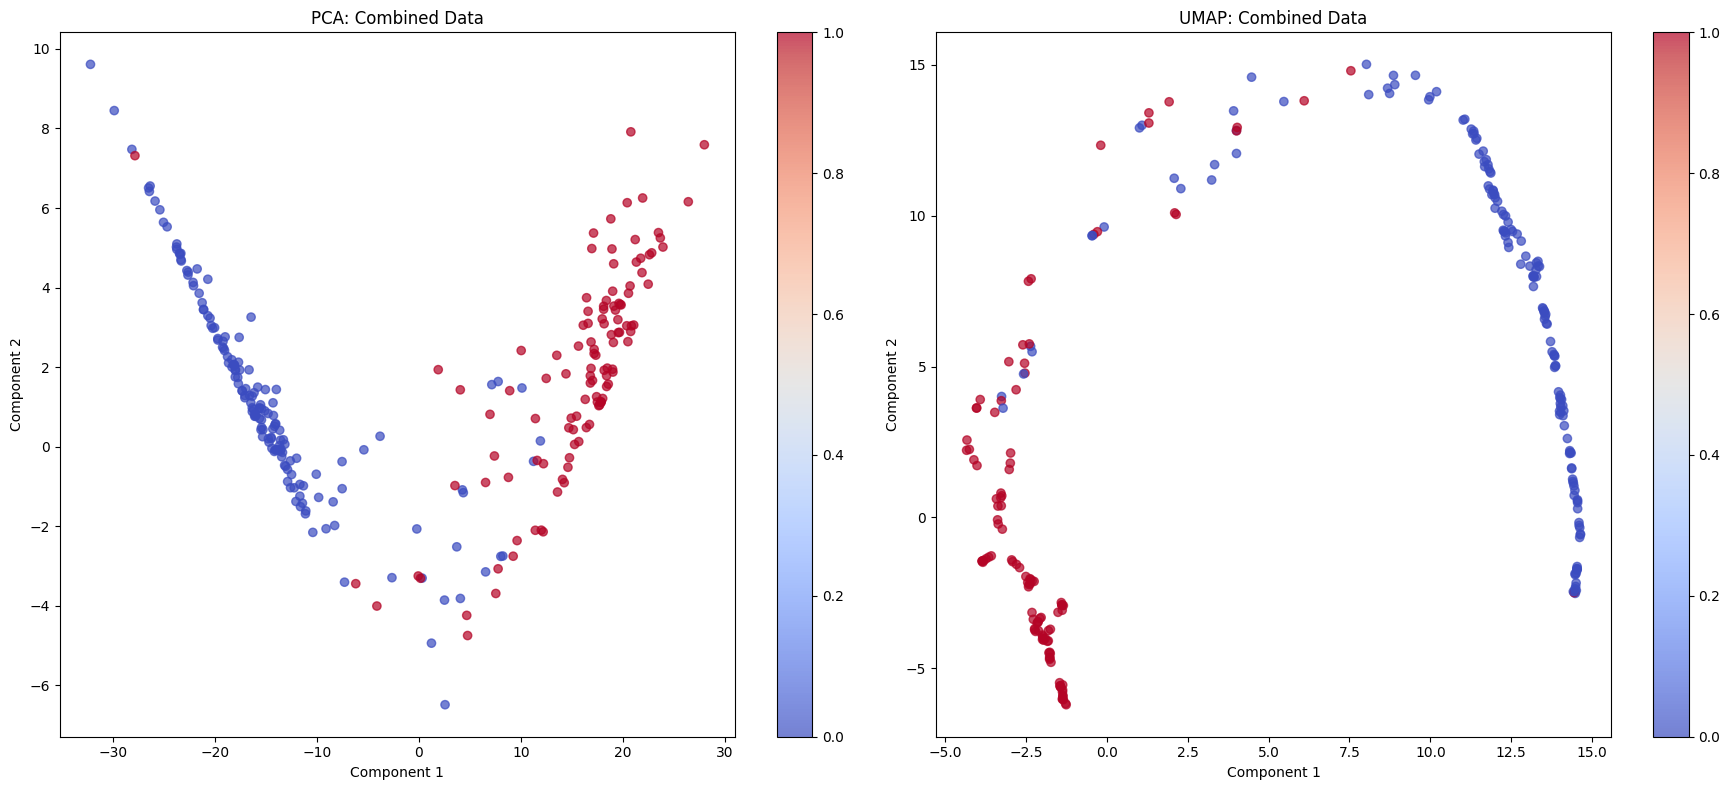

In [147]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import best_model_latent_plot_combined

fig, axes= best_model_latent_plot_combined(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task)

plt.show()

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



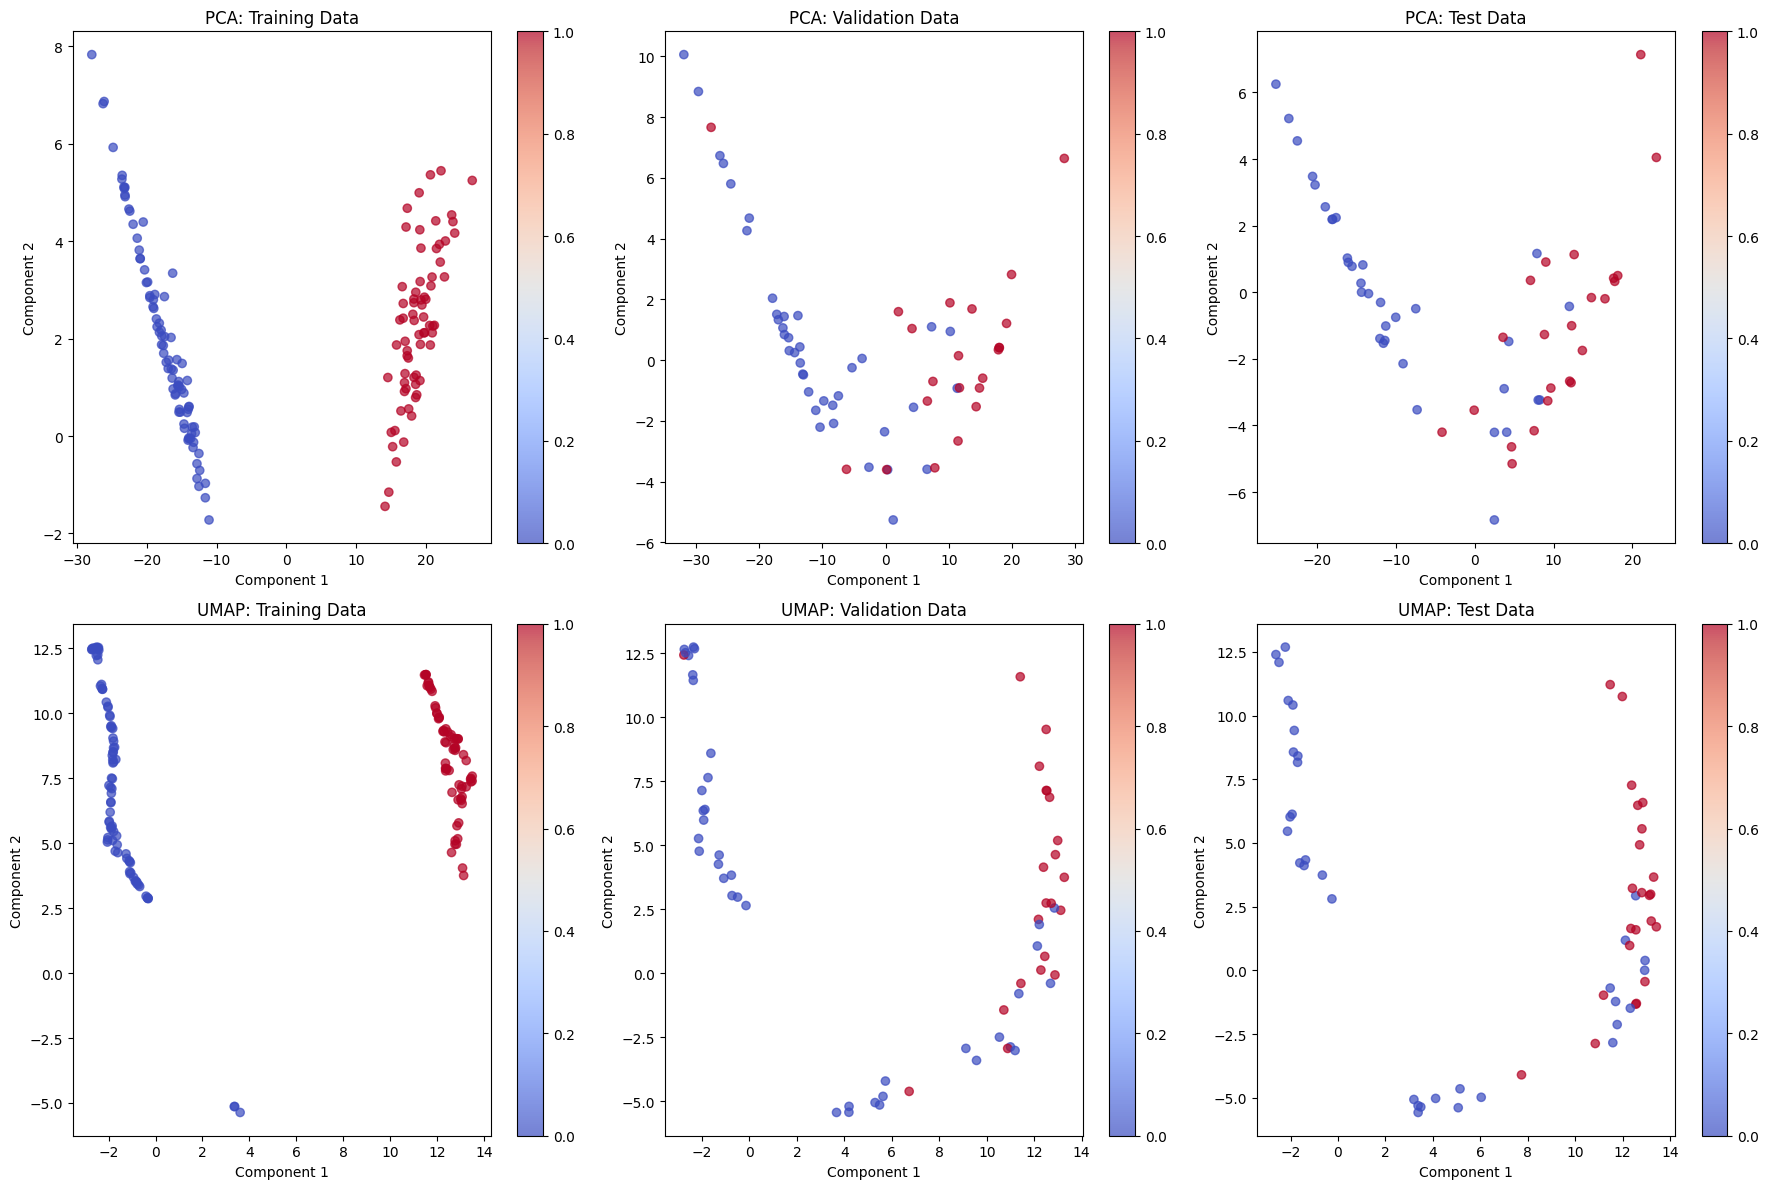

In [148]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import best_model_latent_plot


fig, axes=best_model_latent_plot(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task)

plt.show()